In [4]:
# !pip install phik
# !pip install sentence-transformers
# !pip install seaborn
# !pip install --user -U nltk
# !pip install --user -U gensim
# !pip install pymystem3

Using cached pymystem3-0.2.0-py3-none-any.whl (10 kB)


In [2]:
import os
import sys
import re
import seaborn as sns
import pandas as pd
import numpy as np

import scipy
import scipy.stats

from pathlib import Path
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

parent_dir = Path().resolve()
sys.path.insert(1, os.path.join(parent_dir, "../src"))
from tmeval import TmEval

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [6]:
# from importlib import reload 
# import tmeval
# TmEval = reload(tmeval).TmEval

In [3]:
sns.set_style("whitegrid")

In [4]:
BASE_DIR = Path('result_analysis.ipynb').resolve().parent.parent
DATA_DIR = BASE_DIR.joinpath('data/results')

In [5]:
def words_to_num(x):
    class_labels = {
        'bad': -2,
        'rather_bad': -1,
        'neutral': 0,
        'rather_good': 1,
        'good': 2
    }
    return class_labels[x]

# Initial Dataset

In [6]:
DATASETS_NAME = "datasets_name.csv"
DATASETS_DIR = BASE_DIR.joinpath('data/datasets')
DATASETS_NAME = DATASETS_DIR.joinpath(DATASETS_NAME)
datasets_name = pd.read_csv(
    DATASETS_NAME, 
    sep=",", 
    header=0
)

datasets_name

INPUT:wordset INPUT:dataset_name  \
0     able amaze fill glad stop daily fantastic move...        amazon_food   
1     able amaze fill stop glad daily fantastic move...        amazon_food   
2     able amaze fill stop glad daily fantastic move...        amazon_food   
3     able amaze glad fill stop fantastic daily move...        amazon_food   
4     absolute church truth doug scripture symbol li...       20newsgroups   
...                                                 ...                ...   
3856  year two size old every last month start since...        amazon_food   
3857  year two size old every last month start week ...        amazon_food   
3858  year two size old last month every start week ...        amazon_food   
3859  year work two every size old last month start ...        amazon_food   
3860  year work two size old last month start long w...        amazon_food   

      ASSIGNMENT:worker_id  
0                        3  
1                       12  
2                        3  
3                        3  
4                        5  
...                    ...  
3856                     3  
3857                     6  
3858                     3  
3859                     3  
3860                     3  

[3861 rows x 3 columns]

In [7]:
print("Datasets:", list(set(datasets_name["INPUT:dataset_name"])))

Datasets: ['20newsgroups', 'amazon_food']


In [8]:
# Divide the entire dataset into parts by the dataset name
amazon_food_data = datasets_name[datasets_name["INPUT:dataset_name"]=="amazon_food"]
newsgroups_data = datasets_name[datasets_name["INPUT:dataset_name"]=="20newsgroups"]

amazon_food_texts = amazon_food_data["INPUT:wordset"]
newsgroups_texts = newsgroups_data["INPUT:wordset"]

# Classification

## Two classes

In [88]:
PROMPT_MISTRAL_1 = "data_qality_estim_mistral_7b_4bit_type3.csv"
PROMPT_MISTRAL_2 = "data_qality_estim_mistral_7b_4bit_type5.csv"
PROMPT_MISTRAL_3 = "data_qality_estim_mistral_7b_4bit_type6.csv"
PROMPT_LLAMA2 = "data_qality_estim_llama_13b_4bit_type1.csv"
PROMPT_MISTRAL_LORA = "text_coherence_mistral_7B_LoRA_2classification.csv"
PROMPT_LLAMA3 = "llama3_8B_2classes.csv"
INITIAL = "data_quality_estim.csv"

PROMPT_MISTRAL_1 = DATA_DIR.joinpath(PROMPT_MISTRAL_1)
PROMPT_MISTRAL_2 = DATA_DIR.joinpath(PROMPT_MISTRAL_2)
PROMPT_MISTRAL_3 = DATA_DIR.joinpath(PROMPT_MISTRAL_3)
PROMPT_LLAMA2 = DATA_DIR.joinpath(PROMPT_LLAMA2)
PROMPT_MISTRAL_LORA = DATA_DIR.joinpath(PROMPT_MISTRAL_LORA)
PROMPT_LLAMA3 = DATA_DIR.joinpath(PROMPT_LLAMA3)

INITIAL_FILE_DIR = BASE_DIR.joinpath('data/datasets')
INITIAL_DATA = INITIAL_FILE_DIR.joinpath(INITIAL)

data_prompt_mistral_1 = pd.read_csv(PROMPT_MISTRAL_1, sep=";", names=["task", "true", "model"])
data_prompt_mistral_2 = pd.read_csv(PROMPT_MISTRAL_2, sep=";", names=["task", "true", "model"])
data_prompt_mistral_3 = pd.read_csv(PROMPT_MISTRAL_3, sep=";", names=["task", "true", "model"])
data_prompt_llama2 = pd.read_csv(PROMPT_LLAMA2, sep=";", names=["task", "true", "model"])
data_prompt_llama3 = pd.read_csv(PROMPT_LLAMA3, sep="\t", names=["task", "true", "model"])
data_prompt_mistral_lora = pd.read_csv(PROMPT_MISTRAL_LORA, sep=",", names=["true", "model_extracted", "task"], header=0)

data_initial = pd.read_csv(INITIAL_DATA, sep=',')

### Baseline (Uniform Random Classifier)

In [9]:
np.random.seed(0)

data_initial = data_initial.rename(columns={"agg_label": "true"})

data_initial["model_extracted"] = [np.random.choice(["bad", "good"]) for i in range(data_initial.shape[0])]
# data_initial["model_extracted"] = np.random.randint(2, size=data_initial.shape[0])
data_initial.head(10)

task  true model_extracted
0  able amaze fill glad stop daily fantastic move...   bad             bad
1  able amaze fill stop glad daily fantastic move...   bad            good
2  able amaze fill stop glad daily fantastic move...   bad            good
3  able amaze glad fill stop fantastic daily move...   bad             bad
4  absolute church truth doug scripture symbol li...  good            good
5  absolute church truth mission nasa doug mars e...   bad            good
6  absolute mission church nasa mars earth truth ...  good            good
7  absolutely fast white rice service noodle terr...   bad            good
8  absolutely fast white super service customer r...  good            good
9  absolutely grain experience soon there's proce...   bad            good

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_amazon_distrib_2classes.svg


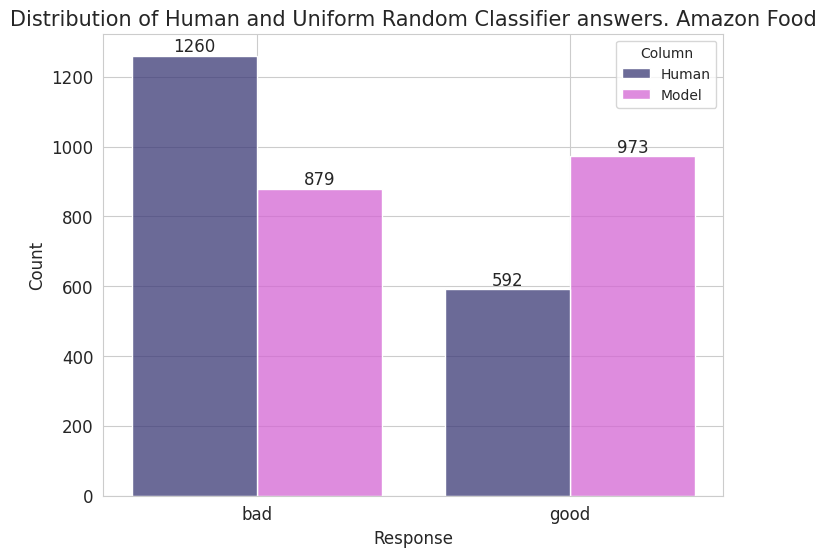

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_newsgroups_distrib_2classes.svg


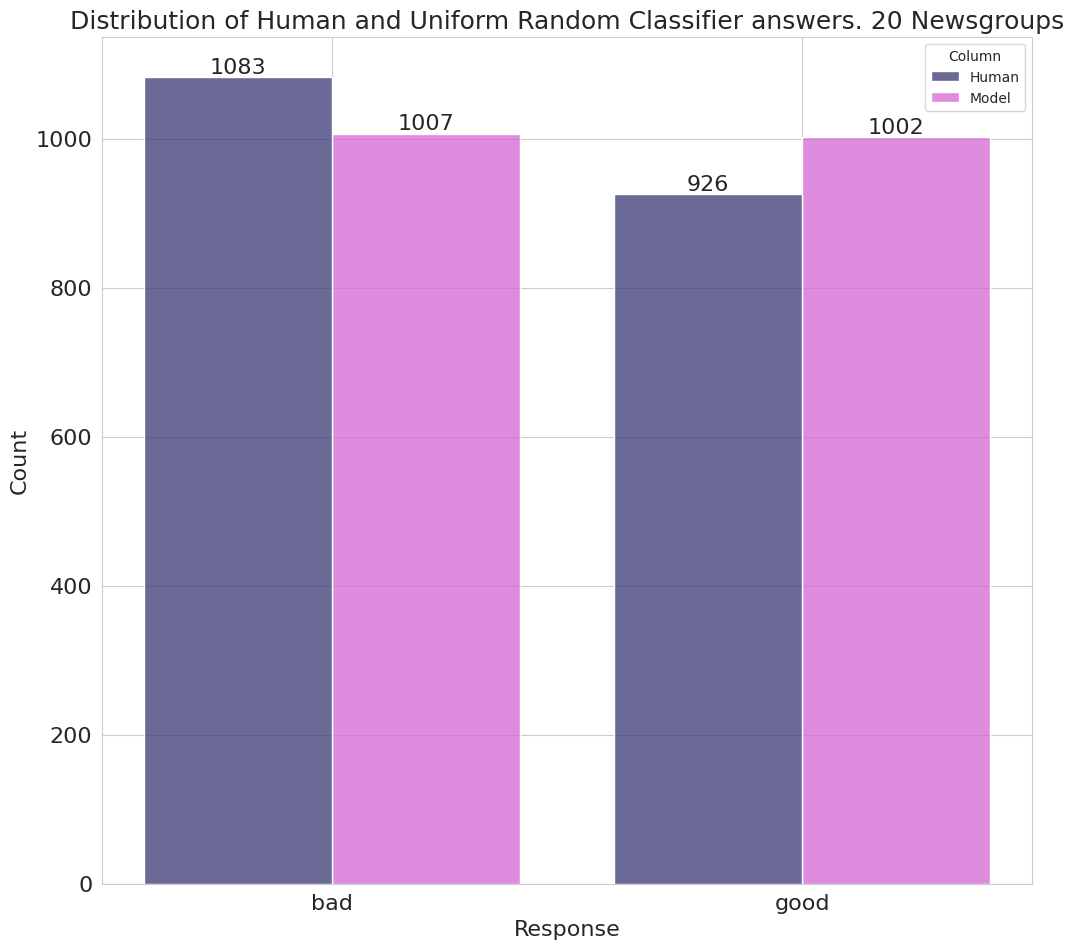

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_amazon_conf_matrix_2classes.png


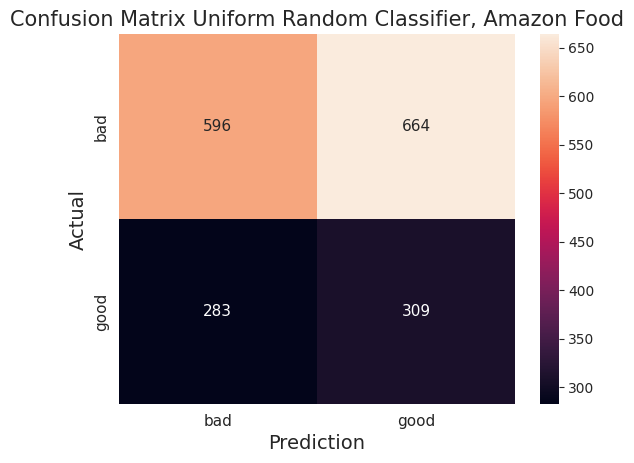

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_newsgroups_conf_matrix_2classes.png


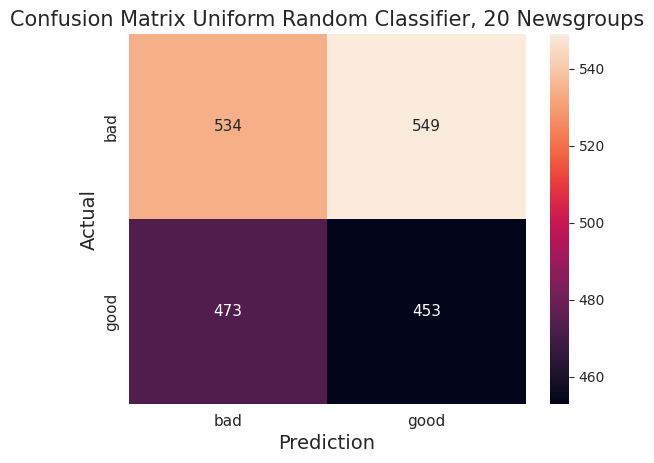

In [10]:
# Divide into two datasets
results_amazon = data_initial[data_initial["task"].isin(amazon_food_texts)]
results_newsgroups = data_initial[data_initial["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    results_amazon,
    model_name='Uniform Random Classifier',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_amazon_distrib_2classes.svg'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_answers_distrib(
    results_newsgroups,
    model_name='Uniform Random Classifier',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_newsgroups_distrib_2classes.svg'),
    print_plot=True,
    num_class=2,
    fig_size=(12, 11),
    title_size=18,
    ticks_size=16,
    label_size=16,
    container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(results_amazon["true"]),
    np.array(results_amazon["model_extracted"]),
    model_name="Uniform Random Classifier, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_amazon_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_conf_matrix(
    np.array(results_newsgroups["true"]),
    np.array(results_newsgroups["model_extracted"]),
    model_name="Uniform Random Classifier, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_newsgroups_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

In [11]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=results_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_amazon_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=results_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_newsgroups_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.488661  0.476079

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.491289  0.490461


#### Results of the Metrics

In [12]:
# Let's convert respondent's answers
data_initial["true_num"] = [words_to_num(x) for x in data_initial["true"]]

In [14]:
# Let's calculate metrics for model's answers
data_initial["model_extracted"] = [words_to_num(x) for x in data_initial["model_extracted"]]
data_initial["classification_metric"] = TmEval.classification_metric(data=data_initial["model_extracted"], num_class=2)
data_initial.head(10)

task  true  model_extracted  \
0  able amaze fill glad stop daily fantastic move...   bad               -2   
1  able amaze fill stop glad daily fantastic move...   bad                2   
2  able amaze fill stop glad daily fantastic move...   bad                2   
3  able amaze glad fill stop fantastic daily move...   bad               -2   
4  absolute church truth doug scripture symbol li...  good                2   
5  absolute church truth mission nasa doug mars e...   bad                2   
6  absolute mission church nasa mars earth truth ...  good                2   
7  absolutely fast white rice service noodle terr...   bad                2   
8  absolutely fast white super service customer r...  good                2   
9  absolutely grain experience soon there's proce...   bad                2   

   true_num  classification_metric  
0        -2                      0  
1        -2                      1  
2        -2                      1  
3        -2                      0  
4         2                      1  
5        -2                      1  
6         2                      1  
7        -2                      1  
8         2                      1  
9        -2                      1

In [15]:
data_initial.to_csv("URC_classification_2.csv")

In [16]:
tmp_res_def = data_initial[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
results_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
results_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=results_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_amazon_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=results_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_newsgroups_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']


   phik   pearson accuracy f1_score
0   0.0 -0.004692        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
   phik  pearson accuracy f1_score
0   0.0 -0.01767        -        -


### Few-shot Mistral TYPE I

You will receive a list of words, and you should answer "YES" or "NO" to the question: "Is it possible to determine a common topic for the presented word set or at least for the most part of the set?"

bike firearm knife criminal carry death weapon scsi murder smith handgun moral child defense tape // YES

appreciate advance anybody info thank experience hello greatly suggestion wonder edge able email recently thanx // NO

bible christ matthew heaven scripture lord father word passage teach mary spirit doctrine verse faith // YES

In [14]:
data_prompt_mistral_1.head(10)

task  true     model
0  pack variety com www http href stash pie grey ...   bad    NO</s>
1  south island ship secret military rutgers brit...   bad    NO</s>
2  piece beef jerky everything season break pill ...   bad   YES</s>
3  mix cream ice pour strawberry stir pancake waf...  good    NO</s>
4  window display screen color server application...  good   YES</s>
5  magnesium oil olive energy diamond bowel blue ...  good    NO</s>
6  encryption chip clipper security escrow secure...  good   YES</s>
7  dry liver freeze gravy movie walk cube lick st...   bad    NO</s>
8  bone bubble rawh oat gum chewer miso slim chin...   bad    NO</s>
9  year month friend husband gift weight ago lose...   bad   YES</s>

In [15]:
# Results postprocessing
data_prompt_mistral_1 = TmEval.postprocess_results(
    data_prompt_mistral_1, 
    num_class=2,
    answer_type="word"
)
data_prompt_mistral_1.head(10)

task  true     model  \
0  pack variety com www http href stash pie grey ...   bad    NO</s>   
1  south island ship secret military rutgers brit...   bad    NO</s>   
2  piece beef jerky everything season break pill ...   bad   YES</s>   
3  mix cream ice pour strawberry stir pancake waf...  good    NO</s>   
4  window display screen color server application...  good   YES</s>   
5  magnesium oil olive energy diamond bowel blue ...  good    NO</s>   
6  encryption chip clipper security escrow secure...  good   YES</s>   
7  dry liver freeze gravy movie walk cube lick st...   bad    NO</s>   
8  bone bubble rawh oat gum chewer miso slim chin...   bad    NO</s>   
9  year month friend husband gift weight ago lose...   bad   YES</s>   

   model_extracted  
0               -2  
1               -2  
2                2  
3               -2  
4                2  
5               -2  
6                2  
7               -2  
8               -2  
9                2

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_amazon_distrib_2classes.svg


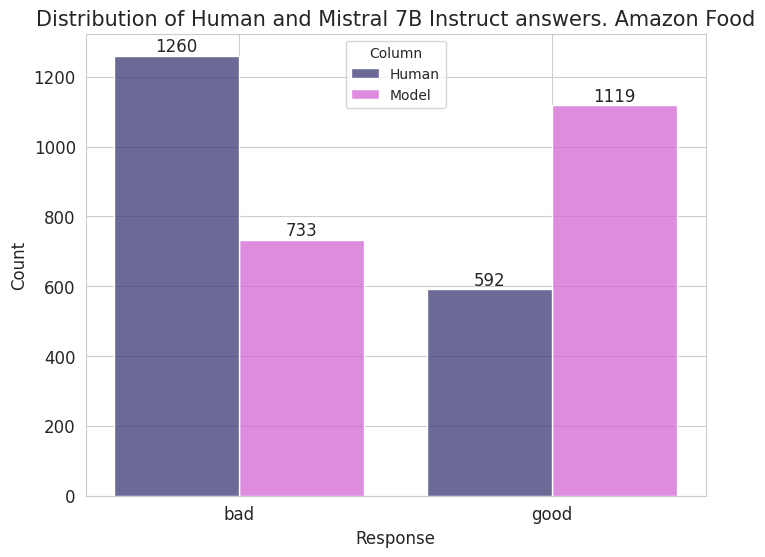

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_newsgroups_distrib_2classes.svg


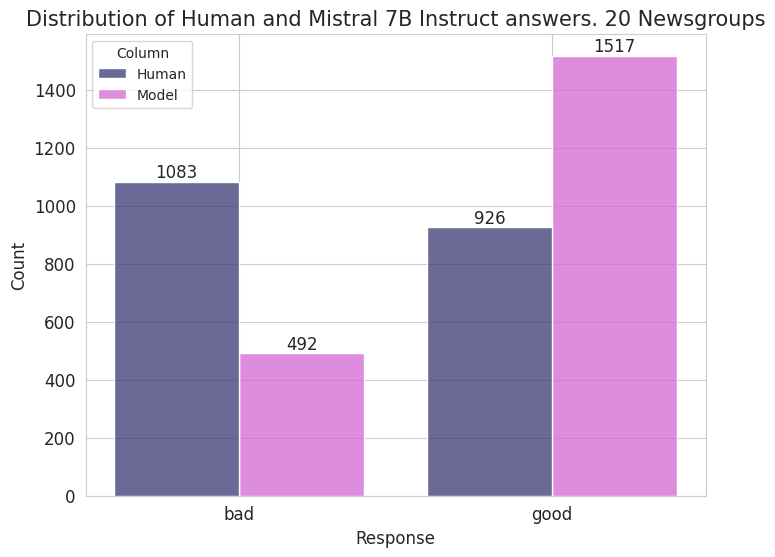

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_amazon_conf_matrix_2classes.png


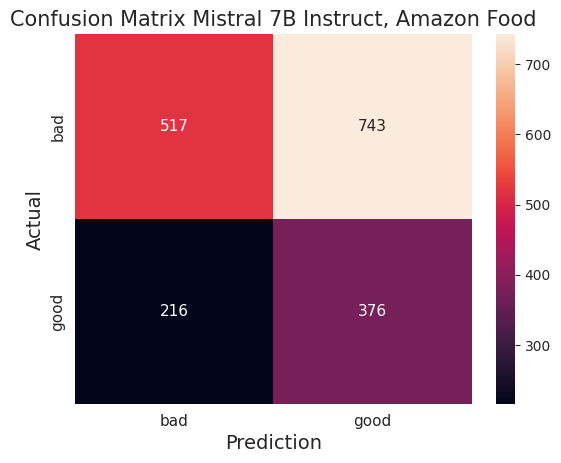

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_newsgroups_conf_matrix_2classes.png


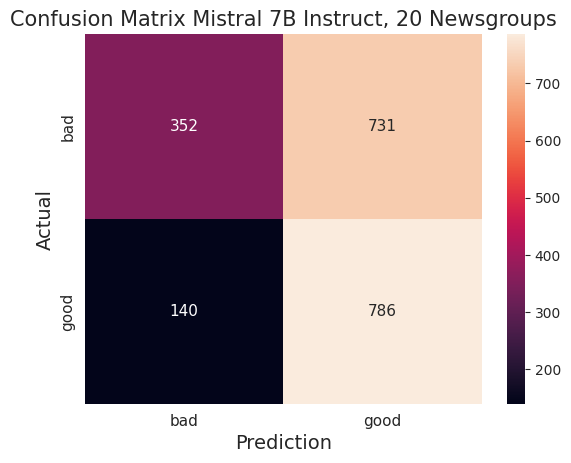

In [16]:
# Divide into two datasets
data_prompt_mistral_1_amazon = data_prompt_mistral_1[data_prompt_mistral_1["task"].isin(amazon_food_texts)]
data_prompt_mistral_1_newsgroups = data_prompt_mistral_1[data_prompt_mistral_1["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_mistral_1_amazon,
    model_name='Mistral 7B Instruct',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_amazon_distrib_2classes.svg'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_answers_distrib(
    data_prompt_mistral_1_newsgroups,
    model_name='Mistral 7B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_newsgroups_distrib_2classes.svg'),
    print_plot=True,
    num_class=2,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_1_amazon["true"]),
    np.array(data_prompt_mistral_1_amazon["model_extracted"]),
    model_name="Mistral 7B Instruct, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_amazon_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_1_newsgroups["true"]),
    np.array(data_prompt_mistral_1_newsgroups["model_extracted"]),
    model_name="Mistral 7B Instruct, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_newsgroups_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

In [17]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_1_amazon_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_1_newsgroups_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.482181  0.479162

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.566451  0.545228


#### Results of the Metrics

In [18]:
# Let's convert respondent's answers
data_prompt_mistral_1["true_num"] = [words_to_num(x) for x in data_prompt_mistral_1["true"]]

In [19]:
# Let's calculate metrics for model's answers
data_prompt_mistral_1["classification_metric"] = TmEval.classification_metric(data=data_prompt_mistral_1["model_extracted"], num_class=2)
data_prompt_mistral_1.head(10)

task  true     model  \
0  pack variety com www http href stash pie grey ...   bad    NO</s>   
1  south island ship secret military rutgers brit...   bad    NO</s>   
2  piece beef jerky everything season break pill ...   bad   YES</s>   
3  mix cream ice pour strawberry stir pancake waf...  good    NO</s>   
4  window display screen color server application...  good   YES</s>   
5  magnesium oil olive energy diamond bowel blue ...  good    NO</s>   
6  encryption chip clipper security escrow secure...  good   YES</s>   
7  dry liver freeze gravy movie walk cube lick st...   bad    NO</s>   
8  bone bubble rawh oat gum chewer miso slim chin...   bad    NO</s>   
9  year month friend husband gift weight ago lose...   bad   YES</s>   

   model_extracted  true_num  classification_metric  
0               -2        -2                      0  
1               -2        -2                      0  
2                2        -2                      1  
3               -2         2                      0  
4                2         2                      1  
5               -2         2                      0  
6                2         2                      1  
7               -2        -2                      0  
8               -2        -2                      0  
9                2        -2                      1

In [20]:
data_prompt_mistral_1.to_csv("mistral1_classification_2.csv")

In [21]:
tmp_res_def = data_prompt_mistral_1[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_mistral_1_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_mistral_1_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_1_amazon_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_1_newsgroups_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.055247  0.043345        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.307742  0.201503        -        -


### Few-shot Mistral TYPE II

Select one of two categories-characteristics of the provided set of tokens by answering the question ”Is it possible to determine a common topic for the presented word set or at least for the most part of the set?”.

You could answer one of the following: YES - if you agree with the statement and words have a strong connection between them, NO - when words seem to be unconnected. Please, make sure you to only return YES or NO and nothing more.


bike firearm knife criminal carry death weapon scsi murder smith handgun moral child defense tape // YES

appreciate advance anybody info thank experience hello greatly suggestion wonder edge able email recently thanx // NO

bible christ matthew heaven scripture lord father word passage teach mary spirit doctrine verse faith // YES

In [22]:
data_prompt_mistral_2.head(10)

task  true     model
0  pack variety com www http href stash pie grey ...   bad   YES</s>
1  south island ship secret military rutgers brit...   bad   YES</s>
2  piece beef jerky everything season break pill ...   bad   YES</s>
3  mix cream ice pour strawberry stir pancake waf...  good   YES</s>
4  window display screen color server application...  good   YES</s>
5  magnesium oil olive energy diamond bowel blue ...  good   YES</s>
6  encryption chip clipper security escrow secure...  good   YES</s>
7  dry liver freeze gravy movie walk cube lick st...   bad   YES</s>
8  bone bubble rawh oat gum chewer miso slim chin...   bad   YES</s>
9  year month friend husband gift weight ago lose...   bad   YES</s>

In [23]:
# Results postprocessing
data_prompt_mistral_2 = TmEval.postprocess_results(
    data_prompt_mistral_2, 
    num_class=2, 
    answer_type="word"
)
data_prompt_mistral_2.head(10)

task  true     model  \
0  pack variety com www http href stash pie grey ...   bad   YES</s>   
1  south island ship secret military rutgers brit...   bad   YES</s>   
2  piece beef jerky everything season break pill ...   bad   YES</s>   
3  mix cream ice pour strawberry stir pancake waf...  good   YES</s>   
4  window display screen color server application...  good   YES</s>   
5  magnesium oil olive energy diamond bowel blue ...  good   YES</s>   
6  encryption chip clipper security escrow secure...  good   YES</s>   
7  dry liver freeze gravy movie walk cube lick st...   bad   YES</s>   
8  bone bubble rawh oat gum chewer miso slim chin...   bad   YES</s>   
9  year month friend husband gift weight ago lose...   bad   YES</s>   

   model_extracted  
0                2  
1                2  
2                2  
3                2  
4                2  
5                2  
6                2  
7                2  
8                2  
9                2

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_amazon_distrib_2classes.svg


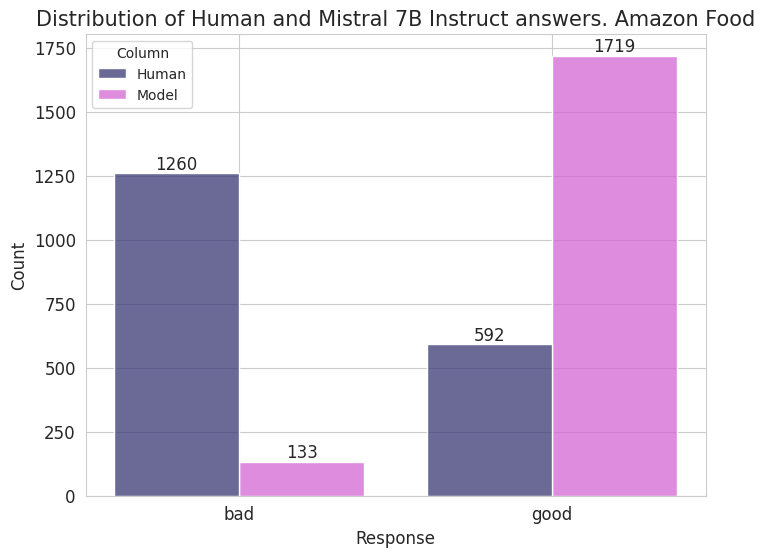

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_newsgroups_distrib_2classes.svg


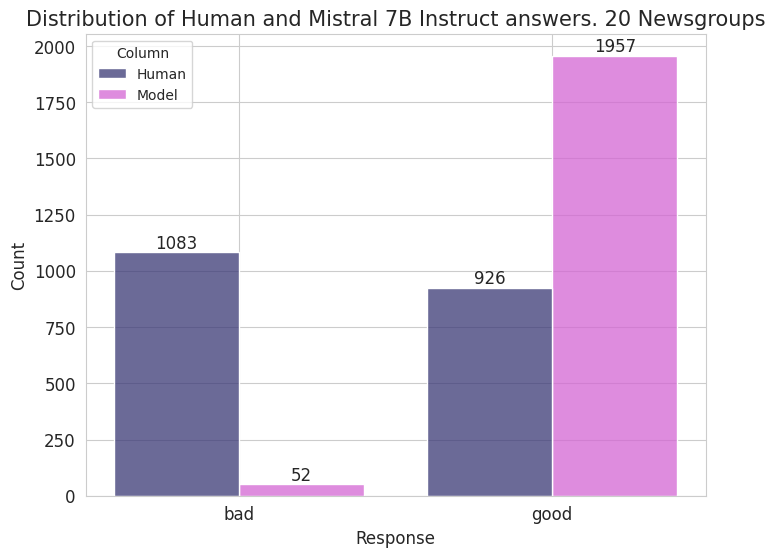

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_amazon_conf_matrix_2classes.png


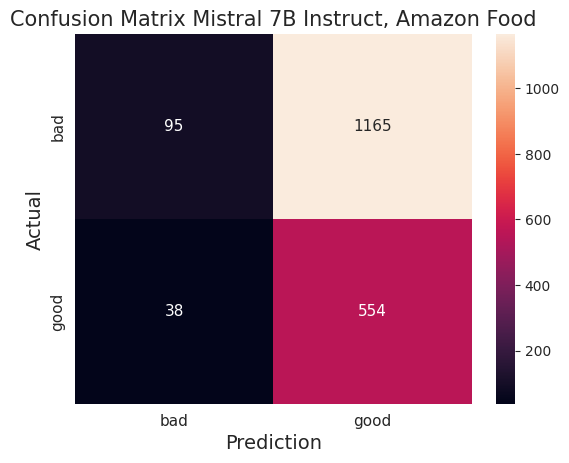

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_newsgroups_conf_matrix_2classes.png


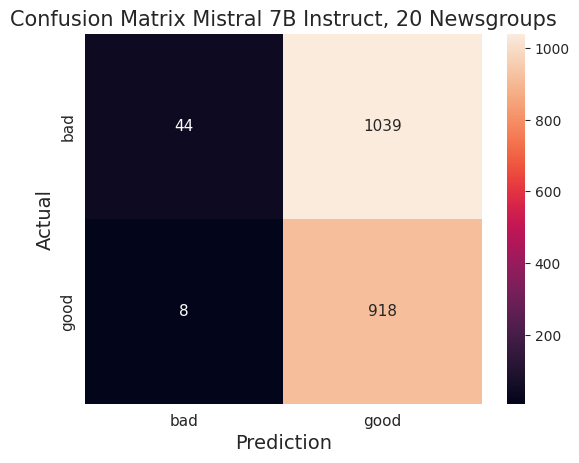

In [24]:
# Divide into two datasets
data_prompt_mistral_2_amazon = data_prompt_mistral_2[data_prompt_mistral_2["task"].isin(amazon_food_texts)]
data_prompt_mistral_2_newsgroups = data_prompt_mistral_2[data_prompt_mistral_2["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_mistral_2_amazon,
    model_name='Mistral 7B Instruct',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_amazon_distrib_2classes.svg'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_answers_distrib(
    data_prompt_mistral_2_newsgroups,
    model_name='Mistral 7B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_newsgroups_distrib_2classes.svg'),
    print_plot=True,
    num_class=2,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_2_amazon["true"]),
    np.array(data_prompt_mistral_2_amazon["model_extracted"]),
    model_name="Mistral 7B Instruct, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_amazon_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_2_newsgroups["true"]),
    np.array(data_prompt_mistral_2_newsgroups["model_extracted"]),
    model_name="Mistral 7B Instruct, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_newsgroups_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

In [25]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_2_amazon_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_2_newsgroups_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.350432  0.307921

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.478845  0.357185


#### Results of the Metrics

In [26]:
# Let's convert respondent's answers
data_prompt_mistral_2["true_num"] = [words_to_num(x) for x in data_prompt_mistral_2["true"]]

In [27]:
# Let's calculate metrics for model's answers
data_prompt_mistral_2["classification_metric"] = TmEval.classification_metric(data=data_prompt_mistral_2["model_extracted"], num_class=2)
data_prompt_mistral_2.head(10)

task  true     model  \
0  pack variety com www http href stash pie grey ...   bad   YES</s>   
1  south island ship secret military rutgers brit...   bad   YES</s>   
2  piece beef jerky everything season break pill ...   bad   YES</s>   
3  mix cream ice pour strawberry stir pancake waf...  good   YES</s>   
4  window display screen color server application...  good   YES</s>   
5  magnesium oil olive energy diamond bowel blue ...  good   YES</s>   
6  encryption chip clipper security escrow secure...  good   YES</s>   
7  dry liver freeze gravy movie walk cube lick st...   bad   YES</s>   
8  bone bubble rawh oat gum chewer miso slim chin...   bad   YES</s>   
9  year month friend husband gift weight ago lose...   bad   YES</s>   

   model_extracted  true_num  classification_metric  
0                2        -2                      1  
1                2        -2                      1  
2                2        -2                      1  
3                2         2                      1  
4                2         2                      1  
5                2         2                      1  
6                2         2                      1  
7                2        -2                      1  
8                2        -2                      1  
9                2        -2                      1

In [28]:
data_prompt_mistral_2.to_csv("mistral2_classification_2.csv")

In [29]:
tmp_res_def = data_prompt_mistral_2[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_mistral_2_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_mistral_2_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_21_amazon_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_2_newsgroups_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
   phik   pearson accuracy f1_score
0   0.0  0.020244        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.148216  0.100419        -        -


### Few-shot TYPE III

You are a human. Select one of two categories-characteristics of the provided set of tokens by answering the question ”Is it possible to determine a common topic for the presented word set or at least for the most part of the set?”.
You could answer one of the following: YES - if you agree with the statement and words have a strong connection between them, NO - when words seem to be unconnected. Please, make sure you to only return YES or NO and nothing more.

bike firearm knife criminal carry death weapon scsi murder smith handgun moral child defense tape // YES

appreciate advance anybody info thank experience hello greatly suggestion wonder edge able email recently thanx // NO

bible christ matthew heaven scripture lord father word passage teach mary spirit doctrine verse faith // YES

In [30]:
data_prompt_mistral_3.head(10)

task  true     model
0  pack variety com www http href stash pie grey ...   bad    NO</s>
1  south island ship secret military rutgers brit...   bad   YES</s>
2  piece beef jerky everything season break pill ...   bad    NO</s>
3  mix cream ice pour strawberry stir pancake waf...  good    NO</s>
4  window display screen color server application...  good   YES</s>
5  magnesium oil olive energy diamond bowel blue ...  good    NO</s>
6  encryption chip clipper security escrow secure...  good   YES</s>
7  dry liver freeze gravy movie walk cube lick st...   bad    NO</s>
8  bone bubble rawh oat gum chewer miso slim chin...   bad    NO</s>
9  year month friend husband gift weight ago lose...   bad    NO</s>

In [31]:
# Results postprocessing
data_prompt_mistral_3 = TmEval.postprocess_results(
    data_prompt_mistral_3, 
    num_class=2,
    answer_type="word"
)
data_prompt_mistral_3.head(10)

task  true     model  \
0  pack variety com www http href stash pie grey ...   bad    NO</s>   
1  south island ship secret military rutgers brit...   bad   YES</s>   
2  piece beef jerky everything season break pill ...   bad    NO</s>   
3  mix cream ice pour strawberry stir pancake waf...  good    NO</s>   
4  window display screen color server application...  good   YES</s>   
5  magnesium oil olive energy diamond bowel blue ...  good    NO</s>   
6  encryption chip clipper security escrow secure...  good   YES</s>   
7  dry liver freeze gravy movie walk cube lick st...   bad    NO</s>   
8  bone bubble rawh oat gum chewer miso slim chin...   bad    NO</s>   
9  year month friend husband gift weight ago lose...   bad    NO</s>   

   model_extracted  
0               -2  
1                2  
2               -2  
3               -2  
4                2  
5               -2  
6                2  
7               -2  
8               -2  
9               -2

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_3_amazon_distrib_2classes.svg


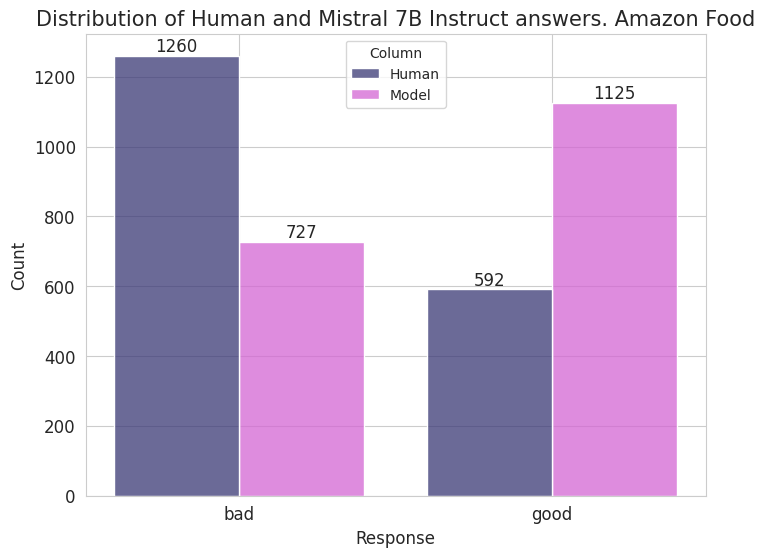

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_3_newsgroups_distrib_2classes.svg


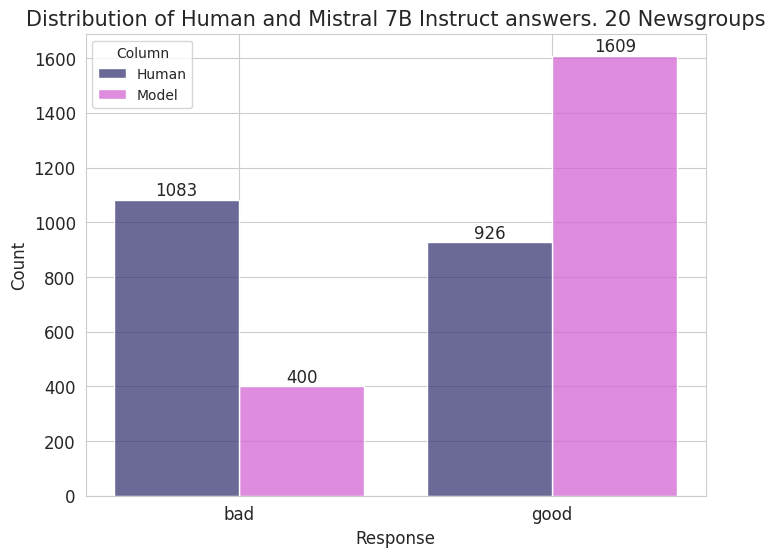

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_3_amazon_conf_matrix_2classes.png


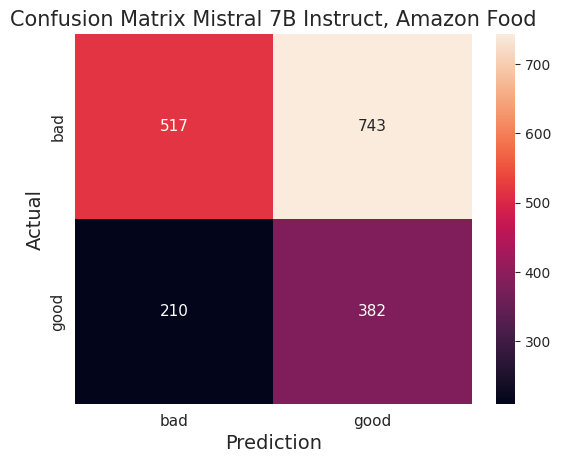

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_3_newsgroups_conf_matrix_2classes.png


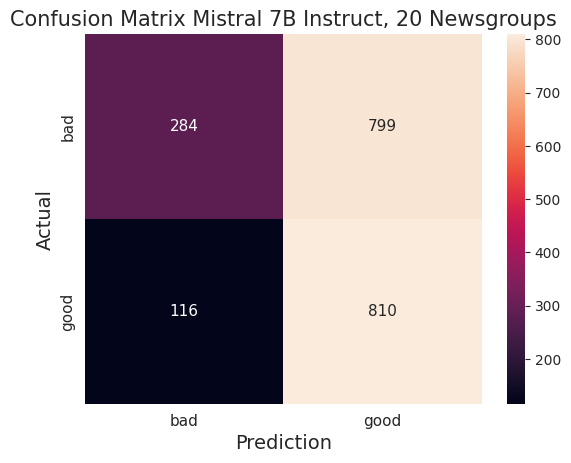

In [32]:
# Divide into two datasets
data_prompt_mistral_3_amazon = data_prompt_mistral_3[data_prompt_mistral_3["task"].isin(amazon_food_texts)]
data_prompt_mistral_3_newsgroups = data_prompt_mistral_3[data_prompt_mistral_3["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_mistral_3_amazon,
    model_name='Mistral 7B Instruct',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_3_amazon_distrib_2classes.svg'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_answers_distrib(
    data_prompt_mistral_3_newsgroups,
    model_name='Mistral 7B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_3_newsgroups_distrib_2classes.svg'),
    print_plot=True,
    num_class=2,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_3_amazon["true"]),
    np.array(data_prompt_mistral_3_amazon["model_extracted"]),
    model_name="Mistral 7B Instruct, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_3_amazon_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_3_newsgroups["true"]),
    np.array(data_prompt_mistral_3_newsgroups["model_extracted"]),
    model_name="Mistral 7B Instruct, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_3_newsgroups_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

In [33]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_3_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_3_amazon_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_3_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_3_newsgroups_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.485421  0.482672

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -   0.54455   0.51103


#### Results of the Metrics

In [35]:
# Let's convert respondent's answers
data_prompt_mistral_3["true_num"] = [words_to_num(x) for x in data_prompt_mistral_3["true"]]

In [36]:
# Let's calculate metrics for model's answers
data_prompt_mistral_3["classification_metric"] = TmEval.classification_metric(data=data_prompt_mistral_3["model_extracted"], num_class=2)
data_prompt_mistral_3.head(10)

task  true     model  \
0  pack variety com www http href stash pie grey ...   bad    NO</s>   
1  south island ship secret military rutgers brit...   bad   YES</s>   
2  piece beef jerky everything season break pill ...   bad    NO</s>   
3  mix cream ice pour strawberry stir pancake waf...  good    NO</s>   
4  window display screen color server application...  good   YES</s>   
5  magnesium oil olive energy diamond bowel blue ...  good    NO</s>   
6  encryption chip clipper security escrow secure...  good   YES</s>   
7  dry liver freeze gravy movie walk cube lick st...   bad    NO</s>   
8  bone bubble rawh oat gum chewer miso slim chin...   bad    NO</s>   
9  year month friend husband gift weight ago lose...   bad    NO</s>   

   model_extracted  true_num  classification_metric  
0               -2        -2                      0  
1                2        -2                      1  
2               -2        -2                      0  
3               -2         2                      0  
4                2         2                      1  
5               -2         2                      0  
6                2         2                      1  
7               -2        -2                      0  
8               -2        -2                      0  
9               -2        -2                      0

In [38]:
data_prompt_mistral_3.to_csv("mistral3_classification_2.csv")

In [39]:
tmp_res_def = data_prompt_mistral_3[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_mistral_3_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_mistral_3_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_3_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_3_amazon_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_3_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_3_newsgroups_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.072853  0.053086        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik  pearson accuracy f1_score
0  0.261279  0.17097        -        -


### Llama2-13B

<< SYS >> You are the assistant for text classification << /SYS >>
You will receive a TEXT, and you should answer "YES" or "NO" to the question: "Is it possible to determine a common topic for the TEXT or at least for the most part of the TEXT?". Please, make sure you to only return YES or NO and nothing more.

In [40]:
data_prompt_llama2.head(10)

task  true  \
0  pack variety com www http href stash pie grey ...   bad   
1  south island ship secret military rutgers brit...   bad   
2  piece beef jerky everything season break pill ...   bad   
3  mix cream ice pour strawberry stir pancake waf...  good   
4  window display screen color server application...  good   
5  magnesium oil olive energy diamond bowel blue ...  good   
6  encryption chip clipper security escrow secure...  good   
7  dry liver freeze gravy movie walk cube lick st...   bad   
8  bone bubble rawh oat gum chewer miso slim chin...   bad   
9  year month friend husband gift weight ago lose...   bad   

                                               model  
0                                            NO.</s>  
1                                            NO.</s>  
2                                            NO.</s>  
3                                            NO </s>  
4                                            NO.</s>  
5                                            NO.</s>  
6                                           YES.</s>  
7                                            NO.</s>  
8                                            NO.</s>  
9  NO. There is no common topic that can be deter...

In [41]:
# Results postprocessing
data_prompt_llama2 = TmEval.postprocess_results(
    data_prompt_llama2,
    num_class=2,
    answer_type="word"
)
data_prompt_llama2.head(10)

task  true  \
0  pack variety com www http href stash pie grey ...   bad   
1  south island ship secret military rutgers brit...   bad   
2  piece beef jerky everything season break pill ...   bad   
3  mix cream ice pour strawberry stir pancake waf...  good   
4  window display screen color server application...  good   
5  magnesium oil olive energy diamond bowel blue ...  good   
6  encryption chip clipper security escrow secure...  good   
7  dry liver freeze gravy movie walk cube lick st...   bad   
8  bone bubble rawh oat gum chewer miso slim chin...   bad   
9  year month friend husband gift weight ago lose...   bad   

                                               model  model_extracted  
0                                            NO.</s>               -2  
1                                            NO.</s>               -2  
2                                            NO.</s>               -2  
3                                            NO </s>               -2  
4                                            NO.</s>               -2  
5                                            NO.</s>               -2  
6                                           YES.</s>                2  
7                                            NO.</s>               -2  
8                                            NO.</s>               -2  
9  NO. There is no common topic that can be deter...               -2

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_amazon_distrib_2classes.svg


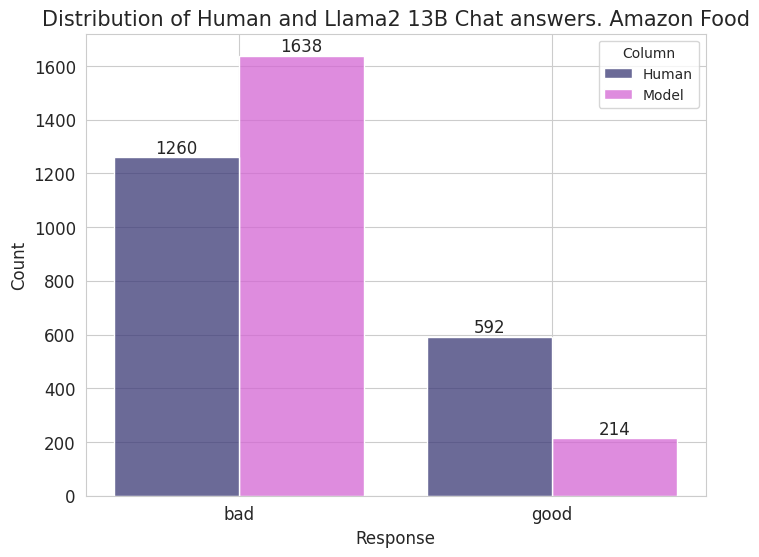

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_newsgroups_distrib_2classes.svg


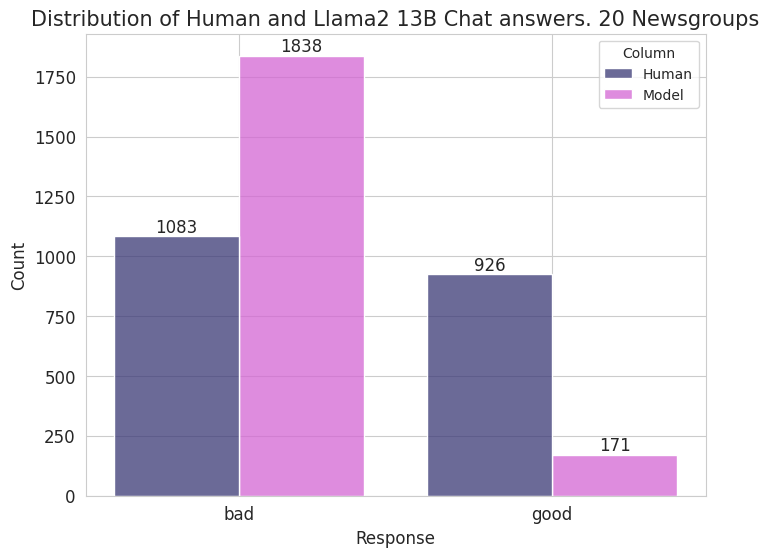

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_amazon_conf_matrix_2classes.png


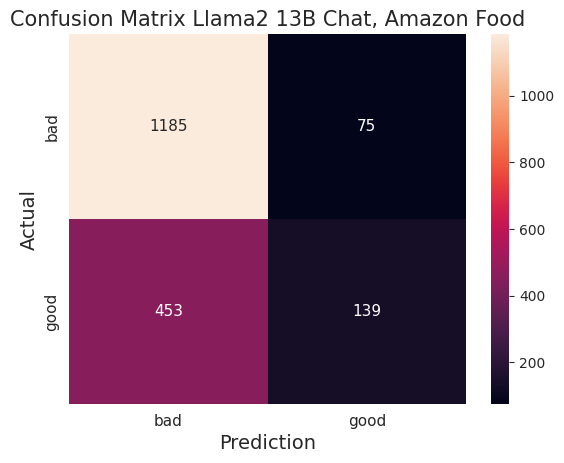

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_newsgroups_conf_matrix_2classes.png


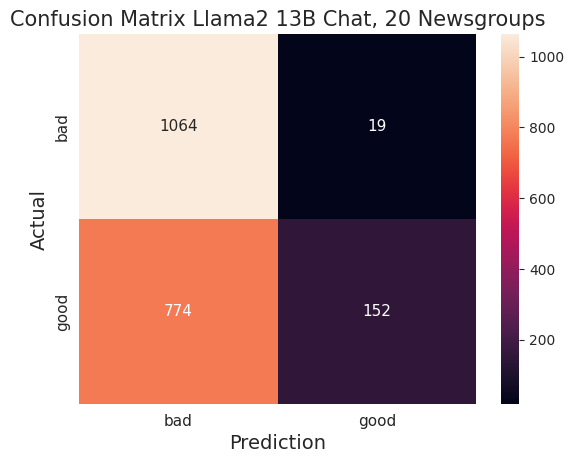

In [42]:
# Divide into two datasets
data_prompt_llama2_amazon = data_prompt_llama2[data_prompt_llama2["task"].isin(amazon_food_texts)]
data_prompt_llama2_newsgroups = data_prompt_llama2[data_prompt_llama2["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_llama2_amazon,
    model_name='Llama2 13B Chat',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_amazon_distrib_2classes.svg'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_answers_distrib(
    data_prompt_llama2_newsgroups,
    model_name='Llama2 13B Chat',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_newsgroups_distrib_2classes.svg'),
    print_plot=True,
    num_class=2,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_llama2_amazon["true"]),
    np.array(data_prompt_llama2_amazon["model_extracted"]),
    model_name="Llama2 13B Chat, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_amazon_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_llama2_newsgroups["true"]),
    np.array(data_prompt_llama2_newsgroups["model_extracted"]),
    model_name="Llama2 13B Chat, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_newsgroups_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

In [43]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_amazon_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_llama2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_newsgroups_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.714903  0.581359

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.605276  0.502819


#### Results of the Metrics

In [44]:
# Let's convert respondent's answers
data_prompt_llama2["true_num"] = [words_to_num(x) for x in data_prompt_llama2["true"]]

In [45]:
# Let's calculate metrics for model's answers
data_prompt_llama2["classification_metric"] = TmEval.classification_metric(data=data_prompt_llama2["model_extracted"], num_class=2)
data_prompt_llama2.head(10)

task  true  \
0  pack variety com www http href stash pie grey ...   bad   
1  south island ship secret military rutgers brit...   bad   
2  piece beef jerky everything season break pill ...   bad   
3  mix cream ice pour strawberry stir pancake waf...  good   
4  window display screen color server application...  good   
5  magnesium oil olive energy diamond bowel blue ...  good   
6  encryption chip clipper security escrow secure...  good   
7  dry liver freeze gravy movie walk cube lick st...   bad   
8  bone bubble rawh oat gum chewer miso slim chin...   bad   
9  year month friend husband gift weight ago lose...   bad   

                                               model  model_extracted  \
0                                            NO.</s>               -2   
1                                            NO.</s>               -2   
2                                            NO.</s>               -2   
3                                            NO </s>               -2   
4                                            NO.</s>               -2   
5                                            NO.</s>               -2   
6                                           YES.</s>                2   
7                                            NO.</s>               -2   
8                                            NO.</s>               -2   
9  NO. There is no common topic that can be deter...               -2   

   true_num  classification_metric  
0        -2                      0  
1        -2                      0  
2        -2                      0  
3         2                      0  
4         2                      0  
5         2                      0  
6         2                      1  
7        -2                      0  
8        -2                      0  
9        -2                      0

In [47]:
data_prompt_llama2.to_csv("llama2_1_classification_2.csv")

In [46]:
tmp_res_def = data_prompt_llama2[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_llama2_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_llama2_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_amazon_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_llama2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_newsgroups_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
      phik   pearson accuracy f1_score
0  0.38685  0.255681        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.395982  0.261874        -        -


### Mistral 7B + LoRA (r = 16)

In [48]:
data_prompt_mistral_lora.head(10)

true model_extracted                                               task
0   bad             bad  able amaze fill glad stop daily fantastic move...
1   bad             bad  able amaze fill stop glad daily fantastic move...
2   bad             bad  able amaze fill stop glad daily fantastic move...
3   bad             bad  able amaze glad fill stop fantastic daily move...
4  good             bad  absolute church truth doug scripture symbol li...
5   bad            good  absolute church truth mission nasa doug mars e...
6  good             bad  absolute mission church nasa mars earth truth ...
7   bad             bad  absolutely fast white rice service noodle terr...
8  good             bad  absolutely fast white super service customer r...
9   bad             bad  absolutely grain experience soon there's proce...

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_amazon_distrib_2classes.svg


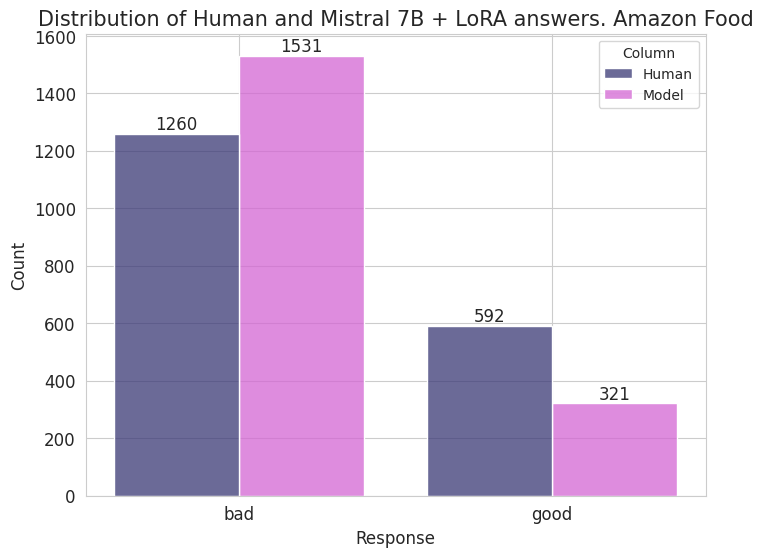

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_newsgroups_distrib_2classes.svg


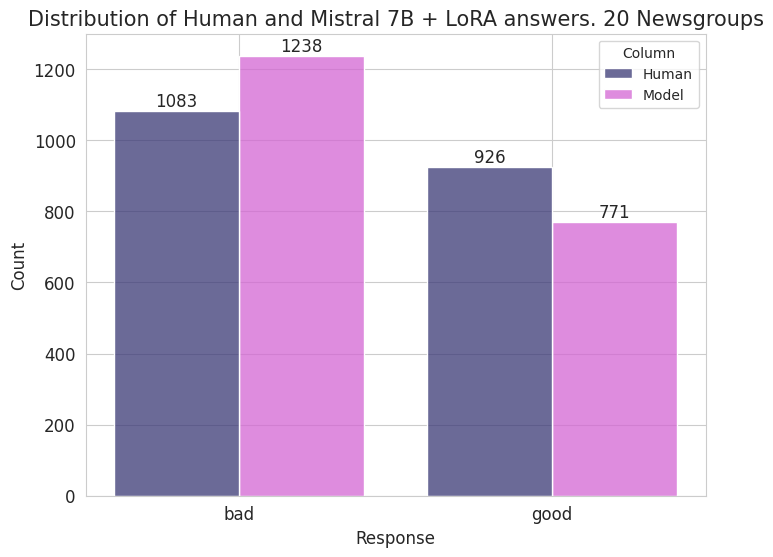

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_amazon_conf_matrix_2classes.png


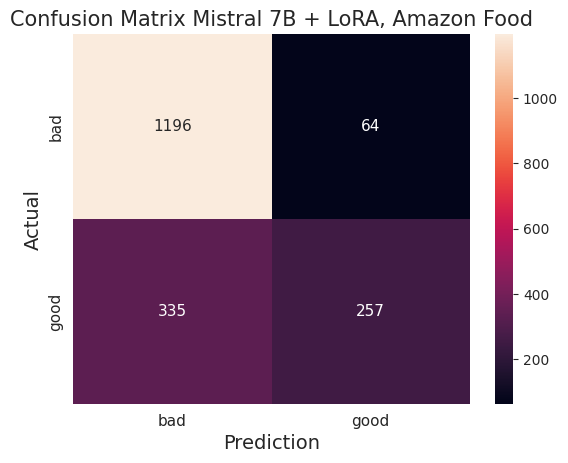

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_newsgroups_conf_matrix_2classes.png


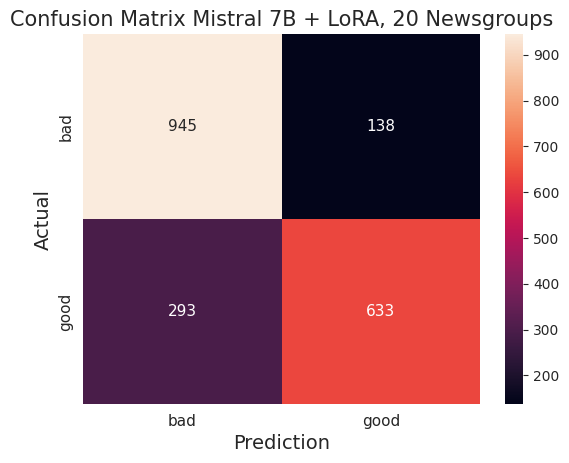

In [49]:
# Divide into two datasets
data_prompt_mistral_lora_amazon = data_prompt_mistral_lora[data_prompt_mistral_lora["task"].isin(amazon_food_texts)]
data_prompt_mistral_lora_newsgroups = data_prompt_mistral_lora[data_prompt_mistral_lora["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_mistral_lora_amazon,
    model_name='Mistral 7B + LoRA',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_amazon_distrib_2classes.svg'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_answers_distrib(
    data_prompt_mistral_lora_newsgroups,
    model_name='Mistral 7B + LoRA',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_newsgroups_distrib_2classes.svg'),
    print_plot=True,
    num_class=2,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_lora_amazon["true"]),
    np.array(data_prompt_mistral_lora_amazon["model_extracted"]),
    model_name="Mistral 7B + LoRA, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_amazon_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_lora_newsgroups["true"]),
    np.array(data_prompt_mistral_lora_newsgroups["model_extracted"]),
    model_name="Mistral 7B + LoRA, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_newsgroups_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

In [50]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_lora_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_lora_amazon_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_lora_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_lora_newsgroups_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.784557   0.71001

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.785465  0.780163


#### Results of the Metrics

In [51]:
# Let's convert respondent's answers
data_prompt_mistral_lora["true_num"] = [words_to_num(x) for x in data_prompt_mistral_lora["true"]]

In [52]:
data_prompt_mistral_lora["model_extracted"] = [words_to_num(x) for x in data_prompt_mistral_lora["model_extracted"]]

In [53]:
# Let's calculate metrics for model's answers
data_prompt_mistral_lora["classification_metric"] = TmEval.classification_metric(data=data_prompt_mistral_lora["model_extracted"], num_class=2)
data_prompt_mistral_lora.head(10)

true  model_extracted                                               task  \
0   bad               -2  able amaze fill glad stop daily fantastic move...   
1   bad               -2  able amaze fill stop glad daily fantastic move...   
2   bad               -2  able amaze fill stop glad daily fantastic move...   
3   bad               -2  able amaze glad fill stop fantastic daily move...   
4  good               -2  absolute church truth doug scripture symbol li...   
5   bad                2  absolute church truth mission nasa doug mars e...   
6  good               -2  absolute mission church nasa mars earth truth ...   
7   bad               -2  absolutely fast white rice service noodle terr...   
8  good               -2  absolutely fast white super service customer r...   
9   bad               -2  absolutely grain experience soon there's proce...   

   true_num  classification_metric  
0        -2                      0  
1        -2                      0  
2        -2                      0  
3        -2                      0  
4         2                      0  
5        -2                      1  
6         2                      0  
7        -2                      0  
8         2                      0  
9        -2                      0

In [54]:
data_prompt_mistral_lora.to_csv('mistral_lora_classification_2.csv')

In [55]:
tmp_res_def = data_prompt_mistral_lora[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_mistral_lora_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_mistral_lora_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_lora_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_lora_amazon_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_lora_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_lora_newsgroups_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.673337  0.472255        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.779208  0.570076        -        -


### Llama3-8B Instruct
You are the assistant for text classification. You will receive a TEXT, and you should answer 'YES' or 'NO' to the question: 'Is it possible to determine a common topic for the TEXT or at least for the most part of the TEXT?'. Please, make sure you to only return YES or NO and nothing more.

In [56]:
data_prompt_llama3.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...   bad   
1  able amaze fill stop glad daily fantastic move...   bad   
2  able amaze fill stop glad daily fantastic move...   bad   
3  able amaze glad fill stop fantastic daily move...   bad   
4  absolute church truth doug scripture symbol li...  good   
5  absolute church truth mission nasa doug mars e...   bad   
6  absolute mission church nasa mars earth truth ...  good   
7  absolutely fast white rice service noodle terr...   bad   
8  absolutely fast white super service customer r...  good   
9  absolutely grain experience soon there's proce...   bad   

                                               model  
0  YES TEXT: able amaze fill glad stop daily fant...  
1  YES TEXT: able amaze fill stop glad daily fant...  
2  YES TEXT: able amaze fill stop glad daily fant...  
3  YES TEXT: able amaze glad fill stop fantastic ...  
4  YES s>[INST]You are the assistant for text cla...  
5  YES s>[INST]You are the assistant for text cla...  
6  YES s>[INST]You are the assistant for text cla...  
7  YES s>[INST]You are the assistant for text cla...  
8  YES s>[INST]You are the assistant for text cla...  
9  YES s>[INST]You are the assistant for text cla...

In [57]:
# Results postprocessing
data_prompt_llama3 = TmEval.postprocess_results(
    data_prompt_llama3, 
    num_class=2,
    answer_type="word"
)
data_prompt_llama3.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...   bad   
1  able amaze fill stop glad daily fantastic move...   bad   
2  able amaze fill stop glad daily fantastic move...   bad   
3  able amaze glad fill stop fantastic daily move...   bad   
4  absolute church truth doug scripture symbol li...  good   
5  absolute church truth mission nasa doug mars e...   bad   
6  absolute mission church nasa mars earth truth ...  good   
7  absolutely fast white rice service noodle terr...   bad   
8  absolutely fast white super service customer r...  good   
9  absolutely grain experience soon there's proce...   bad   

                                               model  model_extracted  
0  YES TEXT: able amaze fill glad stop daily fant...                2  
1  YES TEXT: able amaze fill stop glad daily fant...                2  
2  YES TEXT: able amaze fill stop glad daily fant...                2  
3  YES TEXT: able amaze glad fill stop fantastic ...                2  
4  YES s>[INST]You are the assistant for text cla...                2  
5  YES s>[INST]You are the assistant for text cla...                2  
6  YES s>[INST]You are the assistant for text cla...                2  
7  YES s>[INST]You are the assistant for text cla...                2  
8  YES s>[INST]You are the assistant for text cla...                2  
9  YES s>[INST]You are the assistant for text cla...                2

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_amazon_distrib_2classes.svg


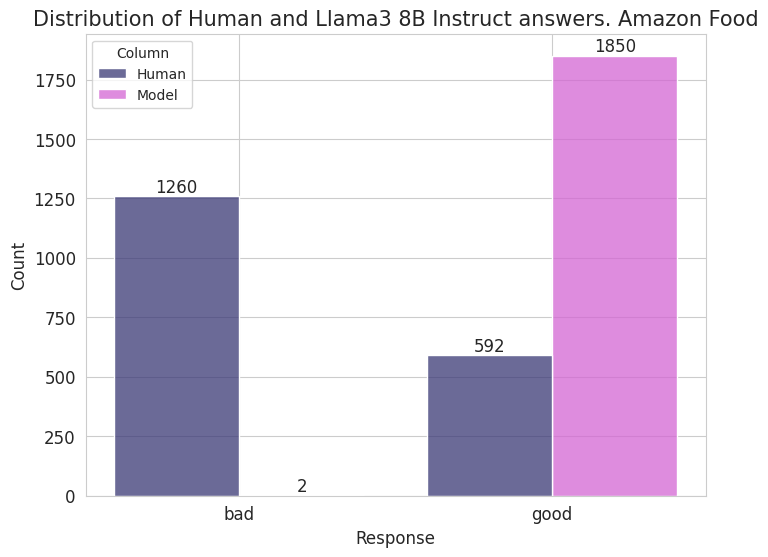

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_newsgroups_distrib_2classes.svg


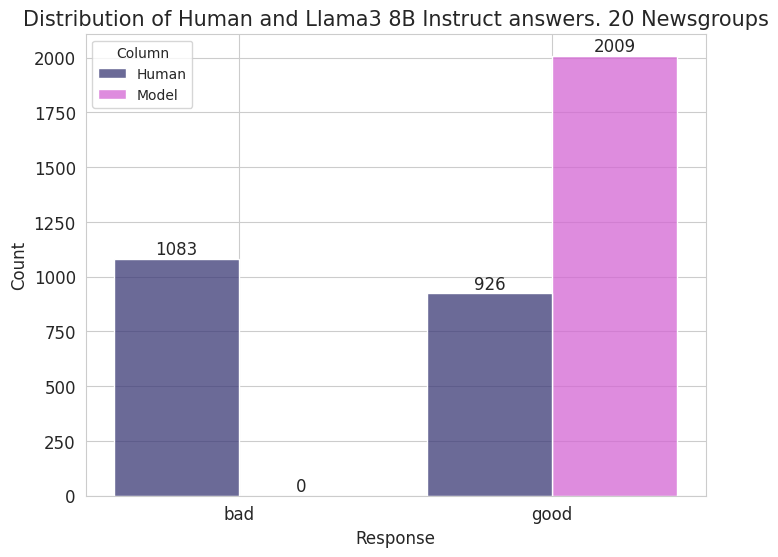

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_amazon_conf_matrix_2classes.png


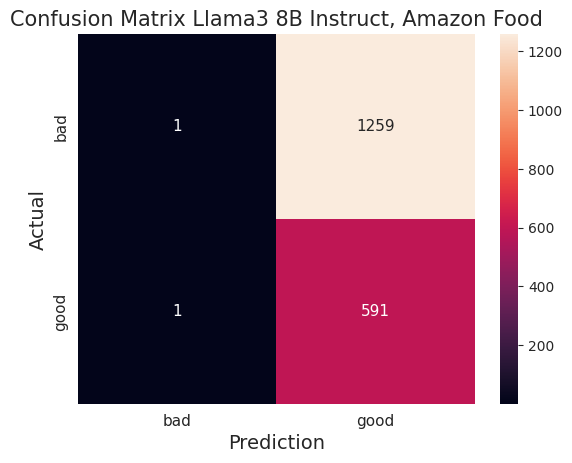

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_newsgroups_conf_matrix_2classes.png


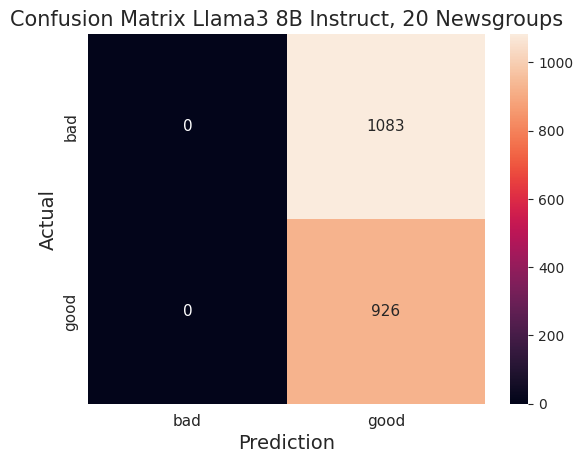

In [58]:
# Divide into two datasets
data_prompt_llama3_amazon = data_prompt_llama3[data_prompt_llama3["task"].isin(amazon_food_texts)]
data_prompt_llama3_newsgroups = data_prompt_llama3[data_prompt_llama3["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_llama3_amazon,
    model_name='Llama3 8B Instruct',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_amazon_distrib_2classes.svg'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_answers_distrib(
    data_prompt_llama3_newsgroups,
    model_name='Llama3 8B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_newsgroups_distrib_2classes.svg'),
    print_plot=True,
    num_class=2,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_llama3_amazon["true"]),
    np.array(data_prompt_llama3_amazon["model_extracted"]),
    model_name="Llama3 8B Instruct, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_amazon_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_llama3_newsgroups["true"]),
    np.array(data_prompt_llama3_newsgroups["model_extracted"]),
    model_name="Llama3 8B Instruct, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_newsgroups_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

In [59]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama3_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_amazon_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_llama3_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_newsgroups_metrices_2classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.319654  0.242807

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.460926  0.315503


#### Results of the Metrics

In [60]:
# Let's convert respondent's answers
data_prompt_llama3["true_num"] = [words_to_num(x) for x in data_prompt_llama3["true"]]

In [61]:
# Let's calculate metrics for model's answers
data_prompt_llama3["classification_metric"] = TmEval.classification_metric(data=data_prompt_llama3["model_extracted"], num_class=2)
data_prompt_llama3.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...   bad   
1  able amaze fill stop glad daily fantastic move...   bad   
2  able amaze fill stop glad daily fantastic move...   bad   
3  able amaze glad fill stop fantastic daily move...   bad   
4  absolute church truth doug scripture symbol li...  good   
5  absolute church truth mission nasa doug mars e...   bad   
6  absolute mission church nasa mars earth truth ...  good   
7  absolutely fast white rice service noodle terr...   bad   
8  absolutely fast white super service customer r...  good   
9  absolutely grain experience soon there's proce...   bad   

                                               model  model_extracted  \
0  YES TEXT: able amaze fill glad stop daily fant...                2   
1  YES TEXT: able amaze fill stop glad daily fant...                2   
2  YES TEXT: able amaze fill stop glad daily fant...                2   
3  YES TEXT: able amaze glad fill stop fantastic ...                2   
4  YES s>[INST]You are the assistant for text cla...                2   
5  YES s>[INST]You are the assistant for text cla...                2   
6  YES s>[INST]You are the assistant for text cla...                2   
7  YES s>[INST]You are the assistant for text cla...                2   
8  YES s>[INST]You are the assistant for text cla...                2   
9  YES s>[INST]You are the assistant for text cla...                2   

   true_num  classification_metric  
0        -2                      1  
1        -2                      1  
2        -2                      1  
3        -2                      1  
4         2                      1  
5        -2                      1  
6         2                      1  
7        -2                      1  
8         2                      1  
9        -2                      1

In [62]:
data_prompt_llama3.to_csv("llama3_classification_2.csv")

In [63]:
tmp_res_def = data_prompt_llama3[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_llama3_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_llama3_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama3_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_amazon_corr_2classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

# print("\nCorrelations for 20 Newsgroups")
# metrics_newsgoups = TmEval.calculate_metrics(
#     data=data_prompt_llama3_newsgroups,
#     save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_newsgroups_corr_2classes.csv'),
#     metric_flags=["phik", "lin_corr"]
# )
# print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
   phik   pearson accuracy f1_score
0   0.0 -0.012715        -        -


## Four classes

In [153]:
PROMPT_MISTRAL_1 = "text_coherence_mistral_7b_4_bit_4classes_APM4.csv"
PROMPT_MISTRAL_2 = "text_coherence_mistral_7b_4_bit_4classes_P1.csv"
PROMPT_MISTRAL_3 = "text_coherence_mistral_7b_4_bit_4classes_P2.csv"
PROMPT_LLAMA2 = "text_coherence_Llama2_13B_4_bit_4classes_P1.csv"
LORA_MISTRAL = "text_coherence_mistral_7B_4_class_LoRA_classification.csv"
PROMPT_LLAMA3 = "llama3_8B_4classes.csv"

DATA_INIT = "data_quality_estim_4classes.csv"

PROMPT_MISTRAL_1 = DATA_DIR.joinpath(PROMPT_MISTRAL_1)
PROMPT_MISTRAL_2 = DATA_DIR.joinpath(PROMPT_MISTRAL_2)
PROMPT_MISTRAL_3 = DATA_DIR.joinpath(PROMPT_MISTRAL_3)
PROMPT_LLAMA2 = DATA_DIR.joinpath(PROMPT_LLAMA2)
LORA_MISTRAL = DATA_DIR.joinpath(LORA_MISTRAL)
PROMPT_LLAMA3 = DATA_DIR.joinpath(PROMPT_LLAMA3)
INITIAL_FILE_DIR = BASE_DIR.joinpath('data/datasets')

data_prompt_mistral_1 = pd.read_csv(PROMPT_MISTRAL_1, sep="\t", names=["task", "true", "model"], header=None)
data_prompt_mistral_2 = pd.read_csv(PROMPT_MISTRAL_2, sep="\t", names=["task", "true", "model"], header=None)
data_prompt_mistral_3 = pd.read_csv(PROMPT_MISTRAL_3, sep=",", names=["task", "true", "model"], header=None)
data_prompt_llama2 = pd.read_csv(PROMPT_LLAMA2, sep="\t", names=["task", "true", "model"], header=None)
data_lora_mistral = pd.read_csv(LORA_MISTRAL, sep=",", index_col=0)
data_prompt_llama3 = pd.read_csv(PROMPT_LLAMA3, sep="\t", names=["task", "true", "model"])

In [154]:
# Initial Dataset

DATASETS_NAME = "data_quality_estim_4classes.csv"
DATASETS_DIR = BASE_DIR.joinpath('data/datasets')
DATASETS_NAME = DATASETS_DIR.joinpath(DATASETS_NAME)
data_initial = pd.read_csv(
    DATASETS_NAME, 
    sep=",", 
    header=0
)

data_initial.head(10)

task    agg_label
0  able amaze fill glad stop daily fantastic move...   rather_bad
1  able amaze fill stop glad daily fantastic move...   rather_bad
2  able amaze fill stop glad daily fantastic move...   rather_bad
3  able amaze glad fill stop fantastic daily move...          bad
4  absolute church truth doug scripture symbol li...  rather_good
5  absolute church truth mission nasa doug mars e...   rather_bad
6  absolute mission church nasa mars earth truth ...         good
7  absolutely fast white rice service noodle terr...   rather_bad
8  absolutely fast white super service customer r...         good
9  absolutely grain experience soon there's proce...          bad

### Baseline (Uniform Random Classifier)

In [66]:
np.random.seed(0)

data_initial = data_initial.rename(columns={"agg_label": "true"})

data_initial["model_extracted"] = [np.random.choice(["bad", "rather_bad", "rather_good", "good"]) for i in range(data_initial.shape[0])]
# data_initial["model_extracted"] = np.random.randint(2, size=data_initial.shape[0])
data_initial.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

  model_extracted  
0             bad  
1            good  
2      rather_bad  
3             bad  
4            good  
5            good  
6            good  
7            good  
8      rather_bad  
9            good

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_amazon_distrib_4classes.svg


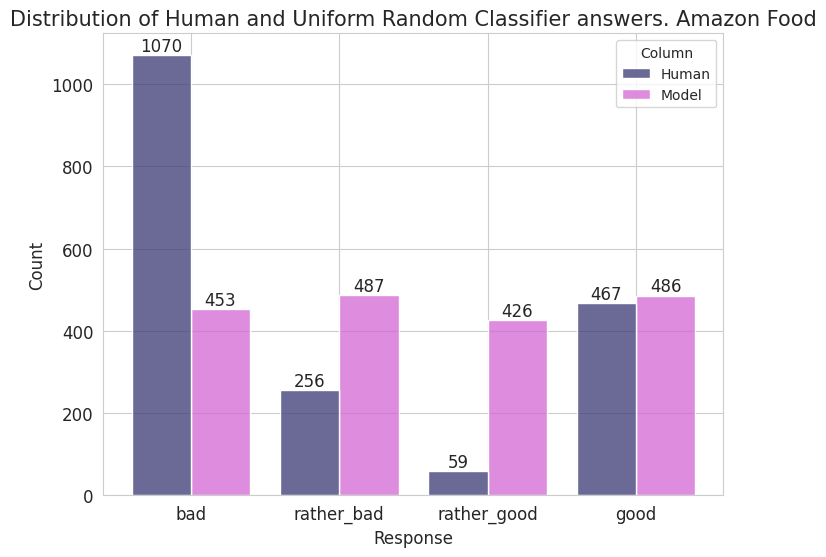

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_newsgroups_distrib_4classes.svg


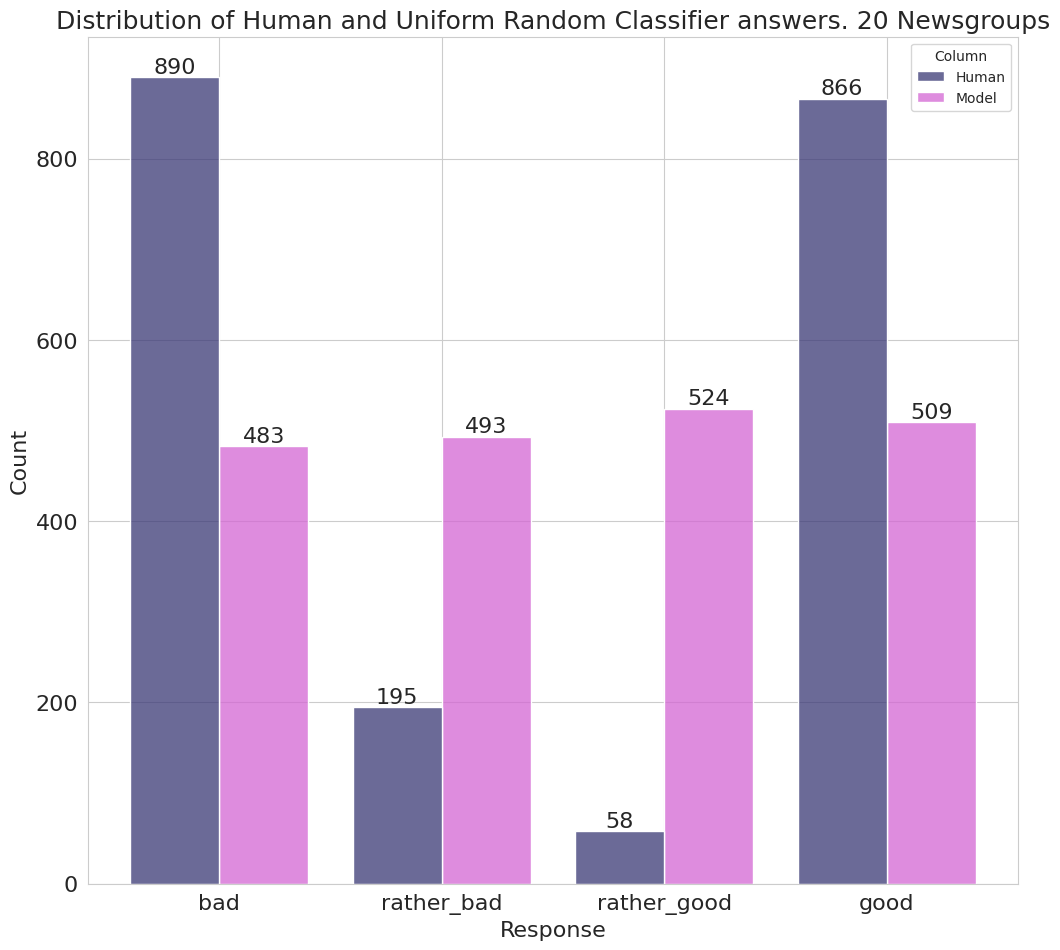

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_amazon_conf_matrix_4classes.png


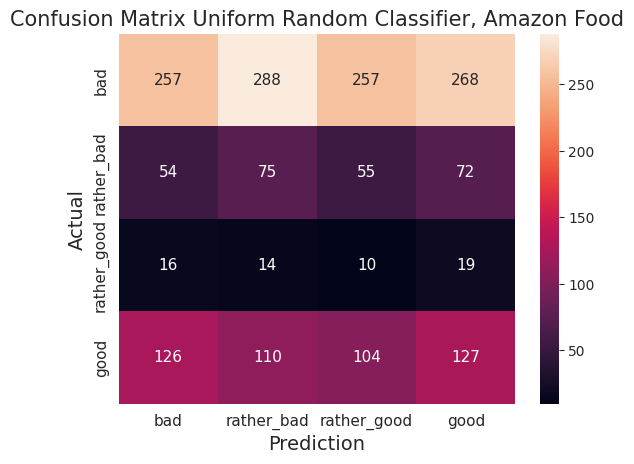

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_newsgroups_conf_matrix_4classes.png


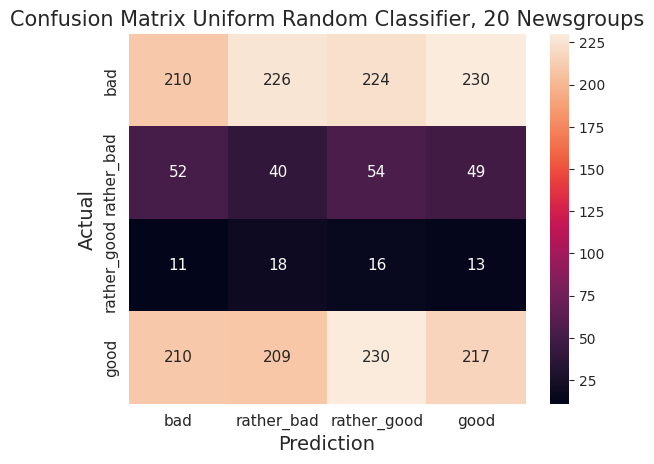

In [67]:
# Divide into two datasets
results_amazon = data_initial[data_initial["task"].isin(amazon_food_texts)]
results_newsgroups = data_initial[data_initial["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    results_amazon,
    model_name='Uniform Random Classifier',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_amazon_distrib_4classes.svg'),
    print_plot=True,
    num_class=4
    )

TmEval.plot_answers_distrib(
    results_newsgroups,
    model_name='Uniform Random Classifier',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_newsgroups_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    fig_size=(12, 11),
    title_size=18,
    ticks_size=16,
    label_size=16,
    container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(results_amazon["true"]),
    np.array(results_amazon["model_extracted"]),
    model_name="Uniform Random Classifier, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_amazon_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

TmEval.plot_conf_matrix(
    np.array(results_newsgroups["true"]),
    np.array(results_newsgroups["model_extracted"]),
    model_name="Uniform Random Classifier, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_newsgroups_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

In [68]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=results_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_amazon_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=results_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_newsgroups_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -   0.25324  0.211785

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.240418  0.198199


#### Results of the Metrics

In [69]:
# Let's convert respondent's answers
data_initial["true_num"] = [words_to_num(x) for x in data_initial["true"]]

In [70]:
data_initial

task         true  \
0     able amaze fill glad stop daily fantastic move...   rather_bad   
1     able amaze fill stop glad daily fantastic move...   rather_bad   
2     able amaze fill stop glad daily fantastic move...   rather_bad   
3     able amaze glad fill stop fantastic daily move...          bad   
4     absolute church truth doug scripture symbol li...  rather_good   
...                                                 ...          ...   
3856  year two size old every last month start since...          bad   
3857  year two size old every last month start week ...         good   
3858  year two size old last month every start week ...          bad   
3859  year work two every size old last month start ...          bad   
3860  year work two size old last month start long w...          bad   

     model_extracted  true_num  
0                bad        -1  
1               good        -1  
2         rather_bad        -1  
3                bad        -2  
4               good         1  
...              ...       ...  
3856      rather_bad        -2  
3857            good         2  
3858             bad        -2  
3859     rather_good        -2  
3860     rather_good        -2  

[3861 rows x 4 columns]

In [71]:
# Let's calculate metrics for model's answers
data_initial["model_extracted"] = [words_to_num(x) for x in data_initial["model_extracted"]]
data_initial["classification_metric"] = TmEval.classification_metric(data=data_initial["model_extracted"], num_class=4)
data_initial.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

   model_extracted  true_num  classification_metric  
0               -2        -1               0.000000  
1                2        -1               1.000000  
2               -1        -1               0.333333  
3               -2        -2               0.000000  
4                2         1               1.000000  
5                2        -1               1.000000  
6                2         2               1.000000  
7                2        -1               1.000000  
8               -1         2               0.333333  
9                2        -2               1.000000

In [72]:
data_initial.to_csv("URC_classification_4.csv")

In [73]:
tmp_res_def = data_initial[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
results_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
results_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=results_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_amazon_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=results_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_newsgroups_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
   phik   pearson accuracy f1_score
0   0.0 -0.001436        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
   phik   pearson accuracy f1_score
0   0.0 -0.002703        -        -


### Mistral TYPE I (Article modified prompt)
You are a helpful assistant evaluating the top words of a topic model output for a given topic. 
You will recieve a list of words. Please rate the following words on a scale from 0 to 3 by answering on the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Use the criteria: '0' when words seem to be unconnected, '1' if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, '2' if some words are too common or out of topic, '3' if words have a strong connection between them. Print the answer in the form: Answer: [rating]. Print only answer without explanation.

In [94]:
data_prompt_mistral_1.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  
0                                     Answer: 1.</s>  
1                                     Answer: 1.</s>  
2                                     Answer: 1.</s>  
3                                     Answer: 1.</s>  
4                                     Answer: 1.</s>  
5                                     Answer: 1.</s>  
6   Answer: 3.  These words have a strong connect...  
7   Answer: 2.  Some words like "absolutely," "te...  
8                                     Answer: 1.</s>  
9                                     Answer: 1.</s>

In [95]:
# Results postprocessing
data_prompt_mistral_1 = TmEval.postprocess_results(
    data_prompt_mistral_1, 
    num_class=4, 
    answer_type="number"
    )

class_labels = {
    0: 'bad',
    1: 'rather_bad',
    2: 'rather_good',
    3: 'good'
}

data_prompt_mistral_1["model_extracted"] = [class_labels[x] for x in data_prompt_mistral_1["model_extracted"]]


In [96]:
data_prompt_mistral_1.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model model_extracted  
0                                     Answer: 1.</s>      rather_bad  
1                                     Answer: 1.</s>      rather_bad  
2                                     Answer: 1.</s>      rather_bad  
3                                     Answer: 1.</s>      rather_bad  
4                                     Answer: 1.</s>      rather_bad  
5                                     Answer: 1.</s>      rather_bad  
6   Answer: 3.  These words have a strong connect...            good  
7   Answer: 2.  Some words like "absolutely," "te...     rather_good  
8                                     Answer: 1.</s>      rather_bad  
9                                     Answer: 1.</s>      rather_bad

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_amazon_distrib_4classes.svg


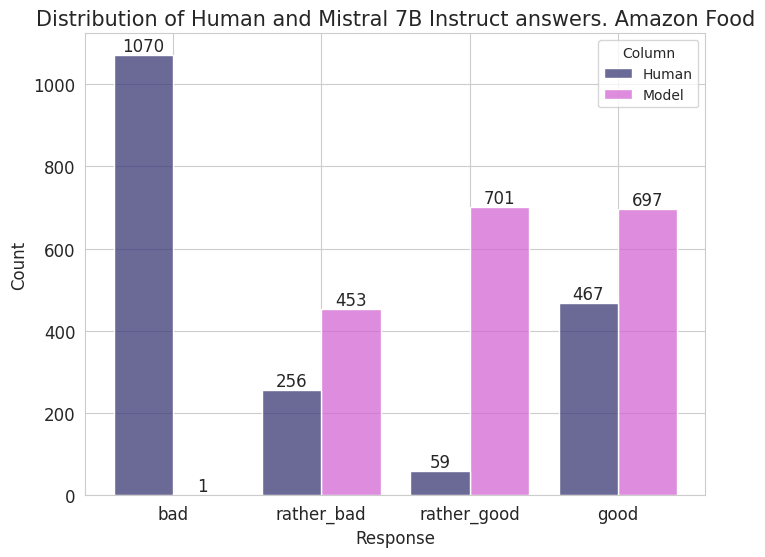

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_newsgroups_distrib_4classes.svg


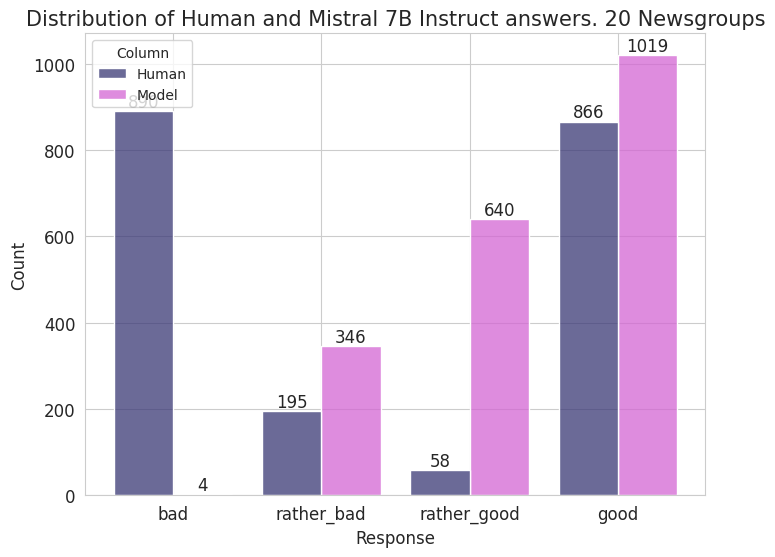

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_amazon_conf_matrix_4classes.png


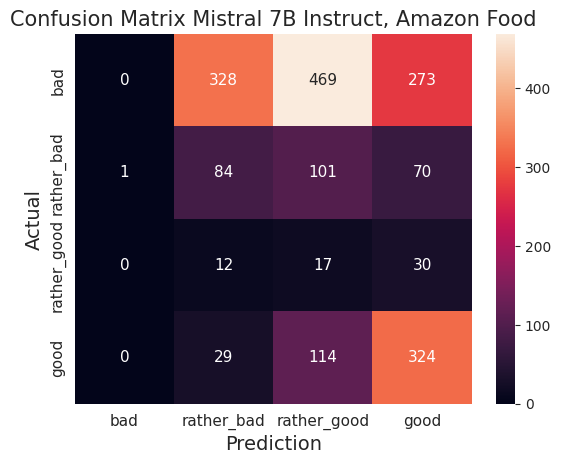

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_newsgroups_conf_matrix_4classes.png


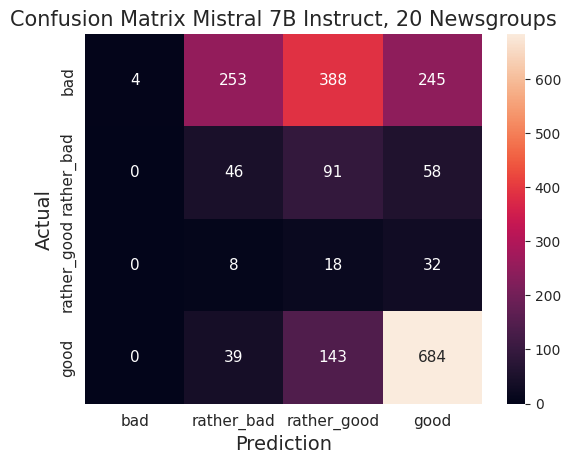

In [97]:
# Divide into two datasets
data_prompt_mistral_1_amazon = data_prompt_mistral_1[data_prompt_mistral_1["task"].isin(amazon_food_texts)]
data_prompt_mistral_1_newsgroups = data_prompt_mistral_1[data_prompt_mistral_1["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_mistral_1_amazon,
    model_name='Mistral 7B Instruct',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_amazon_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    )

TmEval.plot_answers_distrib(
    data_prompt_mistral_1_newsgroups,
    model_name='Mistral 7B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_newsgroups_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )



# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_1_amazon["true"]),
    np.array(data_prompt_mistral_1_amazon["model_extracted"]),
    model_name="Mistral 7B Instruct, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_amazon_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_1_newsgroups["true"]),
    np.array(data_prompt_mistral_1_newsgroups["model_extracted"]),
    model_name="Mistral 7B Instruct, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_newsgroups_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

In [98]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_1_amazon_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_1_newsgroups_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.229482  0.209598

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.374316  0.239077


#### Results of the Metrics

In [99]:
# Let's convert respondent's answers
data_prompt_mistral_1["true_num"] = [words_to_num(x) for x in data_prompt_mistral_1["true"]]

In [100]:
data_prompt_mistral_1["model_extracted"] = [words_to_num(x) for x in data_prompt_mistral_1["model_extracted"]]

In [101]:
# Let's calculate metrics for model's answers
data_prompt_mistral_1["classification_metric"] = TmEval.classification_metric(data=data_prompt_mistral_1["model_extracted"], num_class=4)
data_prompt_mistral_1.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  model_extracted  \
0                                     Answer: 1.</s>               -1   
1                                     Answer: 1.</s>               -1   
2                                     Answer: 1.</s>               -1   
3                                     Answer: 1.</s>               -1   
4                                     Answer: 1.</s>               -1   
5                                     Answer: 1.</s>               -1   
6   Answer: 3.  These words have a strong connect...                2   
7   Answer: 2.  Some words like "absolutely," "te...                1   
8                                     Answer: 1.</s>               -1   
9                                     Answer: 1.</s>               -1   

   true_num  classification_metric  
0        -1               0.333333  
1        -1               0.333333  
2        -1               0.333333  
3        -2               0.333333  
4         1               0.333333  
5        -1               0.333333  
6         2               1.000000  
7        -1               0.666667  
8         2               0.333333  
9        -2               0.333333

In [102]:
data_prompt_mistral_1.to_csv("mistral1_classification_4.csv")

In [103]:
tmp_res_def = data_prompt_mistral_1[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_mistral_1_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_mistral_1_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_1_amazon_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_1_newsgroups_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']


       phik   pearson accuracy f1_score
0  0.532902  0.372609        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.631562  0.480604        -        -


### Mistral TYPE II
You are a useful assistant who evaluates the coherence of words. 

You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.

Classification rules:

yes - if words have a strong connection between them

rather yes - if some words are too common or out of topic

rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics

no - when words seem to be unconnected.

Print only class without explanation and additional information.

In [104]:
data_prompt_mistral_2.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  
0                                     rather no.</s>  
1                                     rather no.</s>  
2                                     rather no.</s>  
3                                     rather no.</s>  
4                                     rather no.</s>  
5                                     rather no.</s>  
6   rather yes. The words have some connection to...  
7     rather yes. The words can be generally grouped  
8                                     rather no.</s>  
9               rather yes. Some words like "grain,"

In [105]:
# Results postprocessing
data_prompt_mistral_2 = TmEval.postprocess_results(
    data_prompt_mistral_2, 
    num_class=4, 
    answer_type="word"
    )

data_prompt_mistral_2.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  model_extracted  
0                                     rather no.</s>               -1  
1                                     rather no.</s>               -1  
2                                     rather no.</s>               -1  
3                                     rather no.</s>               -1  
4                                     rather no.</s>               -1  
5                                     rather no.</s>               -1  
6   rather yes. The words have some connection to...                1  
7     rather yes. The words can be generally grouped                1  
8                                     rather no.</s>               -1  
9               rather yes. Some words like "grain,"                1

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_amazon_distrib_4classes.svg


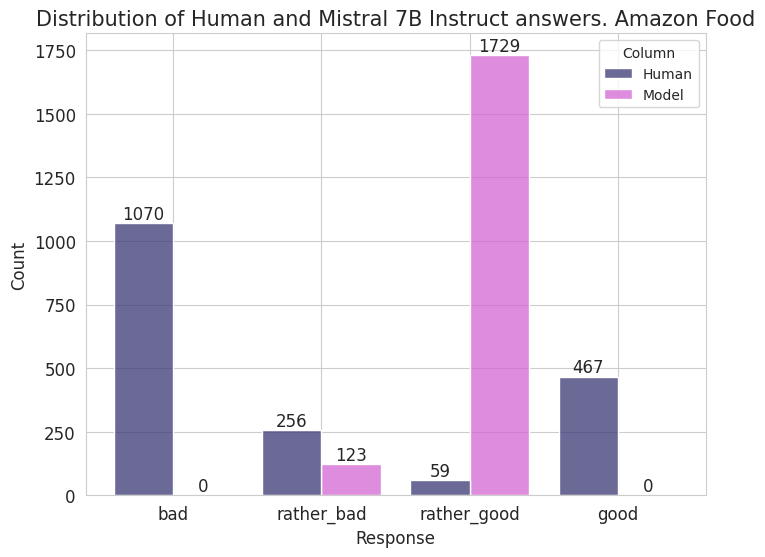

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_newsgroups_distrib_4classes.svg


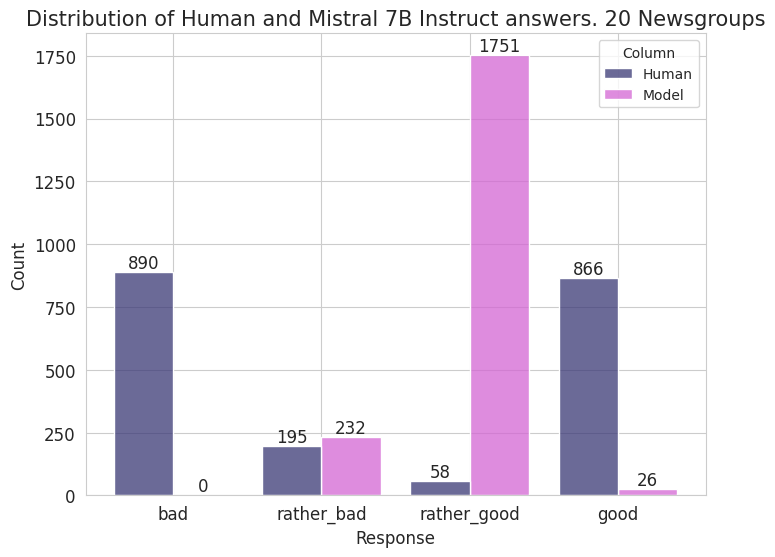

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_amazon_conf_matrix_4classes.png


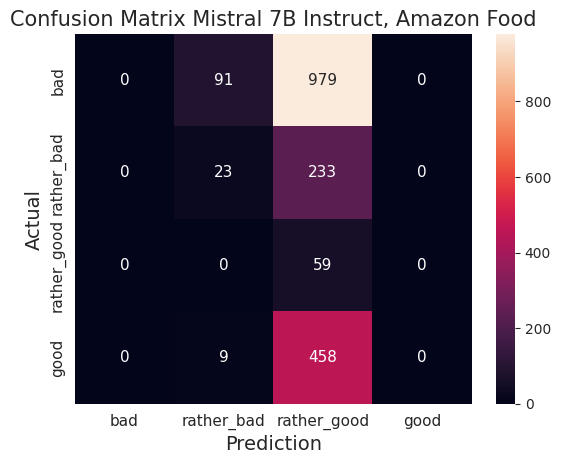

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_newsgroups_conf_matrix_4classes.png


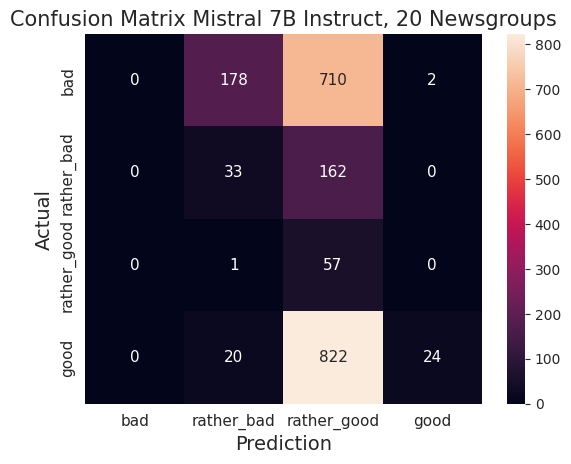

In [106]:
# Divide into two datasets
data_prompt_mistral_2_amazon = data_prompt_mistral_2[data_prompt_mistral_2["task"].isin(amazon_food_texts)]
data_prompt_mistral_2_newsgroups = data_prompt_mistral_2[data_prompt_mistral_2["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_mistral_2_amazon,
    model_name='Mistral 7B Instruct',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_amazon_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    )

TmEval.plot_answers_distrib(
    data_prompt_mistral_2_newsgroups,
    model_name='Mistral 7B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_newsgroups_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )



# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_2_amazon["true"]),
    np.array(data_prompt_mistral_2_amazon["model_extracted"]),
    model_name="Mistral 7B Instruct, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_amazon_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_2_newsgroups["true"]),
    np.array(data_prompt_mistral_2_newsgroups["model_extracted"]),
    model_name="Mistral 7B Instruct, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_newsgroups_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

In [107]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_2_amazon_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_2_newsgroups_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.044276  0.046842

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.056745  0.067849


#### Results of the Metrics

In [108]:
# Let's convert respondent's answers
data_prompt_mistral_2["true_num"] = [words_to_num(x) for x in data_prompt_mistral_2["true"]]

In [109]:
# Let's calculate metrics for model's answers
data_prompt_mistral_2["classification_metric"] = TmEval.classification_metric(data=data_prompt_mistral_2["model_extracted"], num_class=4)
data_prompt_mistral_2.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  model_extracted  \
0                                     rather no.</s>               -1   
1                                     rather no.</s>               -1   
2                                     rather no.</s>               -1   
3                                     rather no.</s>               -1   
4                                     rather no.</s>               -1   
5                                     rather no.</s>               -1   
6   rather yes. The words have some connection to...                1   
7     rather yes. The words can be generally grouped                1   
8                                     rather no.</s>               -1   
9               rather yes. Some words like "grain,"                1   

   true_num  classification_metric  
0        -1               0.333333  
1        -1               0.333333  
2        -1               0.333333  
3        -2               0.333333  
4         1               0.333333  
5        -1               0.333333  
6         2               0.666667  
7        -1               0.666667  
8         2               0.333333  
9        -2               0.666667

In [110]:
data_prompt_mistral_2.to_csv('mistral2_classification_4.csv')

In [111]:
tmp_res_def = data_prompt_mistral_2[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_mistral_2_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_mistral_2_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_21_amazon_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_2_newsgroups_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']


       phik   pearson accuracy f1_score
0  0.179458  0.119142        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.210864  0.284456        -        -


### Mistral TYPE III
You are a useful assistant who evaluates the coherence of words. 

You will receive a list of words, please determine which class the given list of words belongs to. Print only class without explanation and additional information.


Classification rules:

yes - if words have a strong connection between them 

rather yes - if some words are too common or out of topic

rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics

no - when words seem to be unconnected

In [112]:
data_prompt_mistral_3.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                           model  
0                                 rather no.</s>  
1                                 rather no.</s>  
2                                 rather no.</s>  
3                                 rather no.</s>  
4                                 rather no.</s>  
5                                 rather no.</s>  
6  rather yes. The list contains a mix of topics  
7                                 rather yes</s>  
8                                 rather yes</s>  
9                                 rather yes</s>

In [113]:
# Results postprocessing
data_prompt_mistral_3 = TmEval.postprocess_results(
    data_prompt_mistral_3, 
    num_class=4, 
    answer_type="word"
    )

data_prompt_mistral_3.head(10)

The number of samples in the results dataset with 'None' extracted answer: 1
Wordset: period boston player pittsburgh score dave third detroit chicago baseball toronto pitch yankee louis murray
Model answer: baseball</s>
Extracted answer: nan


task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                           model  model_extracted  
0                                 rather no.</s>             -1.0  
1                                 rather no.</s>             -1.0  
2                                 rather no.</s>             -1.0  
3                                 rather no.</s>             -1.0  
4                                 rather no.</s>             -1.0  
5                                 rather no.</s>             -1.0  
6  rather yes. The list contains a mix of topics              1.0  
7                                 rather yes</s>              1.0  
8                                 rather yes</s>              1.0  
9                                 rather yes</s>              1.0

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_3_amazon_distrib_4classes.svg


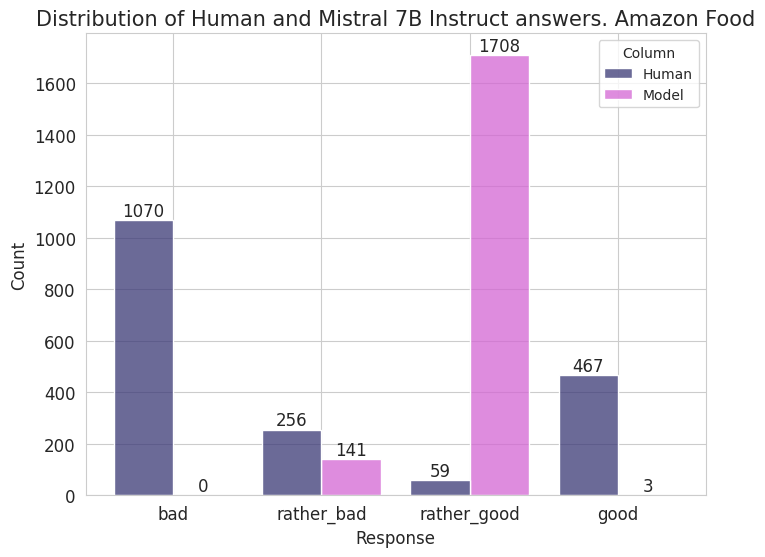

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_3_newsgroups_distrib_4classes.svg


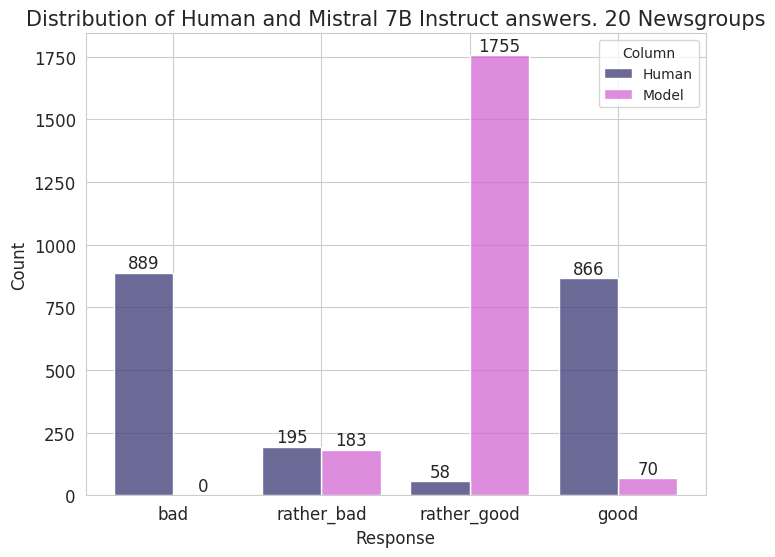

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_3_amazon_conf_matrix_4classes.png


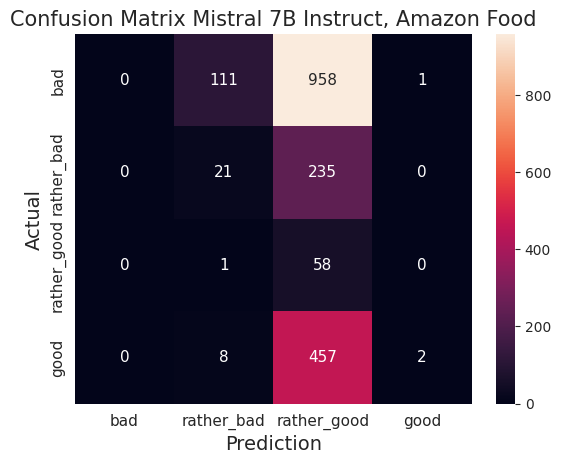

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_3_newsgroups_conf_matrix_4classes.png


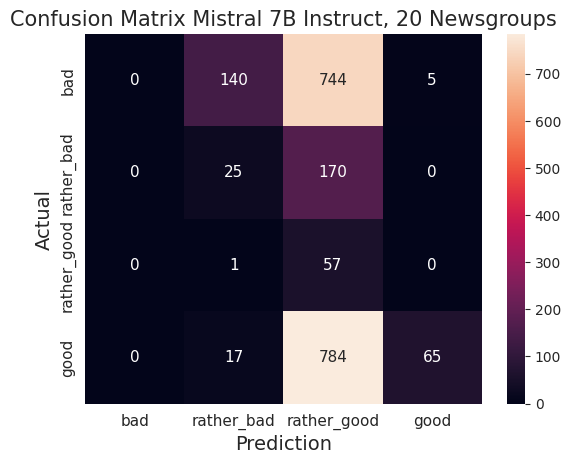

In [114]:
# Divide into two datasets
data_prompt_mistral_3_amazon = data_prompt_mistral_3[data_prompt_mistral_3["task"].isin(amazon_food_texts)]
data_prompt_mistral_3_newsgroups = data_prompt_mistral_3[data_prompt_mistral_3["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_mistral_3_amazon,
    model_name='Mistral 7B Instruct',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_3_amazon_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    )

TmEval.plot_answers_distrib(
    data_prompt_mistral_3_newsgroups,
    model_name='Mistral 7B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_3_newsgroups_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )



# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_3_amazon["true"]),
    np.array(data_prompt_mistral_3_amazon["model_extracted"]),
    model_name="Mistral 7B Instruct, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_3_amazon_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_3_newsgroups["true"]),
    np.array(data_prompt_mistral_3_newsgroups["model_extracted"]),
    model_name="Mistral 7B Instruct, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_3_newsgroups_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

In [115]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_3_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_3_amazon_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_3_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_3_newsgroups_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.043737  0.044988

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.073207  0.083511


#### Results of the Metrics

In [116]:
# Let's convert respondent's answers
data_prompt_mistral_3["true_num"] = [words_to_num(x) for x in data_prompt_mistral_3["true"]]

In [117]:
# Let's calculate metrics for model's answers
data_prompt_mistral_3["classification_metric"] = TmEval.classification_metric(data=data_prompt_mistral_3["model_extracted"], num_class=4)
data_prompt_mistral_3.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                           model  model_extracted  true_num  \
0                                 rather no.</s>             -1.0        -1   
1                                 rather no.</s>             -1.0        -1   
2                                 rather no.</s>             -1.0        -1   
3                                 rather no.</s>             -1.0        -2   
4                                 rather no.</s>             -1.0         1   
5                                 rather no.</s>             -1.0        -1   
6  rather yes. The list contains a mix of topics              1.0         2   
7                                 rather yes</s>              1.0        -1   
8                                 rather yes</s>              1.0         2   
9                                 rather yes</s>              1.0        -2   

   classification_metric  
0               0.333333  
1               0.333333  
2               0.333333  
3               0.333333  
4               0.333333  
5               0.333333  
6               0.666667  
7               0.666667  
8               0.666667  
9               0.666667

In [118]:
data_prompt_mistral_3.to_csv("mistral3_classification_4.csv")

In [119]:
tmp_res_def = data_prompt_mistral_3[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_mistral_3_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_mistral_3_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_3_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_3_amazon_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_3_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_3_newsgroups_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
      phik   pearson accuracy f1_score
0  0.10236  0.145284        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.213825  0.283826        -        -


### Llama2 Type I
You are a useful assistant who evaluates the coherence of words.

You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.

Classification rules:\nyes - if words have a strong connection between them

rather yes - if some words are too common or out of topic

rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics

no - when words seem to be unconnected

neutral - if it is hard for you to answer on the question.\nPrint only class without explanation and additional information.

In [129]:
data_prompt_llama2.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  
0    Sure! Here's the classification of the given...  
1    Sure! Here's the classification of the given...  
2    Sure! Here's the classification of the given...  
3    Sure! Here's the classification of the given...  
4    Sure! Here's the classification of the given...  
5    Sure! Here's the classification of the given...  
6    Sure! Here's the classification of the given...  
7    Sure! Here's the classification of the given...  
8    Sure! Here's the classification of the given...  
9    Sure! Here's the classification of the given...

In [132]:
data_prompt_llama2["true"] = [data_initial[data_initial["task"]==llama_text]["agg_label"].item() for llama_text in data_prompt_llama2["task"]]

In [133]:
# Results postprocessing
data_prompt_llama2 = TmEval.postprocess_results(
    data_prompt_llama2, 
    num_class=4, 
    answer_type="word"
    )

data_prompt_llama2.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  model_extracted  
0    Sure! Here's the classification of the given...                1  
1    Sure! Here's the classification of the given...                1  
2    Sure! Here's the classification of the given...                1  
3    Sure! Here's the classification of the given...                1  
4    Sure! Here's the classification of the given...               -1  
5    Sure! Here's the classification of the given...               -1  
6    Sure! Here's the classification of the given...                1  
7    Sure! Here's the classification of the given...                1  
8    Sure! Here's the classification of the given...               -1  
9    Sure! Here's the classification of the given...                1

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_amazon_distrib_4classes.svg


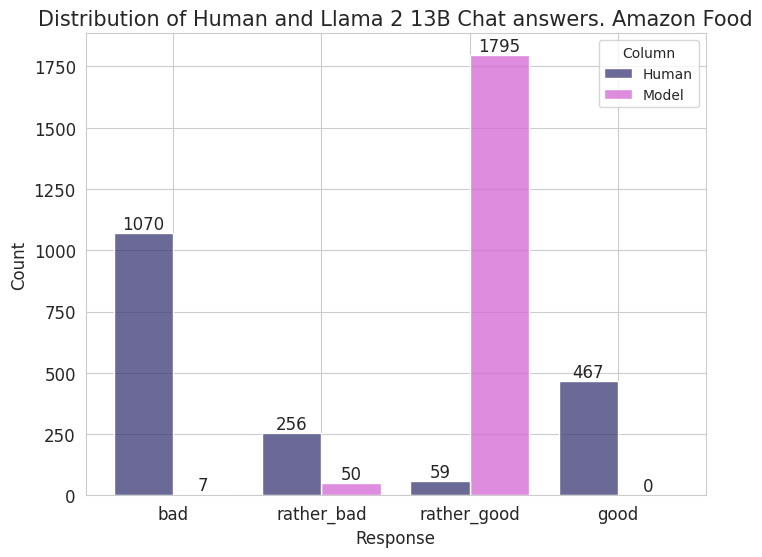

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_newsgroups_distrib_4classes.svg


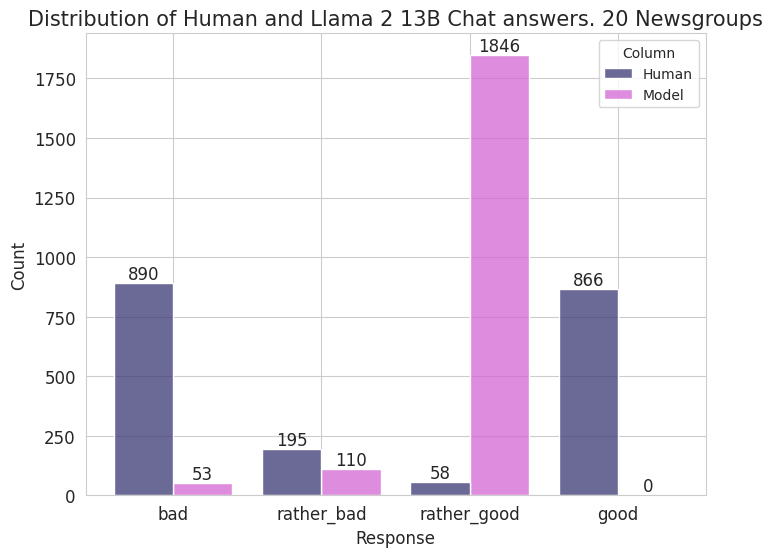

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_amazon_conf_matrix_4classes.png


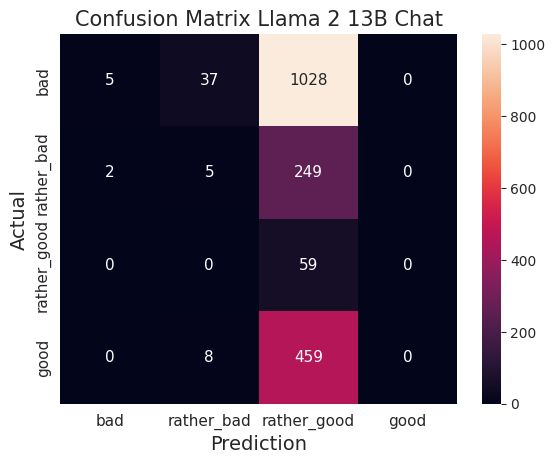

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_newsgroups_conf_matrix_4classes.png


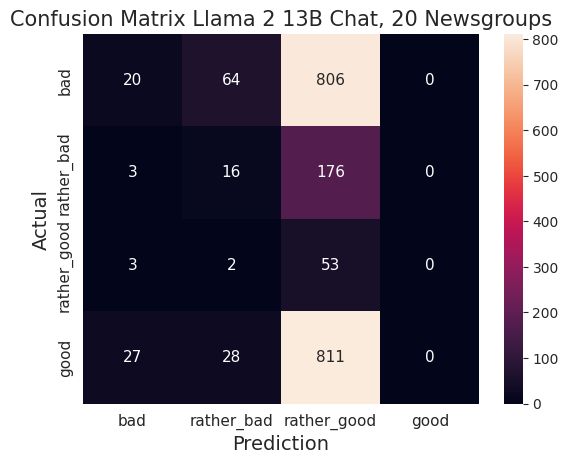

In [134]:
# Divide into two datasets
data_prompt_llama2_amazon = data_prompt_llama2[data_prompt_llama2["task"].isin(amazon_food_texts)]
data_prompt_llama2_newsgroups = data_prompt_llama2[data_prompt_llama2["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_llama2_amazon,
    model_name='Llama 2 13B Chat',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_amazon_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    )

TmEval.plot_answers_distrib(
    data_prompt_llama2_newsgroups,
    model_name='Llama 2 13B Chat',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_newsgroups_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_llama2_amazon["true"]),
    np.array(data_prompt_llama2_amazon["model_extracted"]),
    model_name="Llama 2 13B Chat",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_amazon_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_llama2_newsgroups["true"]),
    np.array(data_prompt_llama2_newsgroups["model_extracted"]),
    model_name="Llama 2 13B Chat, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_newsgroups_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

In [135]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_amazon_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_llama2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_newsgroups_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.037257  0.026403

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.044301  0.050752


#### Results of the Metrics

In [136]:
# Let's convert respondent's answers
data_prompt_llama2["true_num"] = [words_to_num(x) for x in data_prompt_llama2["true"]]

In [137]:
# Let's calculate metrics for model's answers
data_prompt_llama2["classification_metric"] = TmEval.classification_metric(data=data_prompt_llama2["model_extracted"], num_class=4)
data_prompt_llama2.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  model_extracted  \
0    Sure! Here's the classification of the given...                1   
1    Sure! Here's the classification of the given...                1   
2    Sure! Here's the classification of the given...                1   
3    Sure! Here's the classification of the given...                1   
4    Sure! Here's the classification of the given...               -1   
5    Sure! Here's the classification of the given...               -1   
6    Sure! Here's the classification of the given...                1   
7    Sure! Here's the classification of the given...                1   
8    Sure! Here's the classification of the given...               -1   
9    Sure! Here's the classification of the given...                1   

   true_num  classification_metric  
0        -1               0.666667  
1        -1               0.666667  
2        -1               0.666667  
3        -2               0.666667  
4         1               0.333333  
5        -1               0.333333  
6         2               0.666667  
7        -1               0.666667  
8         2               0.333333  
9        -2               0.666667

In [138]:
data_prompt_llama2.to_csv('llama2_1_classification_4.csv')

In [139]:
tmp_res_def = data_prompt_llama2[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_llama2_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_llama2_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_amazon_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_llama2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_newsgroups_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.033299  0.060206        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.062574  0.025876        -        -


### LoRA Mistral (without system prompt)
r = 16
epochs = 20

In [155]:
data_lora_mistral.head(10)

Human Model                                            wordset
0   rather_bad   bad  able amaze fill glad stop daily fantastic move...
1   rather_bad   bad  able amaze fill stop glad daily fantastic move...
2   rather_bad   bad  able amaze fill stop glad daily fantastic move...
3          bad   bad  able amaze glad fill stop fantastic daily move...
4  rather_good   bad  absolute church truth doug scripture symbol li...
5   rather_bad   bad  absolute church truth mission nasa doug mars e...
6         good  good  absolute mission church nasa mars earth truth ...
7   rather_bad   bad  absolutely fast white rice service noodle terr...
8         good   bad  absolutely fast white super service customer r...
9          bad   bad  absolutely grain experience soon there's proce...

In [156]:
data_lora_mistral.rename(
    {
        "Human": "true",
        "Model": "model_extracted",
        "wordset": "task"
    },
    inplace=True,
    axis=1
)

In [157]:
classes_map = {
    "bad": -2,
    "rather_bad": -1,
    "rather_good": 1,
    "good": 2
}

data_lora_mistral["true"] = [classes_map[x] for x in data_lora_mistral["true"]]
data_lora_mistral["model_extracted"] = [classes_map[x] for x in data_lora_mistral["model_extracted"]]

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_amazon_distrib_4classes.svg


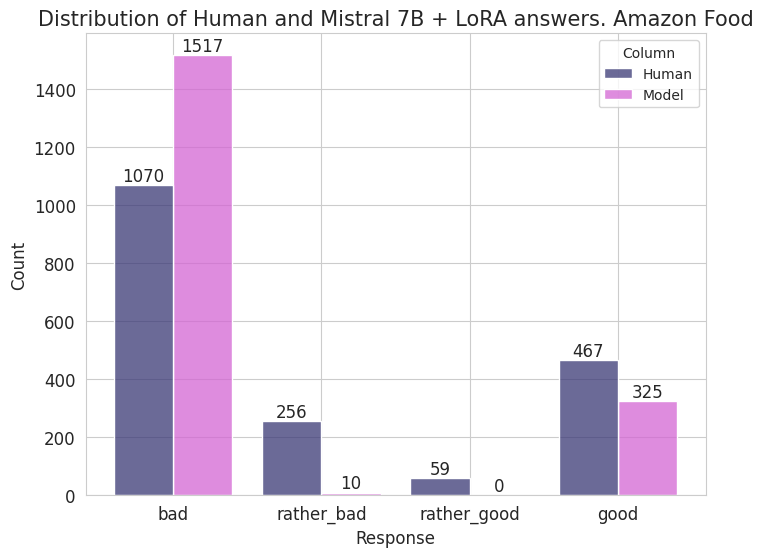

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_newsgroups_distrib_4classes.svg


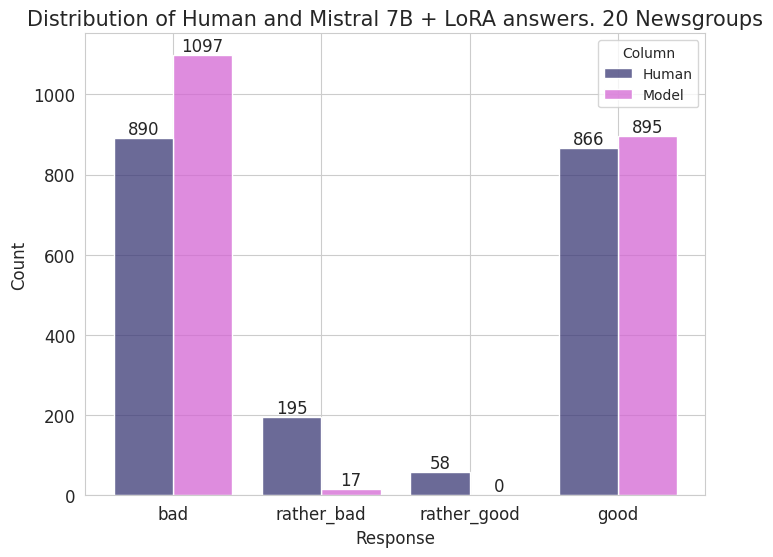

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_amazon_conf_matrix_4classes.png


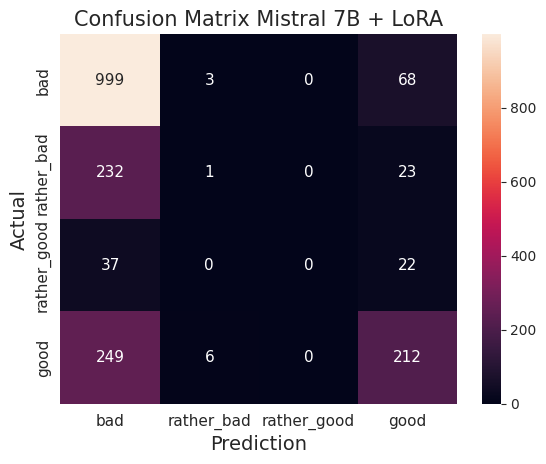

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_newsgroups_conf_matrix_4classes.png


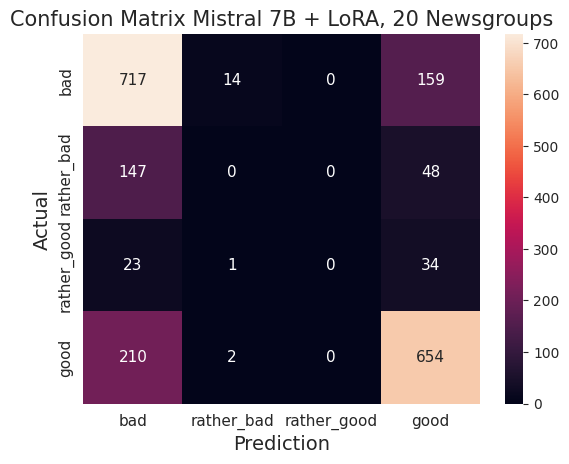

In [158]:
# Divide into two datasets
data_lora_mistral_amazon = data_lora_mistral[data_lora_mistral["task"].isin(amazon_food_texts)]
data_lora_mistral_newsgroups = data_lora_mistral[data_lora_mistral["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_lora_mistral_amazon,
    model_name='Mistral 7B + LoRA',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_amazon_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    )

TmEval.plot_answers_distrib(
    data_lora_mistral_newsgroups,
    model_name='Mistral 7B + LoRA',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_newsgroups_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_lora_mistral_amazon["true"]),
    np.array(data_lora_mistral_amazon["model_extracted"]),
    model_name="Mistral 7B + LoRA",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_amazon_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

TmEval.plot_conf_matrix(
    np.array(data_lora_mistral_newsgroups["true"]),
    np.array(data_lora_mistral_newsgroups["model_extracted"]),
    model_name="Mistral 7B + LoRA, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_newsgroups_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

In [159]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_lora_mistral_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/lora_mistral_amazon_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_lora_mistral_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/lora_mistral_newsgroups_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.654428  0.328799

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.682429  0.366113


#### Results of the Metrics

In [160]:
# Let's convert respondent's answers
data_prompt_mistral_lora["true_num"] = [words_to_num(x) for x in data_prompt_mistral_lora["true"]]

In [161]:
data_prompt_mistral_lora

true  model_extracted  \
0      bad               -2   
1      bad               -2   
2      bad               -2   
3      bad               -2   
4     good               -2   
...    ...              ...   
3856   bad               -2   
3857  good               -2   
3858   bad               -2   
3859   bad               -2   
3860   bad               -2   

                                                   task  true_num  \
0     able amaze fill glad stop daily fantastic move...        -2   
1     able amaze fill stop glad daily fantastic move...        -2   
2     able amaze fill stop glad daily fantastic move...        -2   
3     able amaze glad fill stop fantastic daily move...        -2   
4     absolute church truth doug scripture symbol li...         2   
...                                                 ...       ...   
3856  year two size old every last month start since...        -2   
3857  year two size old every last month start week ...         2   
3858  year two size old last month every start week ...        -2   
3859  year work two every size old last month start ...        -2   
3860  year work two size old last month start long w...        -2   

      classification_metric  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
...                     ...  
3856                      0  
3857                      0  
3858                      0  
3859                      0  
3860                      0  

[3861 rows x 5 columns]

In [162]:
# Let's calculate metrics for model's answers
# data_prompt_mistral_lora["model_extracted"] = [words_to_num(x) for x in data_prompt_mistral_lora["model_extracted"]]
data_prompt_mistral_lora["classification_metric"] = TmEval.classification_metric(data=data_prompt_mistral_lora["model_extracted"], num_class=4)
data_prompt_mistral_lora.head(10)

true  model_extracted                                               task  \
0   bad               -2  able amaze fill glad stop daily fantastic move...   
1   bad               -2  able amaze fill stop glad daily fantastic move...   
2   bad               -2  able amaze fill stop glad daily fantastic move...   
3   bad               -2  able amaze glad fill stop fantastic daily move...   
4  good               -2  absolute church truth doug scripture symbol li...   
5   bad                2  absolute church truth mission nasa doug mars e...   
6  good               -2  absolute mission church nasa mars earth truth ...   
7   bad               -2  absolutely fast white rice service noodle terr...   
8  good               -2  absolutely fast white super service customer r...   
9   bad               -2  absolutely grain experience soon there's proce...   

   true_num  classification_metric  
0        -2                      0  
1        -2                      0  
2        -2                      0  
3        -2                      0  
4         2                      0  
5        -2                      1  
6         2                      0  
7        -2                      0  
8         2                      0  
9        -2                      0

In [163]:
data_prompt_mistral_lora.to_csv("mistral_lora_classification_4.csv")

In [164]:
tmp_res_def = data_prompt_mistral_lora[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_mistral_lora_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_mistral_lora_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_lora_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_lora_amazon_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_lora_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_lora_newsgroups_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.673337  0.472255        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.779208  0.570076        -        -


### Llama3-8B Instruct
You are the assistant for text classification. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Classification rules:yes - if words have a strong connection between them; rather yes - if some words are too common or out of topic; rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics; no - when words seem to be unconnected. Print only class without explanation and additional information.

In [165]:
data_prompt_llama3.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  
0  no [INST]You are the assistant for text classi...  
1  no[/INST] s>[INST]You are the assistant for te...  
2  no [INST]You are the assistant for text classi...  
3  rather no s>[INST]You are the assistant for te...  
4  no [INST]You are the assistant for text classi...  
5  no [INST]You are the assistant for text classi...  
6  no [INST]You are the assistant for text classi...  
7  no s>[INST]You are the assistant for text clas...  
8  no [INST]You are the assistant for text classi...  
9  no [INST]You are the assistant for text classi...

In [166]:
# Results postprocessing
data_prompt_llama3 = TmEval.postprocess_results(
    data_prompt_llama3, 
    num_class=4, 
    answer_type="word"
    )

data_prompt_llama3.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  model_extracted  
0  no [INST]You are the assistant for text classi...               -2  
1  no[/INST] s>[INST]You are the assistant for te...               -2  
2  no [INST]You are the assistant for text classi...               -2  
3  rather no s>[INST]You are the assistant for te...               -1  
4  no [INST]You are the assistant for text classi...               -2  
5  no [INST]You are the assistant for text classi...               -2  
6  no [INST]You are the assistant for text classi...               -2  
7  no s>[INST]You are the assistant for text clas...               -2  
8  no [INST]You are the assistant for text classi...               -2  
9  no [INST]You are the assistant for text classi...               -2

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_amazon_distrib_4classes.svg


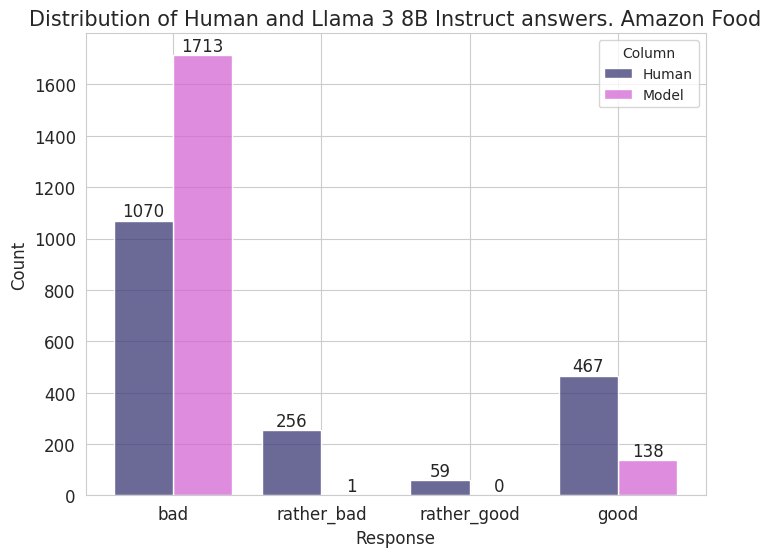

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_newsgroups_distrib_4classes.svg


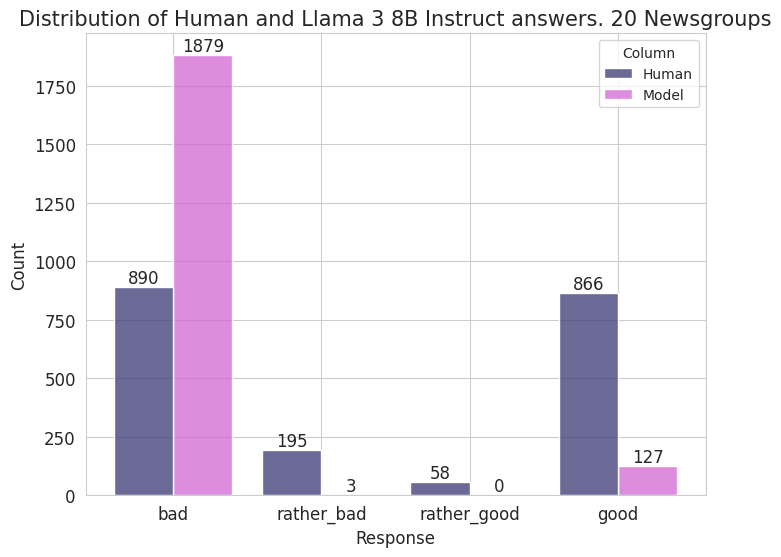

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_amazon_conf_matrix_4classes.png


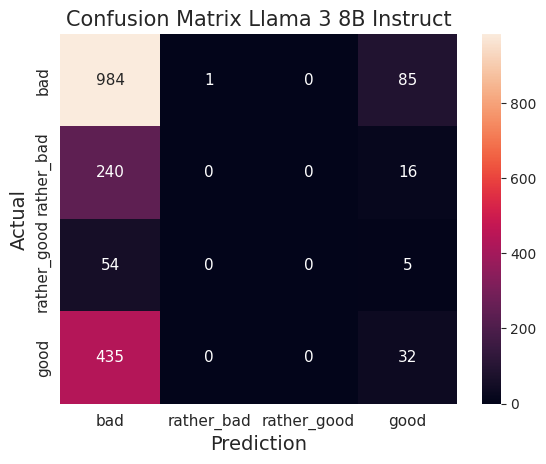

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_newsgroups_conf_matrix_4classes.png


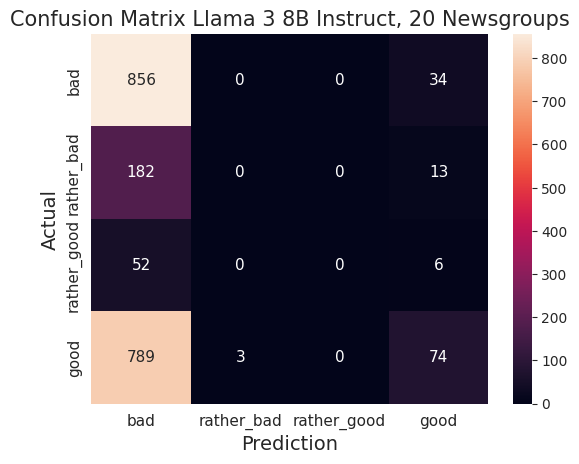

In [167]:
# Divide into two datasets
data_prompt_llama3_amazon = data_prompt_llama3[data_prompt_llama3["task"].isin(amazon_food_texts)]
data_prompt_llama3_newsgroups = data_prompt_llama3[data_prompt_llama3["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_llama3_amazon,
    model_name='Llama 3 8B Instruct',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_amazon_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    )

TmEval.plot_answers_distrib(
    data_prompt_llama3_newsgroups,
    model_name='Llama 3 8B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_newsgroups_distrib_4classes.svg'),
    print_plot=True,
    num_class=4,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_llama3_amazon["true"]),
    np.array(data_prompt_llama3_amazon["model_extracted"]),
    model_name="Llama 3 8B Instruct",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_amazon_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_llama3_newsgroups["true"]),
    np.array(data_prompt_llama3_newsgroups["model_extracted"]),
    model_name="Llama 3 8B Instruct, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_newsgroups_conf_matrix_4classes.png'),
    print_plot=True,
    num_class=4
    )

In [168]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama3_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_amazon_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_llama3_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_newsgroups_metrices_4classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.548596  0.203234

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.462917  0.191829


#### Results of the Metrics

In [169]:
# Let's convert respondent's answers
data_prompt_llama3["true_num"] = [words_to_num(x) for x in data_prompt_llama3["true"]]

In [170]:
# Let's calculate metrics for model's answers
data_prompt_llama3["classification_metric"] = TmEval.classification_metric(data=data_prompt_llama3["model_extracted"], num_class=4)
data_prompt_llama3.head(10)

task         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  model_extracted  \
0  no [INST]You are the assistant for text classi...               -2   
1  no[/INST] s>[INST]You are the assistant for te...               -2   
2  no [INST]You are the assistant for text classi...               -2   
3  rather no s>[INST]You are the assistant for te...               -1   
4  no [INST]You are the assistant for text classi...               -2   
5  no [INST]You are the assistant for text classi...               -2   
6  no [INST]You are the assistant for text classi...               -2   
7  no s>[INST]You are the assistant for text clas...               -2   
8  no [INST]You are the assistant for text classi...               -2   
9  no [INST]You are the assistant for text classi...               -2   

   true_num  classification_metric  
0        -1               0.000000  
1        -1               0.000000  
2        -1               0.000000  
3        -2               0.333333  
4         1               0.000000  
5        -1               0.000000  
6         2               0.000000  
7        -1               0.000000  
8         2               0.000000  
9        -2               0.000000

In [171]:
data_prompt_llama3.to_csv("llama3_classification_4.csv")

In [172]:
tmp_res_def = data_prompt_llama3[["task", "true_num", "classification_metric"]].rename(columns={"true_num": "true", "classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_llama3_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_llama3_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama3_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_amazon_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_llama3_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_newsgroups_corr_4classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']


   phik   pearson accuracy f1_score
0   0.0 -0.015495        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.067837  0.093302        -        -


## Five Classes

In [173]:
PROMPT_MISTRAL_1 = "text_coherence_mistral_7b_4_bit_5classes_P1.csv"
PROMPT_MISTRAL_2 = "text_coherence_mistral_7b_4_bit_5classes_P2.csv"
PROMPT_LLAMA2 = "text_coherence_Llama2_13B_4_bit_5classes_P1.csv"
LORA_MISTRAL = "text_coherence_mistral_7B_LoRA_5classification.csv"
PROMPT_LLAMA3 = "llama3_8B_5classes.csv"
INITIAL = "words_consistensy_wordset_dataset_agg.csv"

PROMPT_MISTRAL_1 = DATA_DIR.joinpath(PROMPT_MISTRAL_1)
PROMPT_MISTRAL_2 = DATA_DIR.joinpath(PROMPT_MISTRAL_2)
PROMPT_LLAMA2 = DATA_DIR.joinpath(PROMPT_LLAMA2)
LORA_MISTRAL = DATA_DIR.joinpath(LORA_MISTRAL)
PROMPT_LLAMA3 = DATA_DIR.joinpath(PROMPT_LLAMA3)

INITIAL_FILE_DIR = BASE_DIR.joinpath('data/datasets')
INITIAL_DATA = INITIAL_FILE_DIR.joinpath(INITIAL)

data_prompt_mistral_1 = pd.read_csv(PROMPT_MISTRAL_1, sep="\t", names=["task", "true", "model"], header=None)
data_prompt_mistral_2 = pd.read_csv(PROMPT_MISTRAL_2, sep="\t", names=["task", "true", "model"], header=None)
data_prompt_llama2 = pd.read_csv(PROMPT_LLAMA2, sep="\t", names=["task", "true", "model"], header=None)
data_prompt_llama3 = pd.read_csv(PROMPT_LLAMA3, sep="\t", names=["task", "true", "model"], header=None)
data_lora_mistral = pd.read_csv(LORA_MISTRAL, sep=",", index_col=0)

data_initial = pd.read_csv(INITIAL_DATA, sep=',')

### Baseline (Uniform Random Classifier)

In [174]:
data_initial.head(10)

INPUT:wordset INPUT:dataset_name  \
0  able amaze fill glad stop daily fantastic move...        amazon_food   
1  able amaze fill stop glad daily fantastic move...        amazon_food   
2  able amaze fill stop glad daily fantastic move...        amazon_food   
3  able amaze glad fill stop fantastic daily move...        amazon_food   
4  absolute church truth doug scripture symbol li...       20newsgroups   
5  absolute church truth mission nasa doug mars e...       20newsgroups   
6  absolute mission church nasa mars earth truth ...       20newsgroups   
7  absolutely fast white rice service noodle terr...        amazon_food   
8  absolutely fast white super service customer r...        amazon_food   
9  absolutely grain experience soon there's proce...        amazon_food   

                                      OUTPUT:quality  homogenity  assessment  
0                ['rather_bad', 'bad', 'rather_bad']         0.7          -1  
1  ['bad', 'rather_good', 'rather_bad', 'rather_b...         0.5          -1  
2                ['bad', 'rather_bad', 'rather_bad']         0.7          -1  
3                              ['bad', 'bad', 'bad']         1.0          -2  
4  ['rather_good', 'bad', 'bad', 'rather_good', '...         0.6           1  
5  ['rather_bad', 'rather_bad', 'bad', 'rather_ba...         0.8          -1  
6            ['good', 'good', 'bad', 'good', 'good']         0.8           2  
7  ['rather_bad', 'bad', 'rather_bad', 'good', 'b...         0.5          -1  
8  ['bad', 'good', 'rather_good', 'rather_good', ...         0.4           2  
9                       ['bad', 'bad', 'rather_bad']         0.7          -2

In [175]:
np.random.seed(0)
data_initial["model_extracted"] = [np.random.choice(["bad", "rather_bad", "neutral", "rather_good", "good"]) for i in range(data_initial.shape[0])]
data_initial.head(10)

INPUT:wordset INPUT:dataset_name  \
0  able amaze fill glad stop daily fantastic move...        amazon_food   
1  able amaze fill stop glad daily fantastic move...        amazon_food   
2  able amaze fill stop glad daily fantastic move...        amazon_food   
3  able amaze glad fill stop fantastic daily move...        amazon_food   
4  absolute church truth doug scripture symbol li...       20newsgroups   
5  absolute church truth mission nasa doug mars e...       20newsgroups   
6  absolute mission church nasa mars earth truth ...       20newsgroups   
7  absolutely fast white rice service noodle terr...        amazon_food   
8  absolutely fast white super service customer r...        amazon_food   
9  absolutely grain experience soon there's proce...        amazon_food   

                                      OUTPUT:quality  homogenity  assessment  \
0                ['rather_bad', 'bad', 'rather_bad']         0.7          -1   
1  ['bad', 'rather_good', 'rather_bad', 'rather_b...         0.5          -1   
2                ['bad', 'rather_bad', 'rather_bad']         0.7          -1   
3                              ['bad', 'bad', 'bad']         1.0          -2   
4  ['rather_good', 'bad', 'bad', 'rather_good', '...         0.6           1   
5  ['rather_bad', 'rather_bad', 'bad', 'rather_ba...         0.8          -1   
6            ['good', 'good', 'bad', 'good', 'good']         0.8           2   
7  ['rather_bad', 'bad', 'rather_bad', 'good', 'b...         0.5          -1   
8  ['bad', 'good', 'rather_good', 'rather_good', ...         0.4           2   
9                       ['bad', 'bad', 'rather_bad']         0.7          -2   

  model_extracted  
0            good  
1             bad  
2     rather_good  
3     rather_good  
4     rather_good  
5      rather_bad  
6     rather_good  
7         neutral  
8            good  
9             bad

In [176]:
data_initial.rename(
    {
        "INPUT:wordset": "task",
        "assessment": "true"
    },
    inplace=True,
    axis=1
)

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_amazon_distrib_5classes.svg


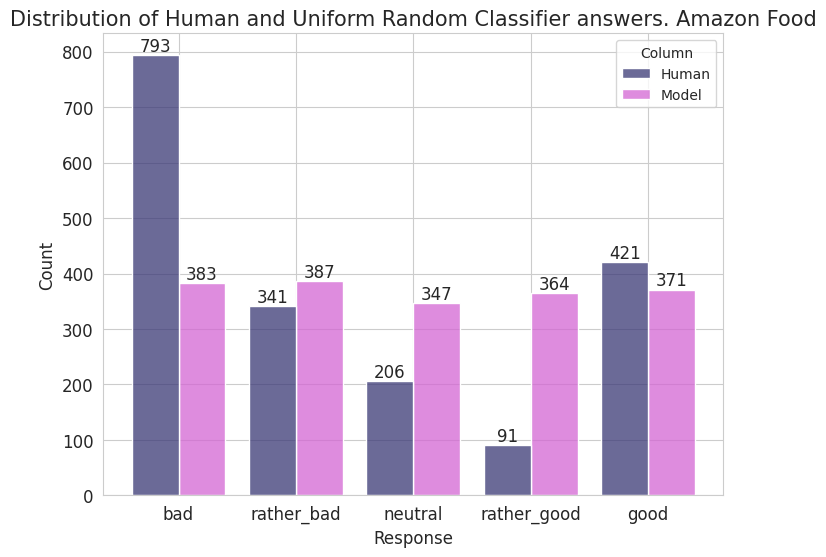

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_newsgroups_distrib_5classes.svg


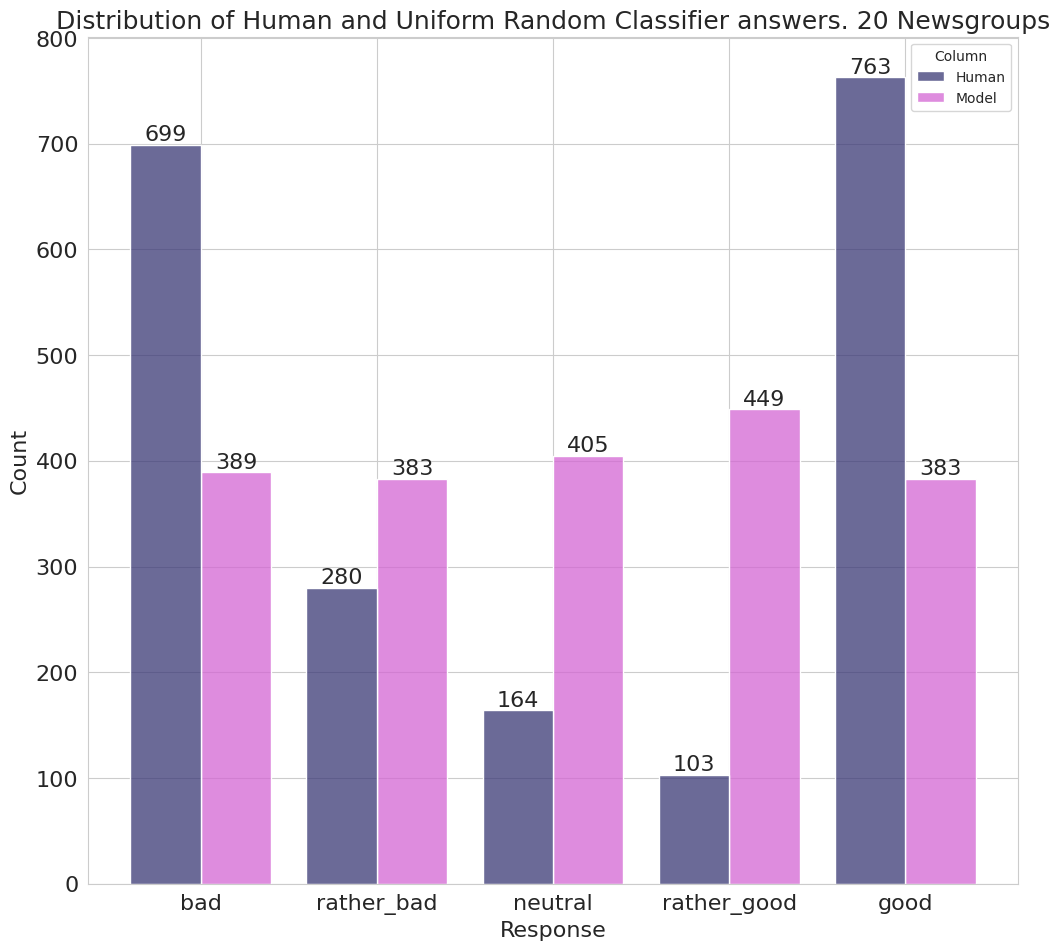

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_amazon_conf_matrix_5classes.png


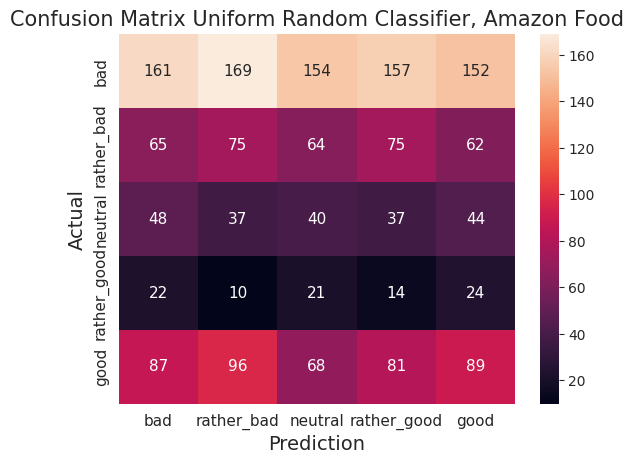

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/baseline_newsgroups_conf_matrix_5classes.png


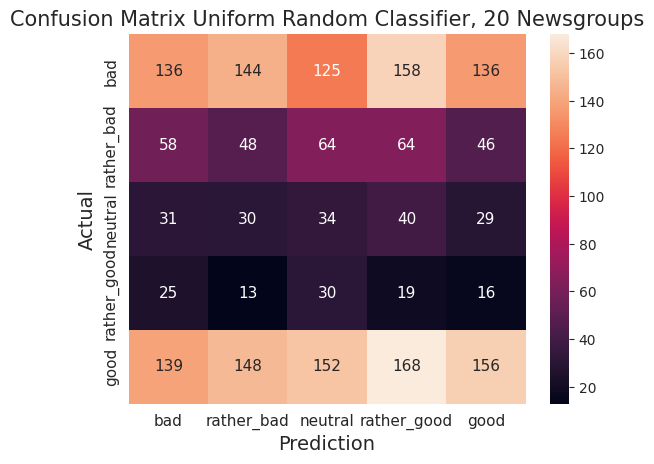

In [177]:
# Divide into two datasets
results_amazon = data_initial[data_initial["task"].isin(amazon_food_texts)]
results_newsgroups = data_initial[data_initial["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    results_amazon,
    model_name='Uniform Random Classifier',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_amazon_distrib_5classes.svg'),
    print_plot=True,
    num_class=5
    )

TmEval.plot_answers_distrib(
    results_newsgroups,
    model_name='Uniform Random Classifier',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_newsgroups_distrib_5classes.svg'),
    print_plot=True,
    num_class=5,
    fig_size=(12, 11),
    title_size=18,
    ticks_size=16,
    label_size=16,
    container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(results_amazon["true"]),
    np.array(results_amazon["model_extracted"]),
    model_name="Uniform Random Classifier, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_amazon_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    )

TmEval.plot_conf_matrix(
    np.array(results_newsgroups["true"]),
    np.array(results_newsgroups["model_extracted"]),
    model_name="Uniform Random Classifier, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/baseline_newsgroups_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    )

In [179]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=results_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_amazon_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=results_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_newsgroups_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.204644  0.182161

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -   0.19562  0.171079


#### Results of the Metrics

In [180]:
data_initial

task INPUT:dataset_name  \
0     able amaze fill glad stop daily fantastic move...        amazon_food   
1     able amaze fill stop glad daily fantastic move...        amazon_food   
2     able amaze fill stop glad daily fantastic move...        amazon_food   
3     able amaze glad fill stop fantastic daily move...        amazon_food   
4     absolute church truth doug scripture symbol li...       20newsgroups   
...                                                 ...                ...   
3856  year two size old every last month start since...        amazon_food   
3857  year two size old every last month start week ...        amazon_food   
3858  year two size old last month every start week ...        amazon_food   
3859  year work two every size old last month start ...        amazon_food   
3860  year work two size old last month start long w...        amazon_food   

                                         OUTPUT:quality  homogenity  true  \
0                   ['rather_bad', 'bad', 'rather_bad']         0.7    -1   
1     ['bad', 'rather_good', 'rather_bad', 'rather_b...         0.5    -1   
2                   ['bad', 'rather_bad', 'rather_bad']         0.7    -1   
3                                 ['bad', 'bad', 'bad']         1.0    -2   
4     ['rather_good', 'bad', 'bad', 'rather_good', '...         0.6     1   
...                                                 ...         ...   ...   
3856                      ['bad', 'rather_bad', 'good']         0.3    -1   
3857  ['good', 'rather_good', 'good', 'bad', 'rather...         0.5     2   
3858                      ['bad', 'good', 'rather_bad']         0.3     0   
3859                       ['bad', 'rather_bad', 'bad']         0.7    -2   
3860                              ['bad', 'bad', 'bad']         1.0    -2   

     model_extracted  
0               good  
1                bad  
2        rather_good  
3        rather_good  
4        rather_good  
...              ...  
3856      rather_bad  
3857            good  
3858            good  
3859         neutral  
3860      rather_bad  

[3861 rows x 6 columns]

In [181]:
# Let's calculate metrics for model's answers
data_initial["model_extracted"] = [words_to_num(x) for x in data_initial["model_extracted"]]
data_initial["classification_metric"] = TmEval.classification_metric(data=data_initial["model_extracted"], num_class=5)
data_initial.head(10)

task INPUT:dataset_name  \
0  able amaze fill glad stop daily fantastic move...        amazon_food   
1  able amaze fill stop glad daily fantastic move...        amazon_food   
2  able amaze fill stop glad daily fantastic move...        amazon_food   
3  able amaze glad fill stop fantastic daily move...        amazon_food   
4  absolute church truth doug scripture symbol li...       20newsgroups   
5  absolute church truth mission nasa doug mars e...       20newsgroups   
6  absolute mission church nasa mars earth truth ...       20newsgroups   
7  absolutely fast white rice service noodle terr...        amazon_food   
8  absolutely fast white super service customer r...        amazon_food   
9  absolutely grain experience soon there's proce...        amazon_food   

                                      OUTPUT:quality  homogenity  true  \
0                ['rather_bad', 'bad', 'rather_bad']         0.7    -1   
1  ['bad', 'rather_good', 'rather_bad', 'rather_b...         0.5    -1   
2                ['bad', 'rather_bad', 'rather_bad']         0.7    -1   
3                              ['bad', 'bad', 'bad']         1.0    -2   
4  ['rather_good', 'bad', 'bad', 'rather_good', '...         0.6     1   
5  ['rather_bad', 'rather_bad', 'bad', 'rather_ba...         0.8    -1   
6            ['good', 'good', 'bad', 'good', 'good']         0.8     2   
7  ['rather_bad', 'bad', 'rather_bad', 'good', 'b...         0.5    -1   
8  ['bad', 'good', 'rather_good', 'rather_good', ...         0.4     2   
9                       ['bad', 'bad', 'rather_bad']         0.7    -2   

   model_extracted  classification_metric  
0                2                   1.00  
1               -2                   0.00  
2                1                   0.75  
3                1                   0.75  
4                1                   0.75  
5               -1                   0.25  
6                1                   0.75  
7                0                   0.50  
8                2                   1.00  
9               -2                   0.00

In [182]:
data_initial.to_csv("URC_classification_5.csv")

In [183]:
tmp_res_def = data_initial[["task", "true", "classification_metric"]].rename(columns={"classification_metric": "model_extracted"})

# Divide into two datasets
results_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
results_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=results_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_amazon_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=results_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/baseline_newsgroups_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
   phik   pearson accuracy f1_score
0   0.0  0.006328        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.022582  0.015649        -        -


### Mistral TYPE I
You are a helpful assistant evaluating the top words of a topic model output for a given topic. 

You will recieve a list of words. Please rate the following words on a scale from -2 to 2 by answering on the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Use the criteria: '-2' when words seem to be unconnected, '-1' if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, '1' if some words are too common or out of topic, '2' if words have a strong connection between them, '0' if it's hard for you to answer on the question. Print the answer in the form: Answer: [rating]. Print only answer without explanation.

In [184]:
data_prompt_mistral_1.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                           model  
0      Answer: 0.  This word set  
1      Answer: 0.  This word set  
2      Answer: 0.  This word set  
3      Answer: 0.  This word set  
4                 Answer: 0.</s>  
5      Answer: 0.  This word set  
6   Answer: 2.  These words have  
7                 Answer: 1.</s>  
8                Answer: -1.</s>  
9      Answer: 0.  This word set

In [185]:
# Results postprocessing
data_prompt_mistral_1 = TmEval.postprocess_results(
    data_prompt_mistral_1, 
    num_class=5, 
    answer_type="number"
    )

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_amazon_distrib_5classes.svg


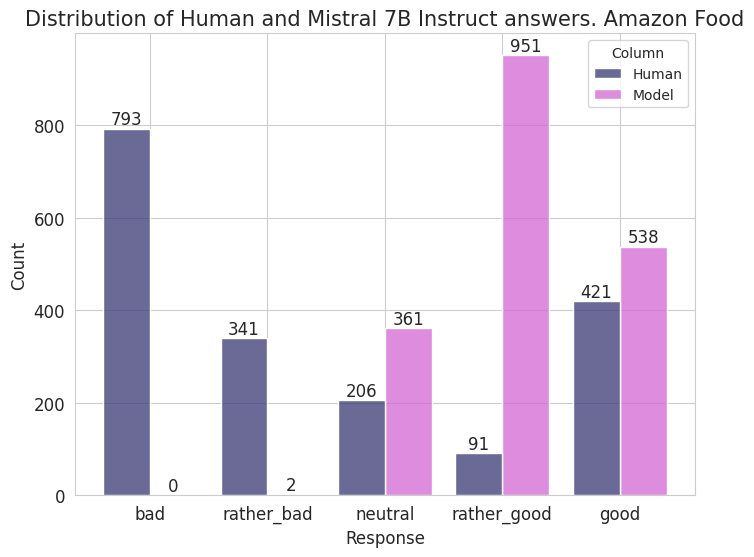

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_newsgroups_distrib_5classes.svg


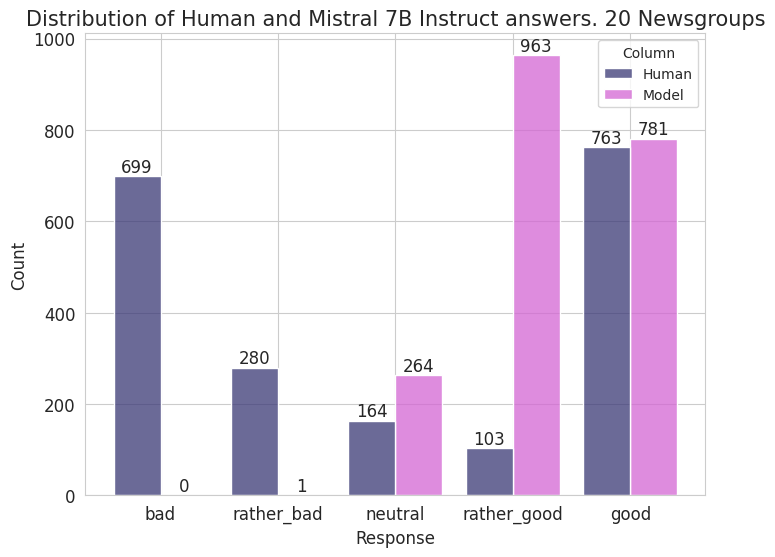

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_amazon_conf_matrix_5classes.png


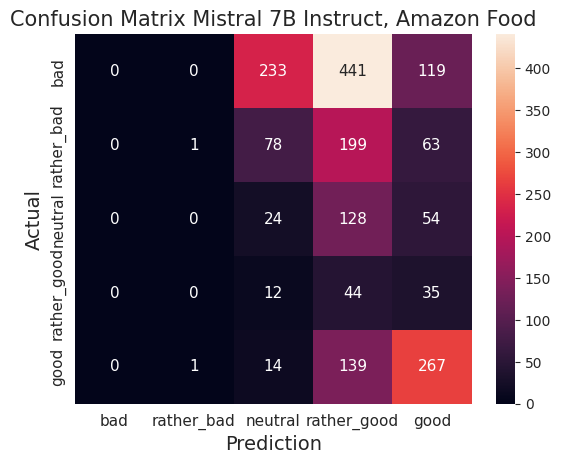

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_1_newsgroups_conf_matrix_5classes.png


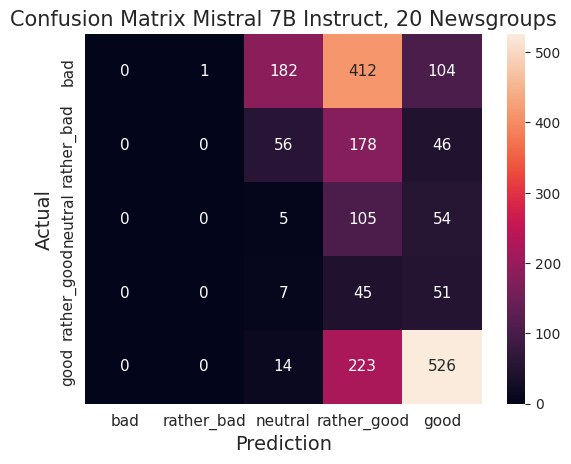

In [186]:
# Divide into two datasets
data_prompt_mistral_1_amazon = data_prompt_mistral_1[data_prompt_mistral_1["task"].isin(amazon_food_texts)]
data_prompt_mistral_1_newsgroups = data_prompt_mistral_1[data_prompt_mistral_1["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_mistral_1_amazon,
    model_name='Mistral 7B Instruct',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_amazon_distrib_5classes.svg'),
    print_plot=True,
    num_class=5,
    )

TmEval.plot_answers_distrib(
    data_prompt_mistral_1_newsgroups,
    model_name='Mistral 7B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_newsgroups_distrib_5classes.svg'),
    print_plot=True,
    num_class=5,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )



# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_1_amazon["true"]),
    np.array(data_prompt_mistral_1_amazon["model_extracted"]),
    model_name="Mistral 7B Instruct, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_amazon_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_1_newsgroups["true"]),
    np.array(data_prompt_mistral_1_newsgroups["model_extracted"]),
    model_name="Mistral 7B Instruct, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_1_newsgroups_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    )

In [187]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_1_amazon_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_1_newsgroups_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.181425  0.146354

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -   0.28671  0.157828


#### Results of the Metrics


In [188]:
data_prompt_mistral_1

task  true  \
0     able amaze fill glad stop daily fantastic move...    -1   
1     able amaze fill stop glad daily fantastic move...    -1   
2     able amaze fill stop glad daily fantastic move...    -1   
3     able amaze glad fill stop fantastic daily move...    -2   
4     absolute church truth doug scripture symbol li...     1   
...                                                 ...   ...   
3856  year two size old every last month start since...    -1   
3857  year two size old every last month start week ...     2   
3858  year two size old last month every start week ...     0   
3859  year work two every size old last month start ...    -2   
3860  year work two size old last month start long w...    -2   

                           model  model_extracted  
0      Answer: 0.  This word set                0  
1      Answer: 0.  This word set                0  
2      Answer: 0.  This word set                0  
3      Answer: 0.  This word set                0  
4                 Answer: 0.</s>                0  
...                          ...              ...  
3856   Answer: 1.  This word set                1  
3857   Answer: 2.  This word set                2  
3858              Answer: 1.</s>                1  
3859   Answer: 1.  This word set                1  
3860   Answer: 1.  This word set                1  

[3861 rows x 4 columns]

In [189]:
# Let's calculate metrics for model's answers
data_prompt_mistral_1["classification_metric"] = TmEval.classification_metric(data=data_prompt_mistral_1["model_extracted"], num_class=5)
data_prompt_mistral_1.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                           model  model_extracted  classification_metric  
0      Answer: 0.  This word set                0                   0.50  
1      Answer: 0.  This word set                0                   0.50  
2      Answer: 0.  This word set                0                   0.50  
3      Answer: 0.  This word set                0                   0.50  
4                 Answer: 0.</s>                0                   0.50  
5      Answer: 0.  This word set                0                   0.50  
6   Answer: 2.  These words have                2                   1.00  
7                 Answer: 1.</s>                1                   0.75  
8                Answer: -1.</s>               -1                   0.25  
9      Answer: 0.  This word set                0                   0.50

In [190]:
data_prompt_mistral_1.to_csv("mistral1_classification_5.csv")

In [191]:
tmp_res_def = data_prompt_mistral_1[["task", "true", "classification_metric"]].rename(columns={"classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_mistral_1_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_mistral_1_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_1_amazon_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_1_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_1_newsgroups_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.314095  0.419261        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
      phik   pearson accuracy f1_score
0  0.37604  0.523224        -        -


### Mistral TYPE II
You are a useful assistant who evaluates the coherence of words.

You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.

Classification rules:

yes - if words have a strong connection between them

rather yes - if some words are too common or out of topic

rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics

no - when words seem to be unconnected

neutral - if it is hard for you to answer on the question.

Print only class without explanation and additional information.

In [192]:
data_prompt_mistral_2.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  
0                                        neutral</s>  
1                                        neutral</s>  
2                                        neutral</s>  
3                                        neutral</s>  
4                                        neutral</s>  
5                                        neutral</s>  
6   rather yes. The words have some connection to...  
7                                     rather yes</s>  
8                                     rather no.</s>  
9                                        neutral</s>

In [193]:
# Results postprocessing
data_prompt_mistral_2 = TmEval.postprocess_results(
    data_prompt_mistral_2, 
    num_class=5, 
    answer_type="word"
    )

data_prompt_mistral_2.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  model_extracted  
0                                        neutral</s>                0  
1                                        neutral</s>                0  
2                                        neutral</s>                0  
3                                        neutral</s>                0  
4                                        neutral</s>                0  
5                                        neutral</s>                0  
6   rather yes. The words have some connection to...                1  
7                                     rather yes</s>                1  
8                                     rather no.</s>               -1  
9                                        neutral</s>                0

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_amazon_distrib_5classes.svg


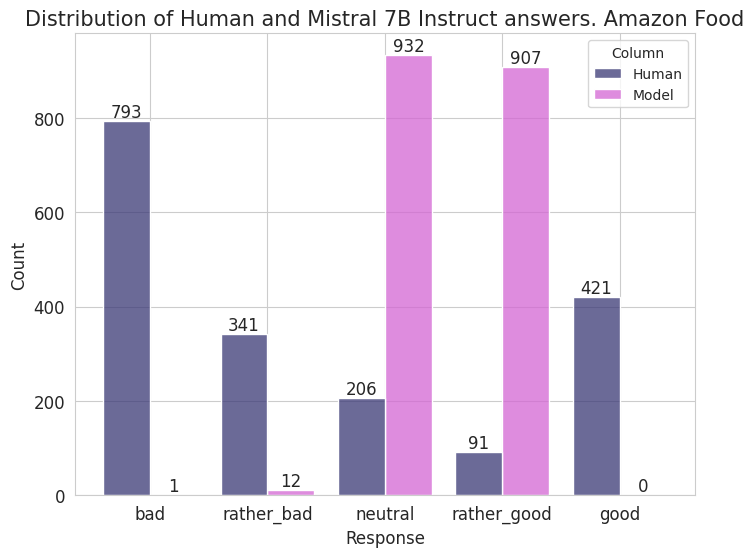

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_newsgroups_distrib_5classes.svg


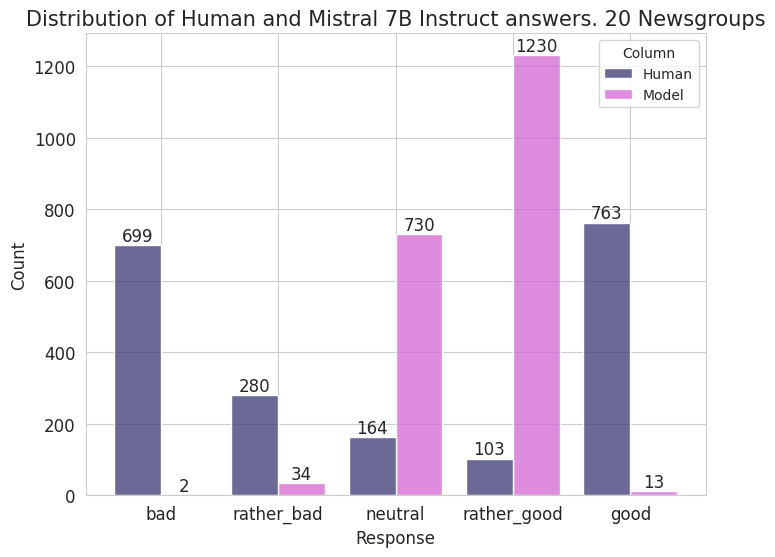

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_amazon_conf_matrix_5classes.png


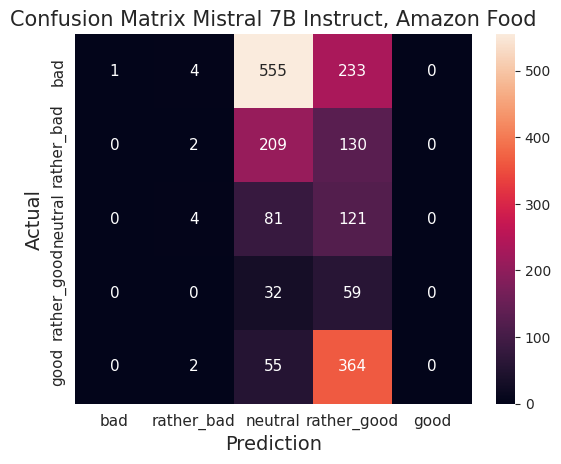

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral7B_2_newsgroups_conf_matrix_5classes.png


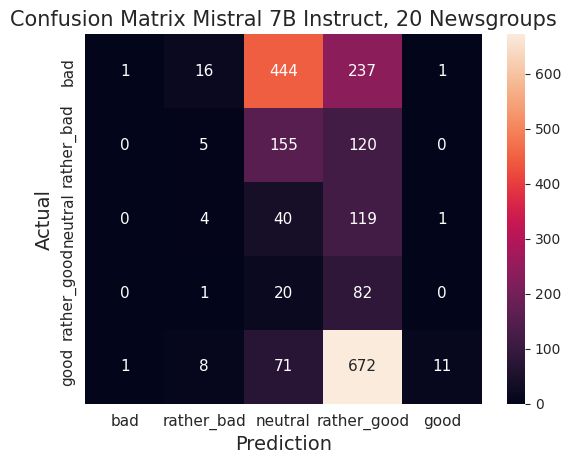

In [194]:
# Divide into two datasets
data_prompt_mistral_2_amazon = data_prompt_mistral_2[data_prompt_mistral_2["task"].isin(amazon_food_texts)]
data_prompt_mistral_2_newsgroups = data_prompt_mistral_2[data_prompt_mistral_2["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_mistral_2_amazon,
    model_name='Mistral 7B Instruct',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_amazon_distrib_5classes.svg'),
    print_plot=True,
    num_class=5,
    )

TmEval.plot_answers_distrib(
    data_prompt_mistral_2_newsgroups,
    model_name='Mistral 7B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_newsgroups_distrib_5classes.svg'),
    print_plot=True,
    num_class=5,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )



# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_2_amazon["true"]),
    np.array(data_prompt_mistral_2_amazon["model_extracted"]),
    model_name="Mistral 7B Instruct, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_amazon_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_mistral_2_newsgroups["true"]),
    np.array(data_prompt_mistral_2_newsgroups["model_extracted"]),
    model_name="Mistral 7B Instruct, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral7B_2_newsgroups_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    )

In [196]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_2_amazon_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral7B_2_newsgroups_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.077214  0.054888

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.069189  0.055113


#### Results of the Metrics

In [197]:
# Let's calculate metrics for model's answers
data_prompt_mistral_2["classification_metric"] = TmEval.classification_metric(data=data_prompt_mistral_2["model_extracted"], num_class=5)
data_prompt_mistral_2.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  model_extracted  \
0                                        neutral</s>                0   
1                                        neutral</s>                0   
2                                        neutral</s>                0   
3                                        neutral</s>                0   
4                                        neutral</s>                0   
5                                        neutral</s>                0   
6   rather yes. The words have some connection to...                1   
7                                     rather yes</s>                1   
8                                     rather no.</s>               -1   
9                                        neutral</s>                0   

   classification_metric  
0                   0.50  
1                   0.50  
2                   0.50  
3                   0.50  
4                   0.50  
5                   0.50  
6                   0.75  
7                   0.75  
8                   0.25  
9                   0.50

In [198]:
data_prompt_mistral_2.to_csv("mistral2_classification_5.csv")

In [199]:
tmp_res_def = data_prompt_mistral_2[["task", "true", "classification_metric"]].rename(columns={"classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_mistral_2_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_mistral_2_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_2_amazon_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_2_newsgroups_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.319019  0.444607        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik  pearson accuracy f1_score
0  0.596989  0.48258        -        -


### Llama2 Type I
You are a useful assistant who evaluates the coherence of words.

You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.

Classification rules:
yes - if words have a strong connection between them

rather yes - if some words are too common or out of topic

rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics

no - when words seem to be unconnected

neutral - if it is hard for you to answer on the question.\nPrint only class without explanation and additional information.

In [200]:
data_prompt_llama2.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  
0    Sure! Here's the classification of the given...  
1    Sure! Here's the classification of the given...  
2    Sure! Here's the classification of the given...  
3    Sure! Here's the classification of the given...  
4    Sure! Here's the classification of the given...  
5    Sure, I'd be happy to help!  Classification:...  
6    Sure! Here's the classification of the given...  
7    Sure! Here's the classification of the given...  
8    Sure! Here's the classification of the given...  
9    Sure! Here's the classification of the given...

In [201]:
# Results postprocessing
data_prompt_llama2 = TmEval.postprocess_results(
    data_prompt_llama2, 
    num_class=5, 
    answer_type="word"
    )

data_prompt_llama2.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  model_extracted  
0    Sure! Here's the classification of the given...                1  
1    Sure! Here's the classification of the given...                1  
2    Sure! Here's the classification of the given...                1  
3    Sure! Here's the classification of the given...                1  
4    Sure! Here's the classification of the given...               -1  
5    Sure, I'd be happy to help!  Classification:...               -1  
6    Sure! Here's the classification of the given...                1  
7    Sure! Here's the classification of the given...                1  
8    Sure! Here's the classification of the given...               -1  
9    Sure! Here's the classification of the given...                1

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_amazon_distrib_5classes.svg


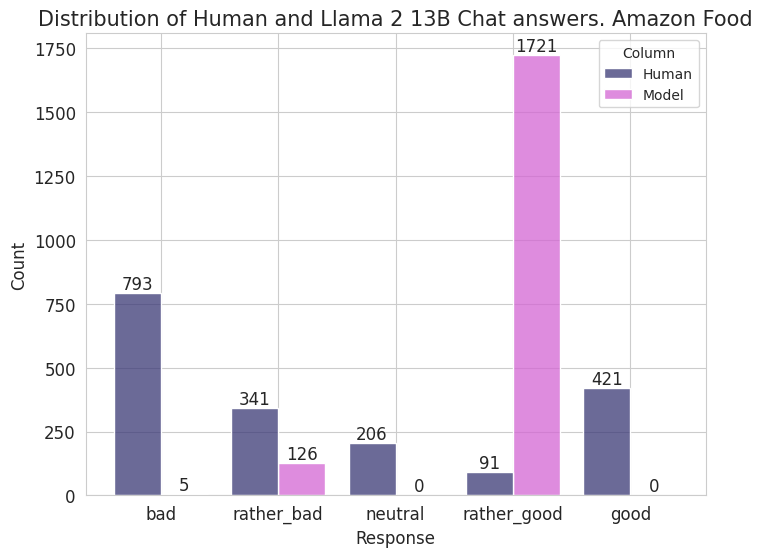

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_newsgroups_distrib_5classes.svg


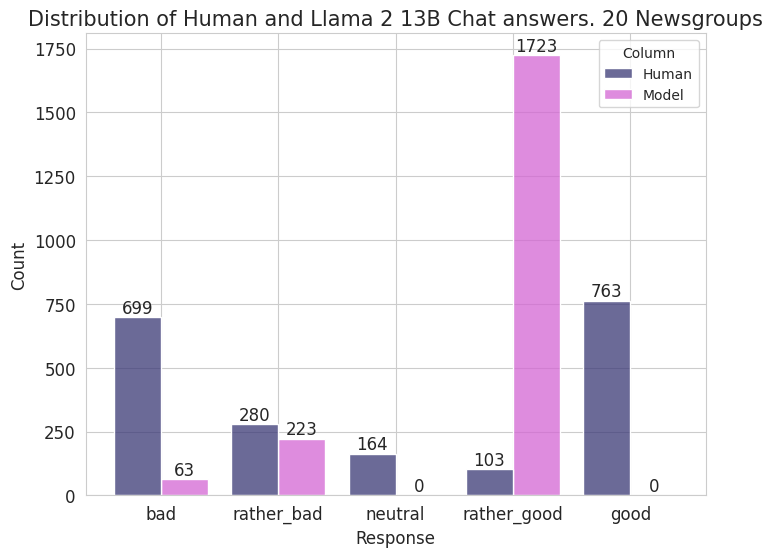

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_amazon_conf_matrix_5classes.png


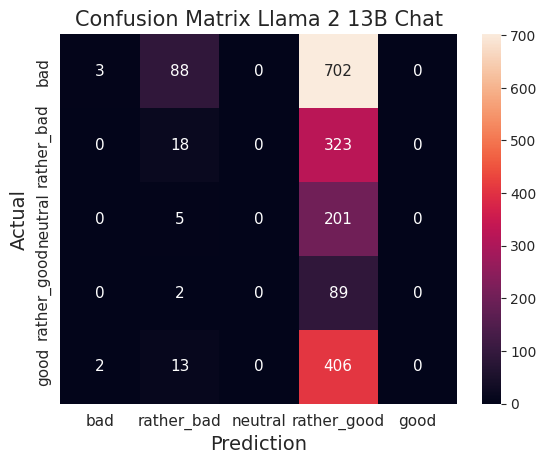

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama2_newsgroups_conf_matrix_5classes.png


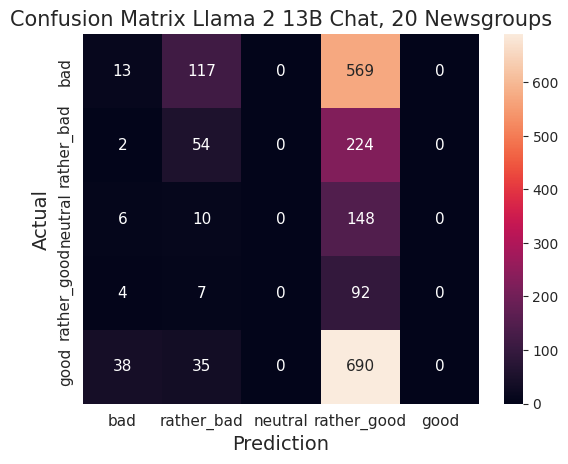

In [202]:
# Divide into two datasets
data_prompt_llama2_amazon = data_prompt_llama2[data_prompt_llama2["task"].isin(amazon_food_texts)]
data_prompt_llama2_newsgroups = data_prompt_llama2[data_prompt_llama2["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_llama2_amazon,
    model_name='Llama 2 13B Chat',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_amazon_distrib_5classes.svg'),
    print_plot=True,
    num_class=5,
    )

TmEval.plot_answers_distrib(
    data_prompt_llama2_newsgroups,
    model_name='Llama 2 13B Chat',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_newsgroups_distrib_5classes.svg'),
    print_plot=True,
    num_class=5,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_llama2_amazon["true"]),
    np.array(data_prompt_llama2_amazon["model_extracted"]),
    model_name="Llama 2 13B Chat",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_amazon_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_llama2_newsgroups["true"]),
    np.array(data_prompt_llama2_newsgroups["model_extracted"]),
    model_name="Llama 2 13B Chat, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama2_newsgroups_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    
    )

In [203]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_amazon_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_llama2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_newsgroups_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.059395  0.036568

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.079144   0.06992


#### Results of the Metrics

In [204]:
# Let's calculate metrics for model's answers
data_prompt_llama2["classification_metric"] = TmEval.classification_metric(data=data_prompt_llama2["model_extracted"], num_class=5)
data_prompt_llama2.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  model_extracted  \
0    Sure! Here's the classification of the given...                1   
1    Sure! Here's the classification of the given...                1   
2    Sure! Here's the classification of the given...                1   
3    Sure! Here's the classification of the given...                1   
4    Sure! Here's the classification of the given...               -1   
5    Sure, I'd be happy to help!  Classification:...               -1   
6    Sure! Here's the classification of the given...                1   
7    Sure! Here's the classification of the given...                1   
8    Sure! Here's the classification of the given...               -1   
9    Sure! Here's the classification of the given...                1   

   classification_metric  
0                   0.75  
1                   0.75  
2                   0.75  
3                   0.75  
4                   0.25  
5                   0.25  
6                   0.75  
7                   0.75  
8                   0.25  
9                   0.75

In [205]:
data_prompt_llama2.to_csv("llama2_classification_5.csv")

In [206]:
tmp_res_def = data_prompt_llama2[["task", "true", "classification_metric"]].rename(columns={"classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_llama2_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_llama2_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama2_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_amazon_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_llama2_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama2_newsgroups_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']


       phik  pearson accuracy f1_score
0  0.133807  0.12497        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.191869  0.089475        -        -


### Mistral + LoRA (without system prompt)
r = 16
epochs = 20

In [207]:
data_lora_mistral.head(10)

Human Model                                            wordset
0   rather_bad  good  able amaze fill glad stop daily fantastic move...
1   rather_bad  good  able amaze fill stop glad daily fantastic move...
2   rather_bad  good  able amaze fill stop glad daily fantastic move...
3          bad  good  able amaze glad fill stop fantastic daily move...
4  rather_good   bad  absolute church truth doug scripture symbol li...
5   rather_bad  good  absolute church truth mission nasa doug mars e...
6         good   bad  absolute mission church nasa mars earth truth ...
7   rather_bad  good  absolutely fast white rice service noodle terr...
8         good  good  absolutely fast white super service customer r...
9          bad  good  absolutely grain experience soon there's proce...

In [208]:
data_lora_mistral.rename(
    {
        "Human": "true",
        "Model": "model_extracted",
        "wordset": "task"
    },
    inplace=True,
    axis=1
)

#### Rrsults of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_amazon_distrib_5classes.svg


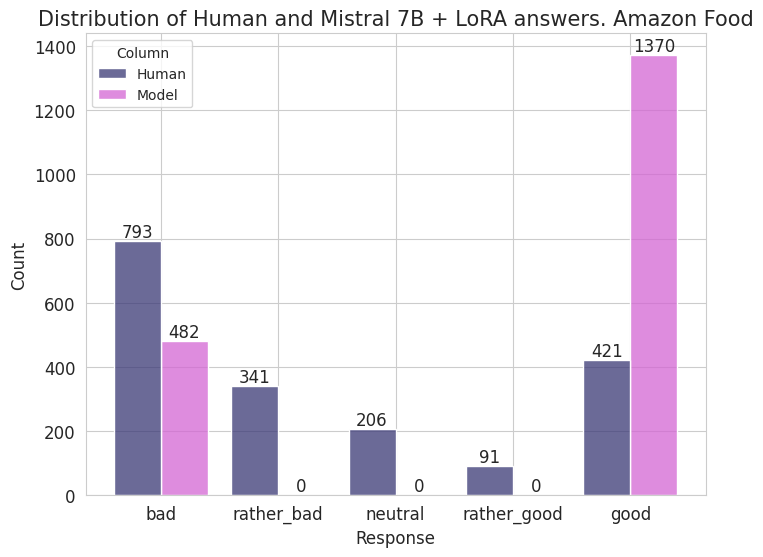

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_newsgroups_distrib_5classes.svg


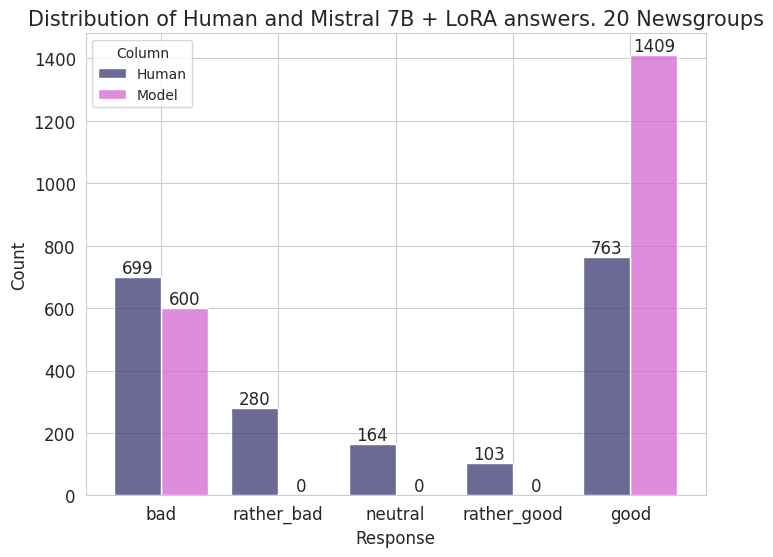

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_amazon_conf_matrix_5classes.png


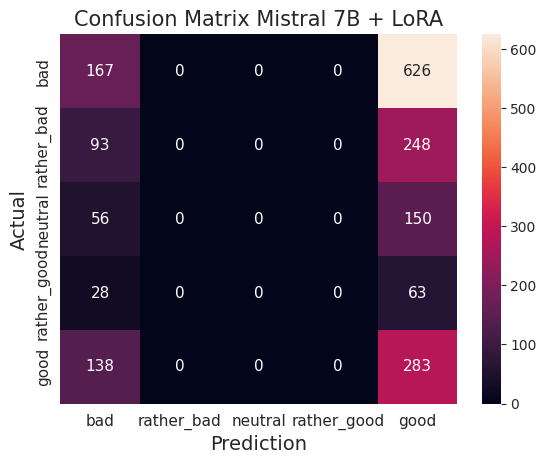

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/mistral_lora_newsgroups_conf_matrix_5classes.png


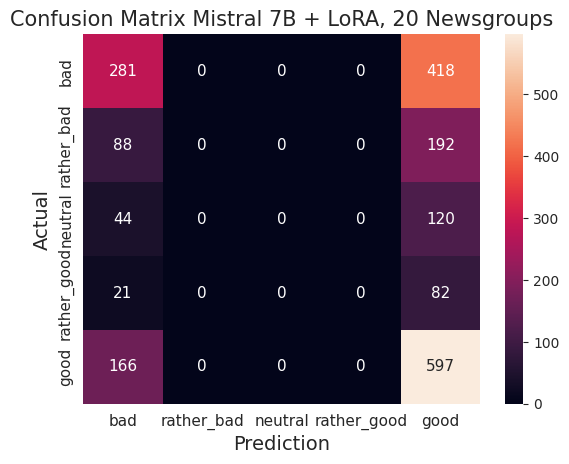

In [209]:
# Divide into two datasets
data_lora_mistral_amazon = data_lora_mistral[data_lora_mistral["task"].isin(amazon_food_texts)]
data_lora_mistral_newsgroups = data_lora_mistral[data_lora_mistral["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_lora_mistral_amazon,
    model_name='Mistral 7B + LoRA',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_amazon_distrib_5classes.svg'),
    print_plot=True,
    num_class=5,
    )

TmEval.plot_answers_distrib(
    data_lora_mistral_newsgroups,
    model_name='Mistral 7B + LoRA',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_newsgroups_distrib_5classes.svg'),
    print_plot=True,
    num_class=5,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_lora_mistral_amazon["true"]),
    np.array(data_lora_mistral_amazon["model_extracted"]),
    model_name="Mistral 7B + LoRA",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_amazon_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    )

TmEval.plot_conf_matrix(
    np.array(data_lora_mistral_newsgroups["true"]),
    np.array(data_lora_mistral_newsgroups["model_extracted"]),
    model_name="Mistral 7B + LoRA, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/mistral_lora_newsgroups_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    )

In [210]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_lora_mistral_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/lora_mistral_amazon_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_lora_mistral_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/lora_mistral_newsgroups_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.242981  0.115597

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.437033  0.196473


#### Results of the Metrics

In [211]:
# Let's calculate metrics for model's answers
data_prompt_mistral_lora["classification_metric"] = TmEval.classification_metric(data=data_prompt_mistral_lora["model_extracted"], num_class=5)
data_prompt_mistral_lora.head(10)

true  model_extracted                                               task  \
0   bad               -2  able amaze fill glad stop daily fantastic move...   
1   bad               -2  able amaze fill stop glad daily fantastic move...   
2   bad               -2  able amaze fill stop glad daily fantastic move...   
3   bad               -2  able amaze glad fill stop fantastic daily move...   
4  good               -2  absolute church truth doug scripture symbol li...   
5   bad                2  absolute church truth mission nasa doug mars e...   
6  good               -2  absolute mission church nasa mars earth truth ...   
7   bad               -2  absolutely fast white rice service noodle terr...   
8  good               -2  absolutely fast white super service customer r...   
9   bad               -2  absolutely grain experience soon there's proce...   

   true_num  classification_metric  
0        -2                      0  
1        -2                      0  
2        -2                      0  
3        -2                      0  
4         2                      0  
5        -2                      1  
6         2                      0  
7        -2                      0  
8         2                      0  
9        -2                      0

In [212]:
data_prompt_mistral_lora.to_csv("mistral_lora_classification_5.csv")

In [213]:
tmp_res_def = data_prompt_mistral_lora[["task", "true", "classification_metric"]].rename(columns={"classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_mistral_lora_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_mistral_lora_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_mistral_lora_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_lora_amazon_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_mistral_lora_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/mistral_lora_newsgroups_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.673337  0.472255        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.779208  0.570076        -        -


### Llama3-8B Instruct
You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules:yes - if words have a strong connection between them; "rather yes - if some words are too common or out of topic; rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics; no - when words seem to be unconnected; neutral - if it is hard for you to answer on the question. Print only class without explanation and additional information.

In [219]:
data_prompt_llama3.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  model_extracted  
0  neutral[/INST]```  The output should be: ``` n...                0  
1  neutral[/INST]``` ``` <s>[INST]You will receiv...                0  
2  neutral[/INST]``` ``` s>[INST]You will receive...                0  
3  neutral[/INST]``` ``` s>[INST]You will receive...                0  
4  neutral[/INST] [/INST] [/INST] [/INST] [/INST]...                0  
5  neutral[/INST]``` ``` s>[INST]You will receive...                0  
6         neutral[/INST]s>[/INST]s>[/INST]s>[/INST]s                0  
7  neutral[/INST]``` ``` s>[INST]You will receive...                0  
8  neutral ```  The output is `neutral`, indicati...                0  
9  neutral[/INST]</s> <s>[INST]You will receive a...                0

In [220]:
# Results postprocessing
data_prompt_llama3 = TmEval.postprocess_results(
    data_prompt_llama3, 
    num_class=5, 
    answer_type="word"
    )

data_prompt_llama3.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  model_extracted  
0  neutral[/INST]```  The output should be: ``` n...                0  
1  neutral[/INST]``` ``` <s>[INST]You will receiv...                0  
2  neutral[/INST]``` ``` s>[INST]You will receive...                0  
3  neutral[/INST]``` ``` s>[INST]You will receive...                0  
4  neutral[/INST] [/INST] [/INST] [/INST] [/INST]...                0  
5  neutral[/INST]``` ``` s>[INST]You will receive...                0  
6         neutral[/INST]s>[/INST]s>[/INST]s>[/INST]s                0  
7  neutral[/INST]``` ``` s>[INST]You will receive...                0  
8  neutral ```  The output is `neutral`, indicati...                0  
9  neutral[/INST]</s> <s>[INST]You will receive a...                0

#### Results of the Research

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_amazon_distrib_5classes.svg


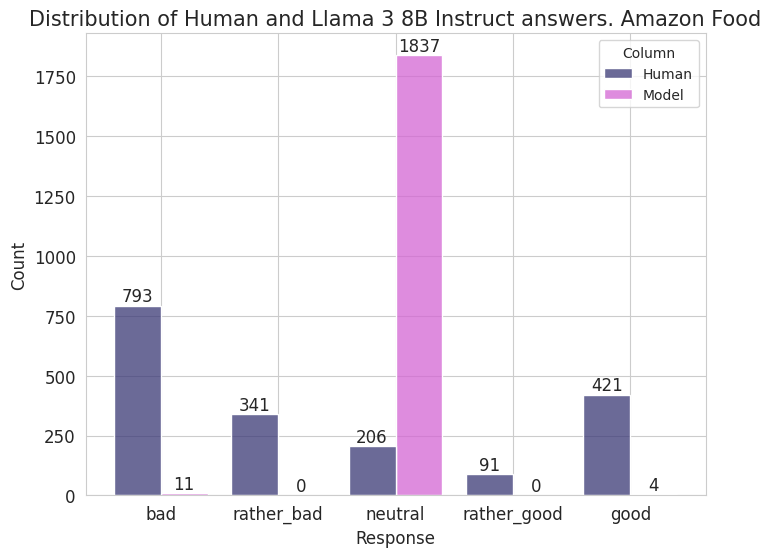

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_newsgroups_distrib_5classes.svg


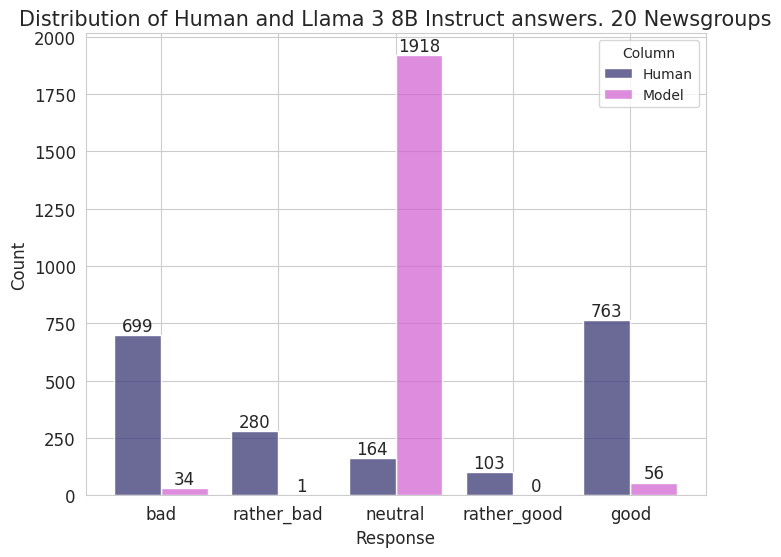

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_amazon_conf_matrix_5classes.png


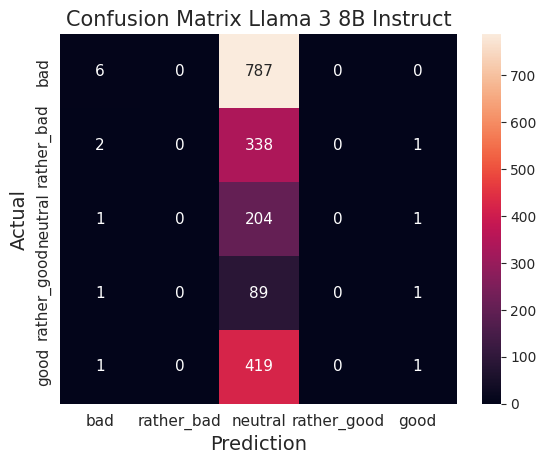

Plot was saved to the file /home/alexandra/ITMO/RW'23/LLM_QE_TM/data/results/plots/llama3_newsgroups_conf_matrix_5classes.png


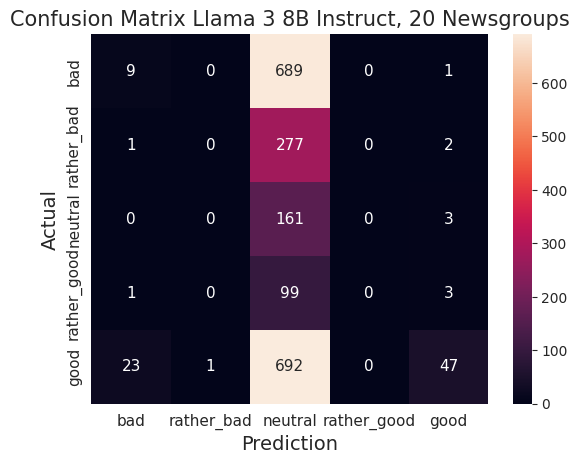

In [221]:
# Divide into two datasets
data_prompt_llama3_amazon = data_prompt_llama3[data_prompt_llama3["task"].isin(amazon_food_texts)]
data_prompt_llama3_newsgroups = data_prompt_llama3[data_prompt_llama3["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    data_prompt_llama3_amazon,
    model_name='Llama 3 8B Instruct',
    dataset_name='Amazon Food',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_amazon_distrib_5classes.svg'),
    print_plot=True,
    num_class=5,
    )

TmEval.plot_answers_distrib(
    data_prompt_llama3_newsgroups,
    model_name='Llama 3 8B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_newsgroups_distrib_5classes.svg'),
    print_plot=True,
    num_class=5,
    # fig_size=(12, 11),
    # title_size=18,
    # ticks_size=16,
    # label_size=16,
    # container_size=16
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(data_prompt_llama3_amazon["true"]),
    np.array(data_prompt_llama3_amazon["model_extracted"]),
    model_name="Llama 3 8B Instruct",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_amazon_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    )

TmEval.plot_conf_matrix(
    np.array(data_prompt_llama3_newsgroups["true"]),
    np.array(data_prompt_llama3_newsgroups["model_extracted"]),
    model_name="Llama 3 8B Instruct, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=BASE_DIR.joinpath('data/results/plots/llama3_newsgroups_conf_matrix_5classes.png'),
    print_plot=True,
    num_class=5
    )

In [222]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama3_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_amazon_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_amazon)

print("\nMetric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_llama3_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_newsgroups_metrices_5classes.csv'),
    metric_flags=["f1-score", "accuracy"]
)
print(metrics_newsgoups)

Metrics for Amazon Food
  phik pearson  accuracy  f1_score
0    -       -  0.113931  0.043868

Metric for 20 Newsgroups
  phik pearson  accuracy  f1_score
0    -       -  0.108014  0.058798


#### Results of the Metrics

In [224]:
# Let's calculate metrics for model's answers
data_prompt_llama3["classification_metric"] = TmEval.classification_metric(data=data_prompt_llama3["model_extracted"], num_class=5)
data_prompt_llama3.head(10)

task  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  model_extracted  \
0  neutral[/INST]```  The output should be: ``` n...                0   
1  neutral[/INST]``` ``` <s>[INST]You will receiv...                0   
2  neutral[/INST]``` ``` s>[INST]You will receive...                0   
3  neutral[/INST]``` ``` s>[INST]You will receive...                0   
4  neutral[/INST] [/INST] [/INST] [/INST] [/INST]...                0   
5  neutral[/INST]``` ``` s>[INST]You will receive...                0   
6         neutral[/INST]s>[/INST]s>[/INST]s>[/INST]s                0   
7  neutral[/INST]``` ``` s>[INST]You will receive...                0   
8  neutral ```  The output is `neutral`, indicati...                0   
9  neutral[/INST]</s> <s>[INST]You will receive a...                0   

   classification_metric  
0                    0.5  
1                    0.5  
2                    0.5  
3                    0.5  
4                    0.5  
5                    0.5  
6                    0.5  
7                    0.5  
8                    0.5  
9                    0.5

In [225]:
data_prompt_llama3.to_csv("llama3_classification_5.csv")

In [226]:
tmp_res_def = data_prompt_llama3[["task", "true", "classification_metric"]].rename(columns={"classification_metric": "model_extracted"})

# Divide into two datasets
data_prompt_llama3_amazon = tmp_res_def[tmp_res_def["task"].isin(amazon_food_texts)]
data_prompt_llama3_newsgroups = tmp_res_def[tmp_res_def["task"].isin(newsgroups_texts)]

# Calculate correlations
print("Correlations for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=data_prompt_llama3_amazon,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_amazon_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_amazon)

print("\nCorrelations for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=data_prompt_llama3_newsgroups,
    save_dir=BASE_DIR.joinpath('data/results/metrics/llama3_newsgroups_corr_5classes.csv'),
    metric_flags=["phik", "lin_corr"]
)
print(metrics_newsgoups)

Correlations for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
   phik   pearson accuracy f1_score
0   0.0  0.034642        -        -

Correlations for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik   pearson accuracy f1_score
0  0.122933  0.086162        -        -


# Naming


In [227]:
def extract_text_in_quotes(input_string):
    pattern = r'"(.*?)"' 
    matches = re.findall(pattern, input_string)
    matches = [string.replace(",", "") for string in matches]
    if len(matches) == 0:
        matches = input_string
    return matches

In [228]:
def extract_substring_after_word(input_string, target_word):
    index = input_string.find(target_word) 
    if index != -1: 
        substring = input_string[index + len(target_word):]  
        return substring.strip()  
    else:
        return input_string

In [229]:
def extract_words_in_quotes_after_phrase(input_string):
    input_string = input_string.lower()
    pattern = r'the common topic.*? (is|be) "(.*?)"(?: (or|and) "(.*?)")?'  # A pattern for searching for words in quotation marks after the specified phrase
    matches = re.findall(pattern, input_string)  # Find all matches with the pattern in the string
    extracted_words = [match[1].replace('.', '') for match in matches]  # Extracting the first word from the found matches
    for match in matches:
        if match[3]:  # If there is a second word after "or" or"and", add it to the list
            extracted_words.append(match[3].replace('.', ''))
    if extracted_words:
        return extracted_words
    else:
        return input_string.replace('.', '')

In [230]:
def extract_words_after_phrase(input_string):
    input_string = input_string.lower()
    pattern = r'\s*topic:\s*([\w-]+)(?:\s+(or|and)\s+([\w-]+))?'  # A pattern for searching for words after the specified phrase
    matches = re.findall(pattern, input_string)  # Find all matches with the pattern in the string
    extracted_words = [match[0].replace('.', '') for match in matches]  # Extracting the first word from the found matches
    for match in matches:
        if match[2]:  # If there is a second word after "or" or "and", add it to the list
            extracted_words.append(match[2].replace('.', ''))
    if extracted_words:
        return extracted_words
    else:
        return input_string.replace('.', '')

In [231]:
def print_cos_sim_distrib(
        data,
        model_name='',
        dataset_name='',
        fig_size=(8, 6),
        container_size=12,
        title_size=15,
        ticks_size=12,
        label_size=12,
        save_dir=None,
        print_plot=True
    ):

    category_order = ['VL', 'L', 'M', 'H', 'VH']
    data['cos_sim_class'] = pd.Categorical(data['cos_sim_class'], categories=category_order, ordered=True)

    plt.figure(figsize=fig_size)

    ax = sns.histplot(data=data, x="cos_sim_class", color="#3A3875")    

    for i in ax.containers:
        ax.bar_label(i, fontsize=container_size)

    plt.title(f'Distribution of the cosine similarity classes, {dataset_name}, {model_name}', fontsize=title_size)

    plt.xticks(fontsize=ticks_size)
    plt.yticks(fontsize=ticks_size)

    ax.set_xlabel('Class of the cosine similarity', fontsize=label_size)
    ax.set_ylabel('Count', fontsize=label_size)

    if save_dir is not None:
        plt.savefig(save_dir)
        print(f"Plot was saved to the file {save_dir}")

    if print_plot:
        plt.show()
    else:
        plt.close()

In [209]:
def calculate_corr(data):
    # non-linear dependencies
    phik_corr = data[["true", "pred"]].phik_matrix()
    phik_corr = phik_corr.loc["true"]["pred"]

    # linear_correlation
    lin_corr = data[["true", "pred"]].corr()
    lin_corr = lin_corr.loc["true"]["pred"]
    metrics_df = pd.DataFrame(
        {
            "phik": [phik_corr],
            "pearson": [lin_corr]
        }
    )

    return metrics_df

In [235]:
PROMPT_MISTRAL_1 = "data_topic_name_distrib_mistral_7b_4bit_type1_1.csv"
# PROMPT_MISTRAL_2 = "data_topic_name_distrib_mistral_7b_4bit_type2_1.csv"
PROMPT_MISTRAL_3 = "data_topic_name_distrib_mistral_7b_4bit_type3_1.csv"
PROMPT_MISTRAL_4 = "data_topic_name_distrib_mistral_7b_4bit_type_new.csv"
PROMPT_LLAMA2_1 = "data_topic_name_distrib_llama_13B_4bit_type1.csv"
PROMPT_LLAMA2_2 = "data_topic_name_distrib_llama_13B_4bit_new.csv"
PROMPT_LLAMA3 = "llama3_8B_topic_gen.csv"

PROMPT_MISTRAL_1 = DATA_DIR.joinpath(PROMPT_MISTRAL_1)
# PROMPT_MISTRAL_2 = DATA_DIR.joinpath(PROMPT_MISTRAL_2)
PROMPT_MISTRAL_3 = DATA_DIR.joinpath(PROMPT_MISTRAL_3)
PROMPT_MISTRAL_4 = DATA_DIR.joinpath(PROMPT_MISTRAL_4)
PROMPT_LLAMA2_1 = DATA_DIR.joinpath(PROMPT_LLAMA2_1)
PROMPT_LLAMA2_2 = DATA_DIR.joinpath(PROMPT_LLAMA2_2)
PROMPT_LLAMA3 = DATA_DIR.joinpath(PROMPT_LLAMA3)

data_prompt_mistral_1 = pd.read_csv(PROMPT_MISTRAL_1, sep=";", names=["text", "topic"])
# data_prompt_mistral_2 = pd.read_csv(PROMPT_MISTRAL_2, sep=";", names=["text", "topic"])
data_prompt_mistral_3 = pd.read_csv(PROMPT_MISTRAL_3, sep=";", names=["text", "topic"])
data_prompt_mistral_4 = pd.read_csv(PROMPT_MISTRAL_4, sep=";", names=["text", "topic"])
data_prompt_llama2_1 = pd.read_csv(PROMPT_LLAMA2_1, sep=";", names=["text", "topic"])
data_prompt_llama2_2 = pd.read_csv(PROMPT_LLAMA2_2, sep=";", names=["text", "topic"])
data_prompt_llama3 = pd.read_csv(PROMPT_LLAMA3, sep=";", names=["text", "topic"])

In [236]:
INITIAL_FILE_DIR = BASE_DIR.joinpath('data/datasets')
TWO_CLASSES = "data_quality_estim.csv"

TWO_CLASSES = INITIAL_FILE_DIR.joinpath(TWO_CLASSES)
two_classes = pd.read_csv(TWO_CLASSES, sep=',')

Semantic cosine similarity ranges:
1. Very High Similarity: VH

**Cosine similarity: 0.8 to 1.0**

This range suggests that the vectors are almost identical in orientation, indicating a very high degree of similarity.

2. High Similarity: H

**Cosine similarity: 0.6 to 0.8**

Vectors are closely aligned, suggesting a high level of similarity.

3. Moderate Similarity: M

**Cosine similarity: 0.3 to 0.6**

This range indicates a moderate level of similarity, with vectors somewhat aligned.

4. Low Similarity: L

**Cosine similarity: 0 to 0.3**

Vectors are not very well aligned, suggesting a low degree of similarity.

5. Very Low or Negative Similarity: VL

**Cosine similarity: -1.0 to 0**

A negative value indicates that the vectors are pointing in more opposite directions, suggesting dissimilarity. Values close to 0 but negative might indicate a very low degree of similarity.

## Get Real Data

In [237]:
# Extract human naming
BASE_DIR = Path('result_analysis.ipynb').resolve().parent.parent
original_data_dir = BASE_DIR.joinpath('data/datasets')
original_naming_file = "data_topic_name_distrib.csv"
original_naming_file = original_data_dir.joinpath(original_naming_file)
original_naming = pd.read_csv(original_naming_file, sep=",")

In [239]:
# Extract topics for similar topics
topic_name_true = []
text_lst = []
unique_wordset = list(set(original_naming["INPUT:wordset"]))
for wordset in unique_wordset:
    text_lst.append(wordset)
    topics = list(set(original_naming["OUTPUT:topic_name"][original_naming["INPUT:wordset"]==wordset]))

    topic_name_true.append(topics)

original_topics_df = pd.DataFrame(data={"text": unique_wordset, "topics": topic_name_true})

In [240]:
original_topics_df

text  \
0     bought free cooky butter peanut gluten cookie ...   
1     window display application server screen color...   
2     buying money cheaper compare bulk dont hate co...   
3     doctor disease patient treatment cand medical ...   
4     image graphics package user unix directory ano...   
...                                                 ...   
2358  bible church christ faith matthew father scrip...   
2359  milk n't diet start stomach soy substitute sha...   
2360  pres administration official congress secretar...   
2361  scsi controller interface transfer bios disk d...   
2362  free gluten salmon balance wet turkey diet kit...   

                                                 topics  
0                                     [food , shopping]  
1     [window , informatic, computer software , comp...  
2                                             [buying ]  
3                [disease, medicine, illness, hospital]  
4                    [technology, graphic design, site]  
...                                                 ...  
2358           [religion , religious, church, religion]  
2359                                             [diet]  
2360     [congress , politics, administration , office]  
2361                                          [devices]  
2362                                           [salmon]  

[2363 rows x 2 columns]

## Mistral Type I

[INST] You are a helpful, respectful and honest assistant for labeling topics. You will receive a list of words and you should analyze it and label list of words with one or few words. Please, make sure you to only return the topic and nothing more.


Text: ... [/INST]

In [200]:
data_prompt_mistral_1.head(10)

text  \
0  policy peace israeli arab israel proposal tyre...   
1  drinking mild espresso aftertaste brewing latt...   
2  local piece grocery sell deal carry market gla...   
3  value teeth difficult msg pea bone spent rawh ...   
4  bill fire koresh clinton scott child batf comp...   
5  way drinking mild aftertaste espresso weird si...   
6  nasa launch orbit satellite mission moon earth...   
7  price phone bike sell email company offer cost...   
8  printer radio signal print design output input...   
9  scsi controller fast interface speed bios tran...   

                                               topic  
0                        Israeli-Arab Peace Proposal  
1                                             Coffee  
2                                  Grocery shopping.  
3                        Topic: Health and Nutrition  
4   Bill, Fire, Koresh, Clinton, Scott, Child, Ba...  
5                                             Coffee  
6                                 Space exploration.  
7   Technology, Offers, Sales, Email, Bike, Phone...  
8                                        Electronics  
9                                    SCSI Controller

In [201]:
data_prompt_mistral_1 = data_prompt_mistral_1.applymap(lambda x: x.lower())
data_prompt_mistral_1["topic"] = [x.replace(".", "") for x in data_prompt_mistral_1["topic"]]
data_prompt_mistral_1["topic"] = [x.replace("/", ", ") for x in data_prompt_mistral_1["topic"]]
data_prompt_mistral_1["topic"] = [x.replace("-", " ") for x in data_prompt_mistral_1["topic"]]

for i, topic in enumerate(data_prompt_mistral_1["topic"]):
    # Extract topics in quotes
    topic = extract_text_in_quotes(topic)
    if isinstance(topic, list):
        topic = ", ".join(topic)

    topic = extract_substring_after_word(topic, "topic:")

    data_prompt_mistral_1["topic"].iloc[i] = topic

data_prompt_mistral_1["topic"] = [x.strip() for x in data_prompt_mistral_1["topic"]]

For some data, the model simply outputs a list of words as topics. It is proposed to remove these sets

In [202]:
data_prompt_mistral_1["text_col_tmp"] = [data_prompt_mistral_1["topic"].iloc[i].replace(",", "").strip() for i in range(data_prompt_mistral_1.shape[0])]
data_prompt_mistral_1["tmp"] = data_prompt_mistral_1["text"] == data_prompt_mistral_1["text_col_tmp"]

print("The number of identical topics:", sum(data_prompt_mistral_1["tmp"]))
data_prompt_mistral_1 = data_prompt_mistral_1[data_prompt_mistral_1["tmp"]==False]
data_prompt_mistral_1 = data_prompt_mistral_1.drop(["text_col_tmp", "tmp"], axis=1)

The number of identical topics: 132


For one set of text, the model issued a quote (delete from the set)

In [203]:
print(data_prompt_mistral_1.loc[56]["topic"])
data_prompt_mistral_1.drop(labels=56, axis="index", inplace=True)


love is not blind it sees more than it sees


This prompt is not suitable, since it is a complex post-processing process, often the model answers the question purely with a list of source words, similarly to the second type of prompt

## Zero-Shot Mistral
You will receive a list of words and you should analyze it and name the common topic with one or few words.

In [241]:
data_prompt_mistral_3.head(10)

text  \
0  scsi controller interface disk transfer bios f...   
1  natural list contains raw berry book usa herb ...   
2  package shipping plastic offer delivery four g...   
3  drug court legal police illegal laws charge pr...   
4  israeli arab tape population border village po...   
5  sauce regular serve per save hot bit red spicy...   
6  card driver sound light copy running machine c...   
7  european canadian player hockey compass food l...   
8  food study effects animal rochester brain ence...   
9  image window user code public event motif grap...   

                                               topic  
0   The common topic in this list is "Storage Dev...  
1   The common topic in the given text is "natura...  
2   The common topic in the given text appears to...  
3   The common topic in the given text is "Legal ...  
4   The common topic in this list is "Israel-Pale...  
5   The common topic in the given text is "spicy ...  
6   The common topic in the given list of words i...  
7         The common topic in this list is "hockey."  
8   The common topic in the given list of words i...  
9   The common topic in the given list of words i...

### Results of the Research

In [144]:
# Extract topic in quotes
# The common topic ... is / to be " " / " " or " " / " " and " "

example_1 = 'the common topic in this list of words is "food" and "meat."'
example_2 = 'the common topic in the given text is "bulk buying" or "bulk purchasing."'
example_3 = 'the common topic in the given list of words is "display".'
example_4 = 'the common topic in the given text appears to be "shipping" and "delivery."'
example_5 = 'the common topic in this list of words is "coffee" and "tea" as they are both mentioned in the words "blend," "decaf," "caffeine," and "herbal."'
example_6 = 'space exploration.'
example_7 = 'the common topic is "Internet" and "Privacy."'
example_8 = 'the common topic in the given text could be "playthings" or "toys" as several words in the list are related to toys, such as "puppy," "toy," "play," "senseo," and "creamer."'

example_1 = extract_words_in_quotes_after_phrase(example_1)
example_2 = extract_words_in_quotes_after_phrase(example_2)
example_3 = extract_words_in_quotes_after_phrase(example_3)
example_4 = extract_words_in_quotes_after_phrase(example_4)
example_5 = extract_words_in_quotes_after_phrase(example_5)
example_6 = extract_words_in_quotes_after_phrase(example_6)
example_7 = extract_words_in_quotes_after_phrase(example_7)
example_8 = extract_words_in_quotes_after_phrase(example_8)

print(example_1)
print(example_2)
print(example_3)
print(example_4)
print(example_5)
print(example_6)
print(example_7)
print(example_8)

['food', 'meat']
['bulk buying', 'bulk purchasing']
['display']
['shipping', 'delivery']
['coffee', 'tea']
space exploration
['internet', 'privacy']
['playthings', 'toys']


In [291]:
data_prompt_mistral_3["topic"] = [x.lower() for x in data_prompt_mistral_3["topic"]]
data_prompt_mistral_3["topic"] = [x.replace("</s>", "") for x in data_prompt_mistral_3["topic"]]
data_prompt_mistral_3["topic"] = [x.replace(".", "") for x in data_prompt_mistral_3["topic"]]
data_prompt_mistral_3["topic"] = [extract_words_in_quotes_after_phrase(topic) for topic in data_prompt_mistral_3["topic"]]

for i, topic in enumerate(data_prompt_mistral_3["topic"]):
    if isinstance(topic, str):
        data_prompt_mistral_3["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_mistral_3["topic"].iloc[i]):
            data_prompt_mistral_3["topic"].iloc[i][j] = data_prompt_mistral_3["topic"].iloc[i][j].strip()

In [293]:
# Combine model topics with original ones
original_topics_lst = []

for text in data_prompt_mistral_3["text"]:
    original_topic = original_topics_df.loc[original_topics_df["text"]==text, "topics"].values[0]
    original_topics_lst.append(original_topic)

data_prompt_mistral_3["true_topic"] = original_topics_lst

In [147]:
metrics_topics = TmEval.get_topic_metric(
    data_true=data_prompt_mistral_3["true_topic"],
    data_pred=data_prompt_mistral_3["topic"]
)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/alexandra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 2363/2363 [04:26<00:00,  8.87it/s]


In [148]:
data_prompt_mistral_3["cos_sim"] = metrics_topics

In [149]:
cos_sim_range = []

for cos_sim in data_prompt_mistral_3["cos_sim"]:
    if cos_sim >= 0.8:
        cos_sim_range.append("VH")
    elif cos_sim >= 0.6 and cos_sim < 0.8:
        cos_sim_range.append("H")
    elif cos_sim >= 0.3 and cos_sim < 0.6:
        cos_sim_range.append("M")
    elif cos_sim >= 0.0 and cos_sim < 0.3:
        cos_sim_range.append("L")
    else:
        cos_sim_range.append("VL")

data_prompt_mistral_3["cos_sim_class"] = cos_sim_range

In [150]:
data_prompt_mistral_3.head(10)

text  \
0  scsi controller interface disk transfer bios f...   
1  natural list contains raw berry book usa herb ...   
2  package shipping plastic offer delivery four g...   
3  drug court legal police illegal laws charge pr...   
4  israeli arab tape population border village po...   
5  sauce regular serve per save hot bit red spicy...   
6  card driver sound light copy running machine c...   
7  european canadian player hockey compass food l...   
8  food study effects animal rochester brain ence...   
9  image window user code public event motif grap...   

                                 topic  \
0  [storage device, storage interface]   
1                 [natural ingredient]   
2                 [shipping, delivery]   
3      [legal issue, criminal justice]   
4           [israelpalestine conflict]   
5                 [spicy pepper sauce]   
6                           [hardware]   
7                             [hockey]   
8                      [study, effect]   
9                            [graphic]   

                                          true_topic   cos_sim cos_sim_class  
0                [computer, computer, computer part]  0.666545             H  
1        [list natural ingredient found in internet]  0.502946             M  
2                                             [good]  0.543696             M  
3                      [illegal, legal, police, law]  0.671478             H  
4                                          [geology]  0.407293             M  
5                                      [sauce, food]  0.458724             M  
6  [car race, computer, machine, compute, music s...  0.649949             H  
7                                           [hockey]  1.000000            VH  
8                                            [study]  1.000000            VH  
9                                [network, computer]  0.682860             H

In [151]:
# Divide text into words
data_prompt_mistral_3["text_words"] = [text.split() for text in data_prompt_mistral_3["text"]]

In [47]:
# Divide entire data into two datasets
data_prompt_mistral_3_amazon = data_prompt_mistral_3[data_prompt_mistral_3["text"].isin(amazon_food_texts)]
data_prompt_mistral_3_newsgroups = data_prompt_mistral_3[data_prompt_mistral_3["text"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_mistral_3_amazon.shape)
print(f"20newsgroups:", data_prompt_mistral_3_newsgroups.shape)

Amazon: (932, 5)
20newsgroups: (1431, 5)


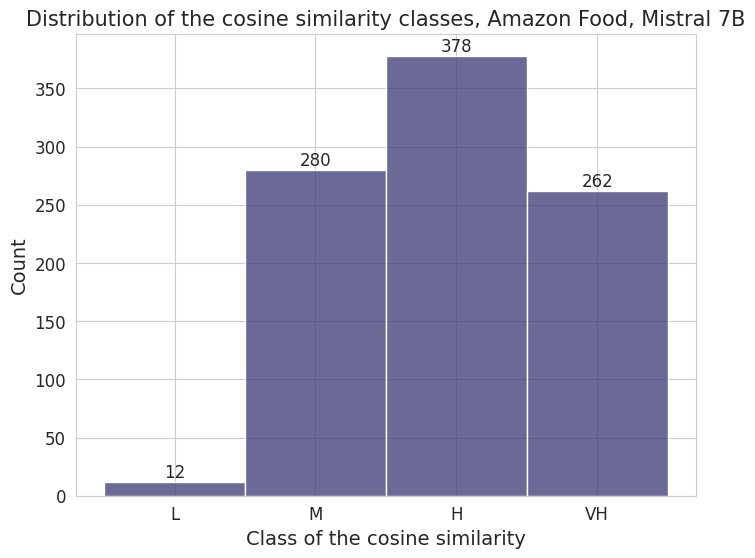

In [52]:
print_cos_sim_distrib(
    data=data_prompt_mistral_3_amazon,
    model_name="Mistral 7B",
    dataset_name="Amazon Food",
    print_plot=True,
    label_size=14
)

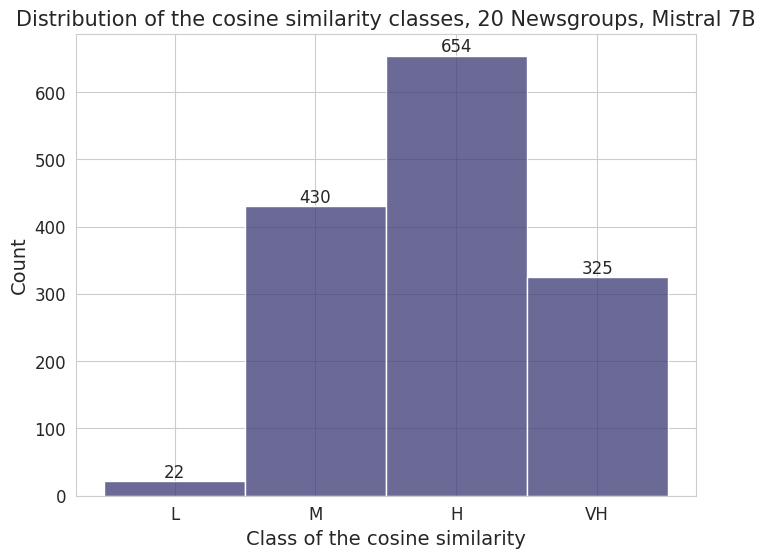

In [53]:
print_cos_sim_distrib(
    data=data_prompt_mistral_3_newsgroups,
    model_name="Mistral 7B",
    dataset_name="20 Newsgroups",
    print_plot=True,
    label_size=14
)

### Results of the Metrics

In [251]:
PROMPT_MISTRAL_3_BAD = "data_topic_name_distrib_mistral_7b_4bit_bad_type3_1.csv"
PROMPT_MISTRAL_3_BAD = DATA_DIR.joinpath(PROMPT_MISTRAL_3_BAD)
data_prompt_mistral_3_bad = pd.read_csv(PROMPT_MISTRAL_3_BAD, sep=";", names=["text", "topic"])

In [243]:
data_prompt_mistral_3 = pd.concat([data_prompt_mistral_3, data_prompt_mistral_3_bad], ignore_index=True)

In [252]:
data_prompt_mistral_3["topic"] = [x.lower() for x in data_prompt_mistral_3["topic"]]
data_prompt_mistral_3["topic"] = [x.replace("</s>", "") for x in data_prompt_mistral_3["topic"]]
data_prompt_mistral_3["topic"] = [x.replace(".", "") for x in data_prompt_mistral_3["topic"]]
data_prompt_mistral_3["topic"] = [extract_words_in_quotes_after_phrase(topic) for topic in data_prompt_mistral_3["topic"]]

for i, topic in enumerate(data_prompt_mistral_3["topic"]):
    if isinstance(topic, str):
        data_prompt_mistral_3["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_mistral_3["topic"].iloc[i]):
            data_prompt_mistral_3["topic"].iloc[i][j] = data_prompt_mistral_3["topic"].iloc[i][j].strip()

In [26]:
# Split text into words
data_prompt_mistral_3["text_split"] = [text.split() for text in data_prompt_mistral_3["text"]]

data_prompt_mistral_3["cos_sim"] = TmEval.get_topic_metric(
    data_true=data_prompt_mistral_3["text_split"],
    data_pred=data_prompt_mistral_3["topic"]
)

In [300]:
# two_classes["agg_label"] = [words_to_num(x) for x in two_classes["agg_label"]]
data_prompt_mistral_3["true"] = two_classes["agg_label"]
data_prompt_mistral_3.rename(columns={"cos_sim": "pred"}, inplace=True)

In [301]:
# Divide entire data into two datasets
data_prompt_mistral_3_amazon = data_prompt_mistral_3[data_prompt_mistral_3["text"].isin(amazon_food_texts)]
data_prompt_mistral_3_newsgroups = data_prompt_mistral_3[data_prompt_mistral_3["text"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_mistral_3_amazon.shape)
print(f"20newsgroups:", data_prompt_mistral_3_newsgroups.shape)

Amazon: (1852, 5)
20newsgroups: (2009, 5)


In [304]:
metrics_amazon = calculate_corr(data_prompt_mistral_3_amazon)
metrics_newsgroups = calculate_corr(data_prompt_mistral_3_newsgroups)

print("Correlations for Amazon Food\n")
print(metrics_amazon)
print("Correlations for 20 Newsgroups")
print(metrics_newsgroups)

interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
Correlations for Amazon Food

       phik   pearson
0  0.030751  0.014396
Correlations for 20 Newsgroups
       phik   pearson
0  0.092322 -0.041379


## Zero-Shot Llama-2  
< s > [INST] << SYS >> You are an assistant for topic modeling. << SYS >>
You will receive the TEXT and you should identify one or few TOPICS of the TEXT. Provide ONLY TOPICS and nothing more.
TEXT: bar sweet crunchy yummy cinnamon granola yogurt crunch cereal raisin flake snack almond combination blueberry
TOPIC: [/INST]

In [103]:
data_prompt_llama2_1.head(10)

text  \
0  population bullet arab israeli border village ...   
1  quote hell context death accept evil agree fee...   
2  enjoy strong morning brew blend bitter smooth ...   
3  worth packet waste splenda world horrible when...   
4  pres administration official congress secretar...   
5  bible religion turkish church belief truth fai...   
6  quote context umich taking feel learn maybe ag...   
7  israel israeli arab palestinian attack murder ...   
8  butter peanut apple orange aware jelly poor gr...   
9  work package receive surprised sample recipe f...   

                                               topic  
0  Sure, I'd be happy to help!The topic of the te...  
1  Sure! Here's the topic of the text you provide...  
2  Sure! Here's the topic of the text you provide...  
3  Sure! Here's the topic of the text you provide...  
4  Sure! Here is the topic of the text you provid...  
5  Sure! Here's the topic of the text you provide...  
6  Sure, I'd be happy to help! Here's the topic o...  
7  Sure! Here is the topic of the text you provid...  
8  Sure! Here's the topic of the text you provide...  
9  Sure! Here's the topic of the text you provide...

### Results of the Research

In [105]:
example_1 = 'gggg the common topic: food and peace'
example_2 = 'the common topic in the given text is "bulk buying" or "bulk purchasing."'
example_3 = 'the common topic in the given list of words is "display".'
example_4 = 'the common topic in the given text appears to be "shipping" and "delivery."'
example_5 = 'the common topic in this list of words is "coffee" and "tea" as they are both mentioned in the words "blend," "decaf," "caffeine," and "herbal."'
example_6 = 'space exploration.'
example_7 = 'the common topic is "Internet" and "Privacy."'
example_8 = 'the common topic in the given text could be "playthings" or "toys" as several words in the list are related to toys, such as "puppy," "toy," "play," "senseo," and "creamer."'

example_1 = extract_words_after_phrase(example_1)
example_2 = extract_words_in_quotes_after_phrase(example_2)
example_3 = extract_words_in_quotes_after_phrase(example_3)
example_4 = extract_words_in_quotes_after_phrase(example_4)
example_5 = extract_words_in_quotes_after_phrase(example_5)
example_6 = extract_words_in_quotes_after_phrase(example_6)
example_7 = extract_words_in_quotes_after_phrase(example_7)
example_8 = extract_words_in_quotes_after_phrase(example_8)

print(example_1)
print(example_2)
print(example_3)
print(example_4)
print(example_5)
print(example_6)
print(example_7)
print(example_8)

['food', 'peace']
['bulk buying', 'bulk purchasing']
['display']
['shipping', 'delivery']
['coffee', 'tea']
space exploration
['internet', 'privacy']
['playthings', 'toys']


In [106]:
data_prompt_llama2_1["topic"] = [x.lower() for x in data_prompt_llama2_1["topic"]]
data_prompt_llama2_1["topic"] = [x.replace("</s>", "") for x in data_prompt_llama2_1["topic"]]
data_prompt_llama2_1["topic"] = [x.replace(".", "") for x in data_prompt_llama2_1["topic"]]
data_prompt_llama2_1["topic"] = [extract_words_after_phrase(topic) for topic in data_prompt_llama2_1["topic"]]

for i, topic in enumerate(data_prompt_llama2_1["topic"]):
    if isinstance(topic, str):
        data_prompt_llama2_1["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_llama2_1["topic"].iloc[i]):
            data_prompt_llama2_1["topic"].iloc[i][j] = data_prompt_llama2_1["topic"].iloc[i][j].strip()

In [109]:
# Combine model topics with original ones
original_topics_lst = []

for text in data_prompt_llama2_1["text"]:
    original_topic = original_topics_df.loc[original_topics_df["text"]==text, "topics"].values[0]
    original_topics_lst.append(original_topic)

data_prompt_llama2_1["true_topic"] = original_topics_lst

In [110]:
metrics_topics = TmEval.get_topic_metric(
    data_true=data_prompt_llama2_1["true_topic"],
    data_pred=data_prompt_llama2_1["topic"]
)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/alexandra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 2381/2381 [04:23<00:00,  9.04it/s]


In [111]:
data_prompt_llama2_1["cos_sim"] = metrics_topics

In [112]:
cos_sim_range = []

for cos_sim in data_prompt_llama2_1["cos_sim"]:
    if cos_sim >= 0.8:
        cos_sim_range.append("VH")
    elif cos_sim >= 0.6 and cos_sim < 0.8:
        cos_sim_range.append("H")
    elif cos_sim >= 0.3 and cos_sim < 0.6:
        cos_sim_range.append("M")
    elif cos_sim >= 0.0 and cos_sim < 0.3:
        cos_sim_range.append("L")
    else:
        cos_sim_range.append("VL")

data_prompt_llama2_1["cos_sim_class"] = cos_sim_range

In [113]:
# Divide entire data into two datasets
data_prompt_llama2_1_amazon = data_prompt_llama2_1[data_prompt_llama2_1["text"].isin(amazon_food_texts)]
data_prompt_llama2_1_newsgroups = data_prompt_llama2_1[data_prompt_llama2_1["text"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_llama2_1_amazon.shape)
print(f"20newsgroups:", data_prompt_llama2_1_newsgroups.shape)

Amazon: (944, 5)
20newsgroups: (1437, 5)


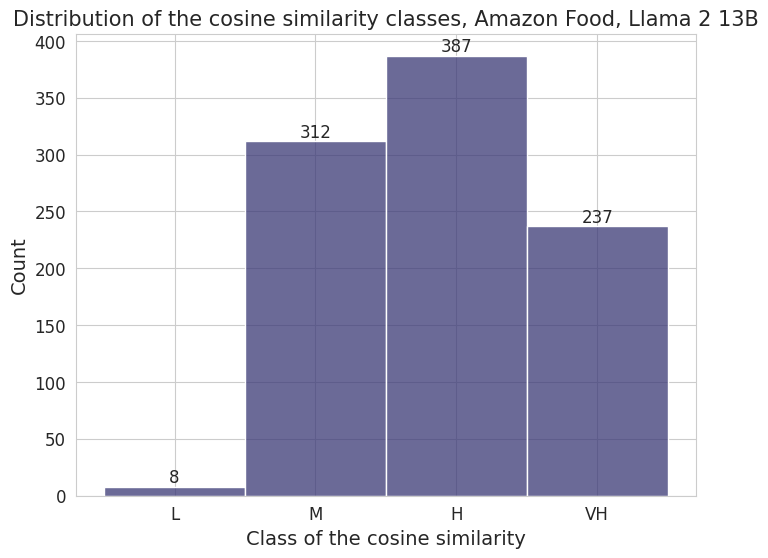

In [114]:
print_cos_sim_distrib(
    data=data_prompt_llama2_1_amazon,
    model_name="Llama 2 13B",
    dataset_name="Amazon Food",
    print_plot=True,
    label_size=14
)

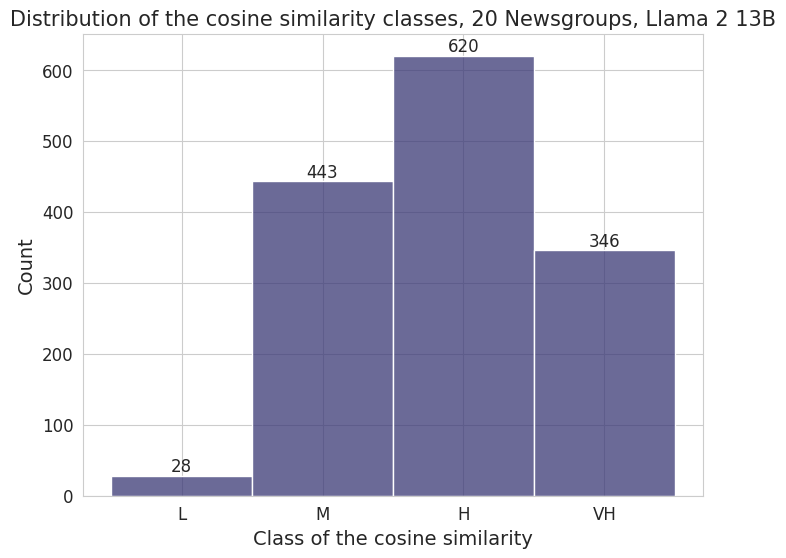

In [115]:
print_cos_sim_distrib(
    data=data_prompt_llama2_1_newsgroups,
    model_name="Llama 2 13B",
    dataset_name="20 Newsgroups",
    print_plot=True,
    label_size=14
)

### Results of the Metrics

In [262]:
PROMPT_LLAMA2_1_BAD = "data_topic_name_distrib_llama_13B_4bit_bad_type1.csv"
PROMPT_LLAMA2_1_BAD = DATA_DIR.joinpath(PROMPT_LLAMA2_1_BAD)
data_prompt_llama2_1_bad = pd.read_csv(PROMPT_LLAMA2_1_BAD, sep=";", names=["text", "topic"])

In [263]:
data_prompt_llama2_1 = data_prompt_llama2_1.drop_duplicates(subset="text", keep='first', ignore_index=True)

In [264]:
data_prompt_llama2_1 = pd.concat([data_prompt_llama2_1, data_prompt_llama2_1_bad], ignore_index=True)

In [265]:
data_prompt_llama2_1["topic"] = [x.lower() for x in data_prompt_llama2_1["topic"]]
data_prompt_llama2_1["topic"] = [x.replace("</s>", "") for x in data_prompt_llama2_1["topic"]]
data_prompt_llama2_1["topic"] = [x.replace(".", "") for x in data_prompt_llama2_1["topic"]]
data_prompt_llama2_1["topic"] = [extract_words_after_phrase(topic) for topic in data_prompt_llama2_1["topic"]]

for i, topic in enumerate(data_prompt_llama2_1["topic"]):
    if isinstance(topic, str):
        data_prompt_llama2_1["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_llama2_1["topic"].iloc[i]):
            data_prompt_llama2_1["topic"].iloc[i][j] = data_prompt_llama2_1["topic"].iloc[i][j].strip()
            

/tmp/ipykernel_112736/3602522989.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_prompt_llama2_1["topic"].iloc[i] = [topic]
/tmp/ipykernel_112736/3602522989.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in panda

In [266]:
# Split text into words
data_prompt_llama2_1["text_split"] = [text.split() for text in data_prompt_llama2_1["text"]]

In [267]:
data_prompt_llama2_1["cos_sim"] = TmEval.get_topic_metric(
    data_true=data_prompt_llama2_1["text_split"],
    data_pred=data_prompt_llama2_1["topic"]
)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/alexandra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/home/alexandra/anaconda3/envs/pytorch/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 3861/3861 [13:28<00:00,  4.78it/s]


In [268]:
data_prompt_llama2_1.to_csv("llama2_1_topic_gen.csv")

## Zero-shot Mistral New
You are the topic modeling assistant. You should extract the main theme that combines all the words from the list. Formulate it with a single word:

In [253]:
data_prompt_mistral_4.head(10)

text  \
0  earth orbit nasa mission moon satellite lunar ...   
1  dog treat training liver greenies ball pup dog...   
2  morning breakfast light packet indiv mild conv...   
3  snack chip healthy tasty family cheese they're...   
4  hell alaska eternal liar motto main acad crazy...   
5  syrup sometimes artificial high sweetener chem...   
6  chip star potato corn reason yellow kettle vin...   
7  error appreciate info motherboard graphics int...   
8  food disease medical doctor patient health tre...   
9  tasty fiber satisfy lunch healthier crunch dip...   

                                               topic  
0   The main theme that combines all the words fr...  
1   The main theme that combines all the words fr...  
2   The main theme that combines all the words fr...  
3   The main theme that combines all the words fr...  
4   The main theme that combines all the words fr...  
5   The main theme that combines all the words fr...  
6                                    "Addictive"</s>  
7   The main theme that combines all the words fr...  
8   The main theme that combines all the words fr...  
9   The main theme that combines all the words fr...

### Results of the Research

In [121]:
data_prompt_mistral_4["topic"] = [x.lower() for x in data_prompt_mistral_4["topic"]]
data_prompt_mistral_4["topic"] = [x.replace("</s>", "") for x in data_prompt_mistral_4["topic"]]
data_prompt_mistral_4["topic"] = [x.replace(".", "") for x in data_prompt_mistral_4["topic"]]
data_prompt_mistral_4["topic"] = [extract_text_in_quotes(topic) for topic in data_prompt_mistral_4["topic"]]

for i, topic in enumerate(data_prompt_mistral_4["topic"]):
    if isinstance(topic, str):
        data_prompt_mistral_4["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_mistral_4["topic"].iloc[i]):
            data_prompt_mistral_4["topic"].iloc[i][j] = data_prompt_mistral_4["topic"].iloc[i][j].strip()

In [122]:
data_prompt_mistral_4.head(10)

text                topic
0  earth orbit nasa mission moon satellite lunar ...  [space exploration]
1  dog treat training liver greenies ball pup dog...           [training]
2  morning breakfast light packet indiv mild conv...        [convenience]
3  snack chip healthy tasty family cheese they're...           [snacking]
4  hell alaska eternal liar motto main acad crazy...              [crazy]
5  syrup sometimes artificial high sweetener chem...          [sweetener]
6  chip star potato corn reason yellow kettle vin...          [addictive]
7  error appreciate info motherboard graphics int...           [computer]
8  food disease medical doctor patient health tre...             [health]
9  tasty fiber satisfy lunch healthier crunch dip...            [healthy]

In [123]:
# Combine model topics with original ones
original_topics_lst = []

for text in data_prompt_mistral_4["text"]:
    original_topic = original_topics_df.loc[original_topics_df["text"]==text, "topics"].values[0]
    original_topics_lst.append(original_topic)

data_prompt_mistral_4["true_topic"] = original_topics_lst

In [124]:
metrics_topics = TmEval.get_topic_metric(
    data_true=data_prompt_mistral_4["true_topic"],
    data_pred=data_prompt_mistral_4["topic"]
)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/alexandra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 2363/2363 [04:22<00:00,  9.01it/s]


In [125]:
data_prompt_mistral_4["cos_sim"] = metrics_topics

In [126]:
cos_sim_range = []

for cos_sim in data_prompt_mistral_4["cos_sim"]:
    if cos_sim >= 0.8:
        cos_sim_range.append("VH")
    elif cos_sim >= 0.6 and cos_sim < 0.8:
        cos_sim_range.append("H")
    elif cos_sim >= 0.3 and cos_sim < 0.6:
        cos_sim_range.append("M")
    elif cos_sim >= 0.0 and cos_sim < 0.3:
        cos_sim_range.append("L")
    else:
        cos_sim_range.append("VL")

data_prompt_mistral_4["cos_sim_class"] = cos_sim_range

In [127]:
# Divide entire data into two datasets
data_prompt_mistral_4_amazon = data_prompt_mistral_4[data_prompt_mistral_4["text"].isin(amazon_food_texts)]
data_prompt_mistral_4_newsgroups = data_prompt_mistral_4[data_prompt_mistral_4["text"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_mistral_4_amazon.shape)
print(f"20newsgroups:", data_prompt_mistral_4_newsgroups.shape)

Amazon: (932, 5)
20newsgroups: (1431, 5)


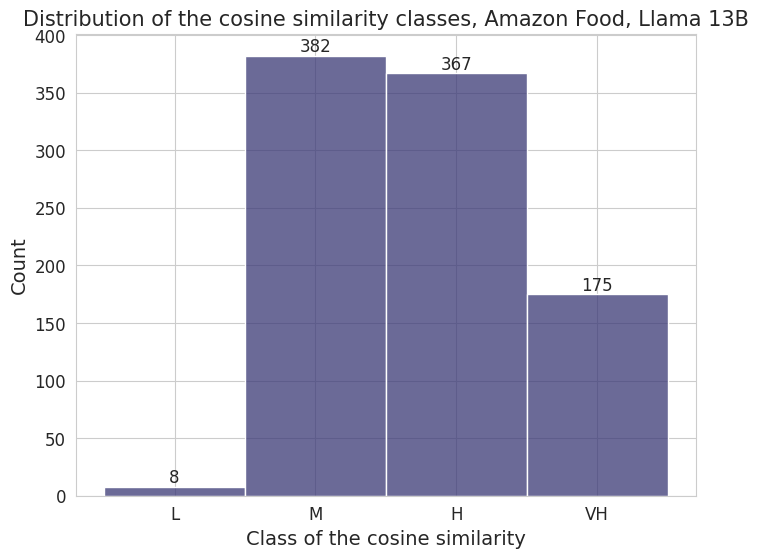

In [128]:
print_cos_sim_distrib(
    data=data_prompt_mistral_4_amazon,
    model_name="Llama 13B",
    dataset_name="Amazon Food",
    print_plot=True,
    label_size=14
)

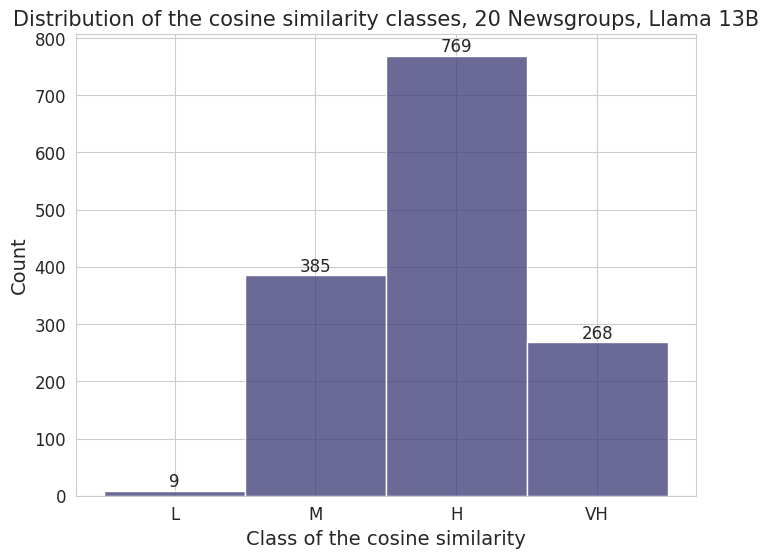

In [129]:
print_cos_sim_distrib(
    data=data_prompt_mistral_4_newsgroups,
    model_name="Llama 13B",
    dataset_name="20 Newsgroups",
    print_plot=True,
    label_size=14
)

### Results of the Metrics

In [254]:
PROMPT_MISTRAL_4_BAD = "data_topic_name_distrib_mistral_7b_4bit_type_bad_new.csv"
PROMPT_MISTRAL_4_BAD = DATA_DIR.joinpath(PROMPT_MISTRAL_4_BAD)
data_prompt_mistral_4_bad = pd.read_csv(PROMPT_MISTRAL_4_BAD, sep=";", names=["text", "topic"])

In [255]:
data_prompt_mistral_4 = pd.concat([data_prompt_mistral_4, data_prompt_mistral_4_bad], ignore_index=True)

In [256]:
data_prompt_mistral_4["topic"] = [x.lower() for x in data_prompt_mistral_4["topic"]]
data_prompt_mistral_4["topic"] = [x.replace("</s>", "") for x in data_prompt_mistral_4["topic"]]
data_prompt_mistral_4["topic"] = [x.replace(".", "") for x in data_prompt_mistral_4["topic"]]
data_prompt_mistral_4["topic"] = [extract_text_in_quotes(topic) for topic in data_prompt_mistral_4["topic"]]

for i, topic in enumerate(data_prompt_mistral_4["topic"]):
    if isinstance(topic, str):
        data_prompt_mistral_4["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_mistral_4["topic"].iloc[i]):
            data_prompt_mistral_4["topic"].iloc[i][j] = data_prompt_mistral_4["topic"].iloc[i][j].strip()

/tmp/ipykernel_112736/52353053.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_prompt_mistral_4["topic"].iloc[i] = [topic]
/tmp/ipykernel_112736/52353053.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3

In [259]:
# Split text into words
data_prompt_mistral_4["text_split"] = [text.split() for text in data_prompt_mistral_4["text"]]

data_prompt_mistral_4["cos_sim"] = TmEval.get_topic_metric(
    data_true=data_prompt_mistral_4["text_split"],
    data_pred=data_prompt_mistral_4["topic"]
)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/alexandra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/home/alexandra/anaconda3/envs/pytorch/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 3861/3861 [14:17<00:00,  4.50it/s]


In [261]:
data_prompt_mistral_4.to_csv("mistral_topic_gen.csv")

## Zero-shot Llama New
< s >[INST] << SYS >> You are the topic modeling assistant. <<\SYS>> You should understand the main theme that combines all the words from the list. Formulate it with a single word, print only this word in quotes and no additional text: quality chicken meat ingredient vegetable purchasing salmon hazelnut pricey base turkey tuna filler steak actually [/INST]

In [269]:
data_prompt_llama2_2.head(10)

text  \
0  encryption chip clipper security phone privacy...   
1  function code text islam muslim null subject e...   
2  package fresh item receive rice arrive gift di...   
3  chew pod pound toy bone caramel larger play pe...   
4  player hockey season league goal leaf playoff ...   
5  vanilla deal smooth brew several machine frenc...   
6  sweet bar crunchy granola crunch yogurt raisin...   
7  player season hockey league baseball goal divi...   
8  window display screen color manager server app...   
9  green wonderful bean vanilla black drinking ho...   

                                               topic  
0  Sure! Based on the list of words provided, the...  
1  Sure! Based on the list of words provided, the...  
2  Sure! Based on the list of words you provided,...  
3  Sure! Based on the list of words you provided,...  
4  Sure! Based on the list of words you provided,...  
5  Sure! Based on the list of words you provided,...  
6  Sure! Based on the list of words you provided,...  
7  Sure! Based on the list of words you provided,...  
8  Sure! Based on the list of words provided, the...  
9  Sure! Based on the list of words you provided,...

### Results of the Research

In [214]:
data_prompt_llama2_2["topic"] = [x.lower() for x in data_prompt_llama2_2["topic"]]
data_prompt_llama2_2["topic"] = [x.replace("</s>", "") for x in data_prompt_llama2_2["topic"]]
data_prompt_llama2_2["topic"] = [x.replace(".", "") for x in data_prompt_llama2_2["topic"]]
data_prompt_llama2_2["topic"] = [extract_text_in_quotes(topic) for topic in data_prompt_llama2_2["topic"]]

for i, topic in enumerate(data_prompt_llama2_2["topic"]):
    if isinstance(topic, str):
        data_prompt_llama2_2["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_llama2_2["topic"].iloc[i]):
            data_prompt_llama2_2["topic"].iloc[i][j] = data_prompt_llama2_2["topic"].iloc[i][j].strip()
            

In [215]:
# Combine model topics with original ones
original_topics_lst = []

for text in data_prompt_llama2_2["text"]:
    original_topic = original_topics_df.loc[original_topics_df["text"]==text, "topics"].values[0]
    original_topics_lst.append(original_topic)

data_prompt_llama2_2["true_topic"] = original_topics_lst

In [265]:
data_prompt_llama2_2["cos_sim"] = TmEval.get_topic_metric(
    data_true=data_prompt_llama2_2["true_topic"],
    data_pred=data_prompt_llama2_2["topic"]
)

In [183]:
cos_sim_range = []

for cos_sim in data_prompt_llama2_2["cos_sim"]:
    if cos_sim >= 0.8:
        cos_sim_range.append("VH")
    elif cos_sim >= 0.6 and cos_sim < 0.8:
        cos_sim_range.append("H")
    elif cos_sim >= 0.3 and cos_sim < 0.6:
        cos_sim_range.append("M")
    elif cos_sim >= 0.0 and cos_sim < 0.3:
        cos_sim_range.append("L")
    else:
        cos_sim_range.append("VL")

data_prompt_llama2_2["cos_sim_class"] = cos_sim_range

In [184]:
# Divide entire data into two datasets
data_prompt_llama2_2_amazon = data_prompt_llama2_2[data_prompt_llama2_2["text"].isin(amazon_food_texts)]
data_prompt_llama2_2_newsgroups = data_prompt_llama2_2[data_prompt_llama2_2["text"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_llama2_2_amazon.shape)
print(f"20newsgroups:", data_prompt_llama2_2_newsgroups.shape)

Amazon: (932, 5)
20newsgroups: (1431, 5)


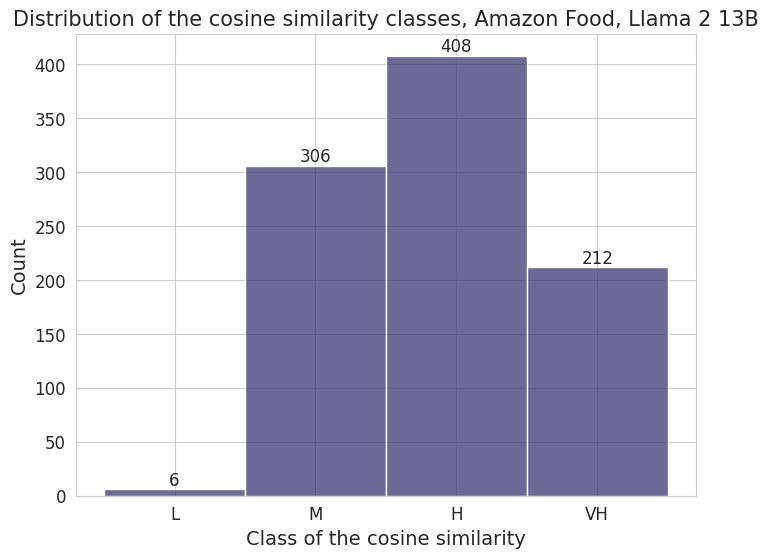

In [186]:
print_cos_sim_distrib(
    data=data_prompt_llama2_2_amazon,
    model_name="Llama 2 13B",
    dataset_name="Amazon Food",
    print_plot=True,
    label_size=14
)

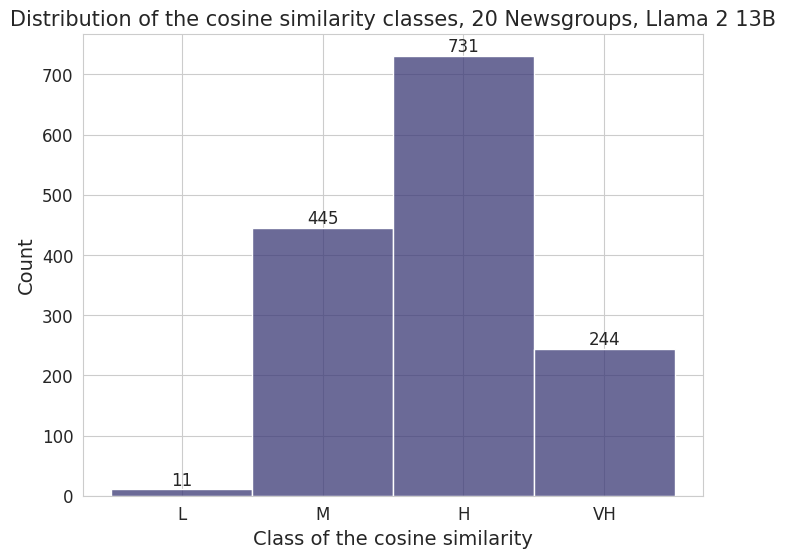

In [187]:
print_cos_sim_distrib(
    data=data_prompt_llama2_2_newsgroups,
    model_name="Llama 2 13B",
    dataset_name="20 Newsgroups",
    print_plot=True,
    label_size=14
)

### Results of the Metrics

In [272]:
PROMPT_LLAMA2_2_BAD = "data_topic_name_distrib_llama_13B_4bit_bad_new.csv"

PROMPT_LLAMA2_2_BAD = DATA_DIR.joinpath(PROMPT_LLAMA2_2_BAD)

data_prompt_llama2_2_bad = pd.read_csv(PROMPT_LLAMA2_2_BAD, sep=";", names=["text", "topic"])

In [273]:
data_prompt_llama2_2.head(10)

text  \
0  encryption chip clipper security phone privacy...   
1  function code text islam muslim null subject e...   
2  package fresh item receive rice arrive gift di...   
3  chew pod pound toy bone caramel larger play pe...   
4  player hockey season league goal leaf playoff ...   
5  vanilla deal smooth brew several machine frenc...   
6  sweet bar crunchy granola crunch yogurt raisin...   
7  player season hockey league baseball goal divi...   
8  window display screen color manager server app...   
9  green wonderful bean vanilla black drinking ho...   

                                               topic  
0  Sure! Based on the list of words provided, the...  
1  Sure! Based on the list of words provided, the...  
2  Sure! Based on the list of words you provided,...  
3  Sure! Based on the list of words you provided,...  
4  Sure! Based on the list of words you provided,...  
5  Sure! Based on the list of words you provided,...  
6  Sure! Based on the list of words you provided,...  
7  Sure! Based on the list of words you provided,...  
8  Sure! Based on the list of words provided, the...  
9  Sure! Based on the list of words you provided,...

In [274]:
data_prompt_llama2_2_bad.head(10)

text  \
0  strong highly cherry twice stronger slight sic...   
1  morning usually light breakfast packet mild ea...   
2  keyboard roger forward richard nick maynard gr...   
3  mouse helmet move carry live week rate andy po...   
4  fire kill child cause woman live left away doc...   
5  market tell turn difference mean cook pasta br...   
6  chip blend roast com www http href dark keurig...   
7  absolutely grain experience there's soon proce...   
8  old soup carry year stock area tomato discover...   
9  popcorn baby daughter jerky formula pill son p...   

                                               topic  
0  Sure ! Here ' s the topic modeling assistant '...  
1                            TOPIC : " CONVENIENCE "  
2                             TOPIC : " LEADERSHIP "  
3                                  TOPIC : ADVENTURE  
4                               TOP TOPIC : SURVIVAL  
5  Sure ! Based on the list of words you provided...  
6                                 TOPIC : " COFFEE "  
7                             TOPIC : " EXPERIENCE "  
8                                   TOPIC : " Soup "  
9  Sure ! Based on the list of words you provided...

In [275]:
data_prompt_llama2_2 = pd.concat([data_prompt_llama2_2, data_prompt_llama2_2_bad], ignore_index=True)


In [276]:
data_prompt_llama2_2["topic"] = [x.lower() for x in data_prompt_llama2_2["topic"]]
data_prompt_llama2_2["topic"] = [x.replace("</s>", "") for x in data_prompt_llama2_2["topic"]]
data_prompt_llama2_2["topic"] = [x.replace(".", "") for x in data_prompt_llama2_2["topic"]]
data_prompt_llama2_2["topic"] = [extract_text_in_quotes(topic) for topic in data_prompt_llama2_2["topic"]]

for i, topic in enumerate(data_prompt_llama2_2["topic"]):
    if isinstance(topic, str):
        data_prompt_llama2_2["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_llama2_2["topic"].iloc[i]):
            data_prompt_llama2_2["topic"].iloc[i][j] = data_prompt_llama2_2["topic"].iloc[i][j].strip()
            

/tmp/ipykernel_112736/856361636.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_prompt_llama2_2["topic"].iloc[i] = [topic]
/tmp/ipykernel_112736/856361636.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 

In [277]:
# Split text into words
data_prompt_llama2_2["text_split"] = [text.split() for text in data_prompt_llama2_2["text"]]

In [278]:
data_prompt_llama2_2["cos_sim"] = TmEval.get_topic_metric(
    data_true=data_prompt_llama2_2["text_split"],
    data_pred=data_prompt_llama2_2["topic"]
)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/alexandra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/home/alexandra/anaconda3/envs/pytorch/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 3861/3861 [13:53<00:00,  4.63it/s]


In [279]:
data_prompt_llama2_2.to_csv("llama2_2_topic_gen.csv")

# Calculate all correlations

In [181]:
DATASETS_DIR = BASE_DIR.joinpath('data/datasets')
# Topic Generation
PROMPT_MISTRAL1_GEN = "mistral_topic_gen.csv"
PROMPT_LLAMA1_GEN = "llama2_1_topic_gen.csv"
PROMPT_LLAMA2_GEN = "llama2_2_topic_gen.csv"

# Classification
# Two classes
PROMPT_MISTRAL1_CLASS2 = "mistral1_classification_2.csv"
PROMPT_MISTRAL2_CLASS2 = "mistral2_classification_2.csv"
PROMPT_MISTRAL3_CLASS2 = "mistral3_classification_2.csv"
PROMPT_LLAMA2_CLASS2 = "llama2_1_classification_2.csv"
PROMPT_LLAMA3_CLASS2 = "llama3_classification_2.csv"
PROMPT_MISTRAL_LORA2 = "mistral_lora_classification_2.csv"

# Four classes
PROMPT_MISTRAL1_CLASS4 = "mistral1_classification_4.csv"
PROMPT_MISTRAL2_CLASS4 = "mistral2_classification_4.csv"
PROMPT_MISTRAL3_CLASS4 = "mistral3_classification_4.csv"
PROMPT_LLAMA2_CLASS4 = "llama2_1_classification_4.csv"
PROMPT_LLAMA3_CLASS4 = "llama3_classification_4.csv"
PROMPT_MISTRAL_LORA4 = "mistral_lora_classification_4.csv"

# Five classes
PROMPT_MISTRAL1_CLASS5 = "mistral1_classification_5.csv"
PROMPT_MISTRAL2_CLASS5 = "mistral2_classification_5.csv"
PROMPT_LLAMA2_CLASS5 = "llama2_classification_5.csv"
PROMPT_LLAMA3_CLASS5 = "llama3_classification_5.csv"
PROMPT_MISTRAL_LORA5 = "mistral_lora_classification_5.csv"

# True
TRUE2 = "data_quality_estim.csv"
TRUE4 = "data_quality_estim_4classes.csv"
TRUE5 = "words_consistensy_wordset_dataset_agg.csv"


PROMPT_MISTRAL1_GEN = DATA_DIR.joinpath(PROMPT_MISTRAL1_GEN)
PROMPT_LLAMA1_GEN = DATA_DIR.joinpath(PROMPT_LLAMA1_GEN)
PROMPT_LLAMA2_GEN = DATA_DIR.joinpath(PROMPT_LLAMA2_GEN)

PROMPT_MISTRAL1_CLASS2 = DATA_DIR.joinpath(PROMPT_MISTRAL1_CLASS2)
PROMPT_MISTRAL2_CLASS2 = DATA_DIR.joinpath(PROMPT_MISTRAL2_CLASS2)
PROMPT_MISTRAL3_CLASS2 = DATA_DIR.joinpath(PROMPT_MISTRAL3_CLASS2)
PROMPT_LLAMA2_CLASS2 = DATA_DIR.joinpath(PROMPT_LLAMA2_CLASS2)
PROMPT_LLAMA3_CLASS2 = DATA_DIR.joinpath(PROMPT_LLAMA3_CLASS2)
PROMPT_MISTRAL_LORA2 = DATA_DIR.joinpath(PROMPT_MISTRAL_LORA2)

PROMPT_MISTRAL1_CLASS4 = DATA_DIR.joinpath(PROMPT_MISTRAL1_CLASS4)
PROMPT_MISTRAL2_CLASS4 = DATA_DIR.joinpath(PROMPT_MISTRAL2_CLASS4)
PROMPT_MISTRAL3_CLASS4 = DATA_DIR.joinpath(PROMPT_MISTRAL3_CLASS4)
PROMPT_LLAMA2_CLASS4 = DATA_DIR.joinpath(PROMPT_LLAMA2_CLASS4)
PROMPT_LLAMA3_CLASS4 = DATA_DIR.joinpath(PROMPT_LLAMA3_CLASS4)
PROMPT_MISTRAL_LORA4 = DATA_DIR.joinpath(PROMPT_MISTRAL_LORA4)

PROMPT_MISTRAL1_CLASS5 = DATA_DIR.joinpath(PROMPT_MISTRAL1_CLASS5)
PROMPT_MISTRAL2_CLASS5 = DATA_DIR.joinpath(PROMPT_MISTRAL2_CLASS5)
PROMPT_LLAMA2_CLASS5 = DATA_DIR.joinpath(PROMPT_LLAMA2_CLASS5)
PROMPT_LLAMA3_CLASS5 = DATA_DIR.joinpath(PROMPT_LLAMA3_CLASS5)
PROMPT_MISTRAL_LORA5 = DATA_DIR.joinpath(PROMPT_MISTRAL_LORA5)

TRUE2 = DATASETS_DIR.joinpath(TRUE2)
TRUE4 = DATASETS_DIR.joinpath(TRUE4)
TRUE5 = DATASETS_DIR.joinpath(TRUE5)


data_prompt_mistral_gen = pd.read_csv(PROMPT_MISTRAL1_GEN, sep=",", index_col=0)
data_prompt_llama_gen_1 = pd.read_csv(PROMPT_LLAMA1_GEN, sep=",", index_col=0)
data_prompt_llama_gen_2 = pd.read_csv(PROMPT_LLAMA2_GEN, sep=",", index_col=0)

data_prompt_mistral_1_class2 = pd.read_csv(PROMPT_MISTRAL1_CLASS2, sep=",", index_col=0)
data_prompt_mistral_2_class2 = pd.read_csv(PROMPT_MISTRAL2_CLASS2, sep=",", index_col=0)
data_prompt_mistral_3_class2 = pd.read_csv(PROMPT_MISTRAL3_CLASS2, sep=",", index_col=0)
data_prompt_llama2_class2 = pd.read_csv(PROMPT_LLAMA2_CLASS2, sep=",", index_col=0)
data_prompt_llama3_class2 = pd.read_csv(PROMPT_LLAMA3_CLASS2, sep=",", index_col=0)
data_prompt_mistral_lora_class2 = pd.read_csv(PROMPT_MISTRAL_LORA2, sep=",", index_col=0)

data_prompt_mistral_1_class4 = pd.read_csv(PROMPT_MISTRAL1_CLASS4, sep=",", index_col=0)
data_prompt_mistral_2_class4 = pd.read_csv(PROMPT_MISTRAL2_CLASS4, sep=",", index_col=0)
data_prompt_mistral_3_class4 = pd.read_csv(PROMPT_MISTRAL3_CLASS4, sep=",", index_col=0)
data_prompt_llama2_class4 = pd.read_csv(PROMPT_LLAMA2_CLASS4, sep=",", index_col=0)
data_prompt_llama3_class4 = pd.read_csv(PROMPT_LLAMA3_CLASS4, sep=",", index_col=0)
data_prompt_mistral_lora_class4 = pd.read_csv(PROMPT_MISTRAL_LORA4, sep=",", index_col=0)

data_prompt_mistral_1_class5 = pd.read_csv(PROMPT_MISTRAL1_CLASS5, sep=",", index_col=0)
data_prompt_mistral_2_class5 = pd.read_csv(PROMPT_MISTRAL2_CLASS5, sep=",", index_col=0)
data_prompt_llama2_class5 = pd.read_csv(PROMPT_LLAMA2_CLASS5, sep=",", index_col=0)
data_prompt_llama3_class5 = pd.read_csv(PROMPT_LLAMA3_CLASS5, sep=",", index_col=0)
data_prompt_mistral_lora_class5 = pd.read_csv(PROMPT_MISTRAL_LORA5, sep=",", index_col=0)

true2 = pd.read_csv(TRUE2, sep=',')
true4 = pd.read_csv(TRUE4, sep=',')
true5 = pd.read_csv(TRUE5, sep=',')

In [182]:
data_prompt_mistral_gen = data_prompt_mistral_gen.rename(columns={"text": "task"})[["task", "cos_sim"]]
data_prompt_llama_gen_1 = data_prompt_llama_gen_1.rename(columns={"text": "task"})[["task", "cos_sim"]]
data_prompt_llama_gen_2 = data_prompt_llama_gen_2.rename(columns={"text": "task"})[["task", "cos_sim"]]
true5 = true5.rename(columns={"INPUT:wordset": "task", "assessment": "true5"})[["task", "true5"]]

In [183]:
true2["agg_label"] = [words_to_num(x) for x in true2["agg_label"]]
true4["agg_label"] = [words_to_num(x) for x in true4["agg_label"]]

## Generation

### Mistral

In [108]:
data_prompt_mistral_gen = data_prompt_mistral_gen.merge(true2, how="inner", on="task").rename(columns={"agg_label": "true2"})
data_prompt_mistral_gen = data_prompt_mistral_gen.merge(true4, how="inner", on="task").rename(columns={"agg_label": "true4"})
data_prompt_mistral_gen = data_prompt_mistral_gen.merge(true5, how="inner", on="task")

In [109]:
# Divide entire data into two datasets
data_prompt_mistral_gen_amazon = data_prompt_mistral_gen[data_prompt_mistral_gen["task"].isin(amazon_food_texts)]
data_prompt_mistral_gen_newsgroups = data_prompt_mistral_gen[data_prompt_mistral_gen["task"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_mistral_gen_amazon.shape)
print(f"20newsgroups:", data_prompt_mistral_gen_newsgroups.shape)

Amazon: (1852, 5)
20newsgroups: (2009, 5)


#### Two classes

In [110]:
metrics_amazon_2 = calculate_corr(data_prompt_mistral_gen_amazon[["true2", "cos_sim"]].rename(columns={"true2": "true", "cos_sim": "pred"}))
metrics_newsgroups_2 = calculate_corr(data_prompt_mistral_gen_newsgroups[["true2", "cos_sim"]].rename(columns={"true2": "true", "cos_sim": "pred"}))

print("Correlations for Amazon Food\n")
print(metrics_amazon_2)
print("Correlations for 20 Newsgroups")
print(metrics_newsgroups_2)

interval columns not set, guessing: ['true', 'pred']


interval columns not set, guessing: ['true', 'pred']
Correlations for Amazon Food

       phik   pearson
0  0.441526  0.252463
Correlations for 20 Newsgroups
       phik   pearson
0  0.507576  0.391098


#### Four classes

In [111]:
metrics_amazon_4 = calculate_corr(data_prompt_mistral_gen_amazon[["true4", "cos_sim"]].rename(columns={"true4": "true", "cos_sim": "pred"}))
metrics_newsgroups_4 = calculate_corr(data_prompt_mistral_gen_newsgroups[["true4", "cos_sim"]].rename(columns={"true4": "true", "cos_sim": "pred"}))

print("Correlations for Amazon Food\n")
print(metrics_amazon_4)
print("Correlations for 20 Newsgroups")
print(metrics_newsgroups_4)

interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
Correlations for Amazon Food

       phik   pearson
0  0.309516  0.218632
Correlations for 20 Newsgroups
     phik   pearson
0  0.3707  0.394849


#### Five classes

In [112]:
metrics_amazon_5 = calculate_corr(data_prompt_mistral_gen_amazon[["true5", "cos_sim"]].rename(columns={"true5": "true", "cos_sim": "pred"}))
metrics_newsgroups_5 = calculate_corr(data_prompt_mistral_gen_newsgroups[["true5", "cos_sim"]].rename(columns={"true5": "true", "cos_sim": "pred"}))

print("Correlations for Amazon Food\n")
print(metrics_amazon_5)
print("Correlations for 20 Newsgroups")
print(metrics_newsgroups_5)

interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
Correlations for Amazon Food

       phik   pearson
0  0.397757  0.256889
Correlations for 20 Newsgroups
       phik   pearson
0  0.454191  0.409282


### Llama2 Type I

In [113]:
data_prompt_llama_gen_1 = data_prompt_llama_gen_1.merge(true2, how="inner", on="task").rename(columns={"agg_label": "true2"})
data_prompt_llama_gen_1 = data_prompt_llama_gen_1.merge(true4, how="inner", on="task").rename(columns={"agg_label": "true4"})
data_prompt_llama_gen_1 = data_prompt_llama_gen_1.merge(true5, how="inner", on="task")

In [114]:
# Divide entire data into two datasets
data_prompt_llama_gen_1_amazon = data_prompt_llama_gen_1[data_prompt_llama_gen_1["task"].isin(amazon_food_texts)]
data_prompt_llama_gen_1_newsgroups = data_prompt_llama_gen_1[data_prompt_llama_gen_1["task"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_llama_gen_1_amazon.shape)
print(f"20newsgroups:", data_prompt_llama_gen_1_newsgroups.shape)

Amazon: (1852, 5)
20newsgroups: (2009, 5)


#### Two classes

In [115]:
metrics_amazon_2 = calculate_corr(data_prompt_llama_gen_1_amazon[["true2", "cos_sim"]].rename(columns={"true2": "true", "cos_sim": "pred"}))
metrics_newsgroups_2 = calculate_corr(data_prompt_llama_gen_1_newsgroups[["true2", "cos_sim"]].rename(columns={"true2": "true", "cos_sim": "pred"}))

print("Correlations for Amazon Food\n")
print(metrics_amazon_2)
print("Correlations for 20 Newsgroups")
print(metrics_newsgroups_2)

interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
Correlations for Amazon Food

      phik   pearson
0  0.23615  0.114185
Correlations for 20 Newsgroups
       phik   pearson
0  0.264491  0.109445


#### Four classes

In [116]:
metrics_amazon_4 = calculate_corr(data_prompt_llama_gen_1_amazon[["true4", "cos_sim"]].rename(columns={"true4": "true", "cos_sim": "pred"}))
metrics_newsgroups_4 = calculate_corr(data_prompt_llama_gen_1_newsgroups[["true4", "cos_sim"]].rename(columns={"true4": "true", "cos_sim": "pred"}))

print("Correlations for Amazon Food\n")
print(metrics_amazon_4)
print("Correlations for 20 Newsgroups")
print(metrics_newsgroups_4)

interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
Correlations for Amazon Food

      phik   pearson
0  0.16425  0.111884
Correlations for 20 Newsgroups
   phik   pearson
0  0.21  0.127919


#### Five classes

In [117]:
metrics_amazon_5 = calculate_corr(data_prompt_llama_gen_1_amazon[["true5", "cos_sim"]].rename(columns={"true5": "true", "cos_sim": "pred"}))
metrics_newsgroups_5 = calculate_corr(data_prompt_llama_gen_1_newsgroups[["true5", "cos_sim"]].rename(columns={"true5": "true", "cos_sim": "pred"}))

print("Correlations for Amazon Food\n")
print(metrics_amazon_5)
print("Correlations for 20 Newsgroups")
print(metrics_newsgroups_5)

interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
Correlations for Amazon Food

       phik   pearson
0  0.216171  0.130251
Correlations for 20 Newsgroups
       phik   pearson
0  0.268996  0.125788


### Llama 2 Type II

In [118]:
data_prompt_llama_gen_2 = data_prompt_llama_gen_2.merge(true2, how="inner", on="task").rename(columns={"agg_label": "true2"})
data_prompt_llama_gen_2 = data_prompt_llama_gen_2.merge(true4, how="inner", on="task").rename(columns={"agg_label": "true4"})
data_prompt_llama_gen_2 = data_prompt_llama_gen_2.merge(true5, how="inner", on="task")

In [119]:
# Divide entire data into two datasets
data_prompt_llama_gen_2_amazon = data_prompt_llama_gen_2[data_prompt_llama_gen_2["task"].isin(amazon_food_texts)]
data_prompt_llama_gen_2_newsgroups = data_prompt_llama_gen_2[data_prompt_llama_gen_2["task"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_llama_gen_2_amazon.shape)
print(f"20newsgroups:", data_prompt_llama_gen_2_newsgroups.shape)

Amazon: (1852, 5)
20newsgroups: (2009, 5)


#### Two classes

In [120]:
metrics_amazon_2 = calculate_corr(data_prompt_llama_gen_2_amazon[["true2", "cos_sim"]].rename(columns={"true2": "true", "cos_sim": "pred"}))
metrics_newsgroups_2 = calculate_corr(data_prompt_llama_gen_2_newsgroups[["true2", "cos_sim"]].rename(columns={"true2": "true", "cos_sim": "pred"}))

print("Correlations for Amazon Food\n")
print(metrics_amazon_2)
print("Correlations for 20 Newsgroups")
print(metrics_newsgroups_2)

interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
Correlations for Amazon Food

       phik   pearson
0  0.252751  0.078675
Correlations for 20 Newsgroups
       phik   pearson
0  0.274213  0.147475


#### Four classes

In [121]:
metrics_amazon_4 = calculate_corr(data_prompt_llama_gen_2_amazon[["true4", "cos_sim"]].rename(columns={"true4": "true", "cos_sim": "pred"}))
metrics_newsgroups_4 = calculate_corr(data_prompt_llama_gen_2_newsgroups[["true4", "cos_sim"]].rename(columns={"true4": "true", "cos_sim": "pred"}))

print("Correlations for Amazon Food\n")
print(metrics_amazon_4)
print("Correlations for 20 Newsgroups")
print(metrics_newsgroups_4)

interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
Correlations for Amazon Food

       phik   pearson
0  0.165946  0.081238
Correlations for 20 Newsgroups
       phik   pearson
0  0.210484  0.162639


#### Five classes

In [122]:
metrics_amazon_5 = calculate_corr(data_prompt_llama_gen_2_amazon[["true5", "cos_sim"]].rename(columns={"true5": "true", "cos_sim": "pred"}))
metrics_newsgroups_5 = calculate_corr(data_prompt_llama_gen_2_newsgroups[["true5", "cos_sim"]].rename(columns={"true5": "true", "cos_sim": "pred"}))

print("Correlations for Amazon Food\n")
print(metrics_amazon_5)
print("Correlations for 20 Newsgroups")
print(metrics_newsgroups_5)

interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
Correlations for Amazon Food

       phik   pearson
0  0.219603  0.096389
Correlations for 20 Newsgroups
       phik   pearson
0  0.258426  0.163237


## Classification + Generation

In [184]:
data_prompt_mistral_1_class2 = data_prompt_mistral_1_class2.rename(columns={"classification_metric": "mistral1_cls"})[["task", "mistral1_cls"]]
data_prompt_mistral_2_class2 = data_prompt_mistral_2_class2.rename(columns={"classification_metric": "mistral2_cls"})[["task", "mistral2_cls"]]
data_prompt_mistral_3_class2 = data_prompt_mistral_3_class2.rename(columns={"classification_metric": "mistral3_cls"})[["task", "mistral3_cls"]]
data_prompt_llama2_class2 = data_prompt_llama2_class2.rename(columns={"classification_metric": "llama2_cls"})[["task", "llama2_cls"]]
data_prompt_llama3_class2 = data_prompt_llama3_class2.rename(columns={"classification_metric": "llama3_cls"})[["task", "llama3_cls"]]
data_prompt_mistral_lora_class2 = data_prompt_mistral_lora_class2.rename(columns={"classification_metric": "mistral_lora_cls"})[["task", "mistral_lora_cls"]]

data_prompt_mistral_1_class4 = data_prompt_mistral_1_class4.rename(columns={"classification_metric": "mistral1_cls"})[["task", "mistral1_cls"]]
data_prompt_mistral_2_class4 = data_prompt_mistral_2_class4.rename(columns={"classification_metric": "mistral2_cls"})[["task", "mistral2_cls"]]
data_prompt_mistral_3_class4 = data_prompt_mistral_3_class4.rename(columns={"classification_metric": "mistral3_cls"})[["task", "mistral3_cls"]]
data_prompt_llama2_class4 = data_prompt_llama2_class4.rename(columns={"classification_metric": "llama2_cls"})[["task", "llama2_cls"]]
data_prompt_llama3_class4 = data_prompt_llama3_class4.rename(columns={"classification_metric": "llama3_cls"})[["task", "llama3_cls"]]
data_prompt_mistral_lora_class4 = data_prompt_mistral_lora_class4.rename(columns={"classification_metric": "mistral_lora_cls"})[["task", "mistral_lora_cls"]]

data_prompt_mistral_1_class5 = data_prompt_mistral_1_class5.rename(columns={"classification_metric": "mistral1_cls"})[["task", "mistral1_cls"]]
data_prompt_mistral_2_class5 = data_prompt_mistral_2_class5.rename(columns={"classification_metric": "mistral2_cls"})[["task", "mistral2_cls"]]
data_prompt_llama2_class5 = data_prompt_llama2_class5.rename(columns={"classification_metric": "llama2_cls"})[["task", "llama2_cls"]]
data_prompt_llama3_class5 = data_prompt_llama3_class5.rename(columns={"classification_metric": "llama3_cls"})[["task", "llama3_cls"]]
data_prompt_mistral_lora_class5 = data_prompt_mistral_lora_class5.rename(columns={"classification_metric": "mistral_lora_cls"})[["task", "mistral_lora_cls"]]

In [185]:
two_classes_metrics = true2.merge(data_prompt_mistral_1_class2, how="inner", on="task")
two_classes_metrics = two_classes_metrics.merge(data_prompt_mistral_2_class2, how="inner", on="task")
two_classes_metrics = two_classes_metrics.merge(data_prompt_mistral_3_class2, how="inner", on="task")
two_classes_metrics = two_classes_metrics.merge(data_prompt_llama2_class2, how="inner", on="task")
two_classes_metrics = two_classes_metrics.merge(data_prompt_llama3_class2, how="inner", on="task")
two_classes_metrics = two_classes_metrics.merge(data_prompt_mistral_lora_class2, how="inner", on="task")

four_classes_metrics = true4.merge(data_prompt_mistral_1_class4, how="inner", on="task")
four_classes_metrics = four_classes_metrics.merge(data_prompt_mistral_2_class4, how="inner", on="task")
four_classes_metrics = four_classes_metrics.merge(data_prompt_mistral_3_class4, how="inner", on="task")
four_classes_metrics = four_classes_metrics.merge(data_prompt_llama2_class4, how="inner", on="task")
four_classes_metrics = four_classes_metrics.merge(data_prompt_llama3_class4, how="inner", on="task")
four_classes_metrics = four_classes_metrics.merge(data_prompt_mistral_lora_class4, how="inner", on="task")

five_classes_metrics = true5.merge(data_prompt_mistral_1_class5, how="inner", on="task")
five_classes_metrics = five_classes_metrics.merge(data_prompt_mistral_2_class5, how="inner", on="task")
five_classes_metrics = five_classes_metrics.merge(data_prompt_llama2_class5, how="inner", on="task")
five_classes_metrics = five_classes_metrics.merge(data_prompt_llama3_class5, how="inner", on="task")
five_classes_metrics = five_classes_metrics.merge(data_prompt_mistral_lora_class5, how="inner", on="task")

In [186]:
data_prompt_mistral_gen = data_prompt_mistral_gen.rename(columns={"cos_sim": "mistral_cos_sim"})
data_prompt_llama_gen_1 = data_prompt_llama_gen_1.rename(columns={"cos_sim": "llama_1_cos_sim"})
data_prompt_llama_gen_2 = data_prompt_llama_gen_2.rename(columns={"cos_sim": "llama_2_cos_sim"})

In [187]:
gen_metrics = data_prompt_mistral_gen.merge(data_prompt_llama_gen_1, how="inner", on="task")
gen_metrics = gen_metrics.merge(data_prompt_llama_gen_2, how="inner", on="task")

### Two classes

In [198]:
gen_cols = gen_metrics.columns[1:]
class_cols2 = two_classes_metrics.columns[2:]
class_cols4 = four_classes_metrics.columns[2:]
class_cols5 = five_classes_metrics.columns[2:]

In [212]:
# Two classes
true2_copy = true2.copy().rename(columns={"agg_label": "true"})

for gen_col in gen_cols:
    for class_col in class_cols2:
        true2_copy[f"{gen_col}+{class_col}"] = (gen_metrics[gen_col] + two_classes_metrics[class_col]) / 2


# Correlations
# Divide entire data into two datasets
true2_copy_amazon = true2_copy[true2_copy["task"].isin(amazon_food_texts)]
true2_copy_newsgroups = true2_copy[true2_copy["task"].isin(newsgroups_texts)]
print(f"Amazon:", true2_copy_amazon.shape)
print(f"20newsgroups:", true2_copy_newsgroups.shape)

amazon_corr2 = pd.DataFrame(data={"metrics_name": true2_copy.columns[2:]})
newsgroups_corr2 = pd.DataFrame(data={"metrics_name": true2_copy.columns[2:]})

phik_corr2_amazon = []
lin_corr2_amazon = []
phik_corr2_newsgroups = []
lin_corr2_newsgroups = []

for col in true2_copy.columns[2:]:
    # Amazon
    amazon_metric_df = calculate_corr(true2_copy_amazon[["true", col]].rename(columns={col: "pred"}))
    # 20 Newsgroups
    newsgroups_metric_df = calculate_corr(true2_copy_newsgroups[["true", col]].rename(columns={col: "pred"}))

    phik_corr2_amazon.append(amazon_metric_df.iloc[0]["phik"])
    lin_corr2_amazon.append(amazon_metric_df.iloc[0]["pearson"])

    phik_corr2_newsgroups.append(newsgroups_metric_df.iloc[0]["phik"])
    lin_corr2_newsgroups.append(newsgroups_metric_df.iloc[0]["pearson"])   

amazon_corr2["phik"] = phik_corr2_amazon
amazon_corr2["pearson"] = lin_corr2_amazon

newsgroups_corr2["phik"] = phik_corr2_newsgroups
newsgroups_corr2["pearson"] = lin_corr2_newsgroups


Amazon: (1852, 20)
20newsgroups: (2009, 20)
interval columns not set, guessing: ['true', 'pred']


interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', '

In [216]:
amazon_corr2.to_csv("cls+gen_corr_amazon_2.csv")
newsgroups_corr2.to_csv("cls+gen_corr_newsgroups_2.csv")

In [217]:
# Four classes
true4_copy = true4.copy().rename(columns={"agg_label": "true"})

for gen_col in gen_cols:
    for class_col in class_cols4:
        true4_copy[f"{gen_col}+{class_col}"] = (gen_metrics[gen_col] + four_classes_metrics[class_col]) / 2


# Correlations
# Divide entire data into two datasets
true4_copy_amazon = true4_copy[true4_copy["task"].isin(amazon_food_texts)]
true4_copy_newsgroups = true4_copy[true4_copy["task"].isin(newsgroups_texts)]
print(f"Amazon:", true4_copy_amazon.shape)
print(f"20newsgroups:", true4_copy_newsgroups.shape)

amazon_corr4 = pd.DataFrame(data={"metrics_name": true4_copy.columns[2:]})
newsgroups_corr4 = pd.DataFrame(data={"metrics_name": true4_copy.columns[2:]})

phik_corr4_amazon = []
lin_corr4_amazon = []
phik_corr4_newsgroups = []
lin_corr4_newsgroups = []

for col in true4_copy.columns[2:]:
    # Amazon
    amazon_metric_df = calculate_corr(true4_copy_amazon[["true", col]].rename(columns={col: "pred"}))
    # 20 Newsgroups
    newsgroups_metric_df = calculate_corr(true4_copy_newsgroups[["true", col]].rename(columns={col: "pred"}))

    phik_corr4_amazon.append(amazon_metric_df.iloc[0]["phik"])
    lin_corr4_amazon.append(amazon_metric_df.iloc[0]["pearson"])

    phik_corr4_newsgroups.append(newsgroups_metric_df.iloc[0]["phik"])
    lin_corr4_newsgroups.append(newsgroups_metric_df.iloc[0]["pearson"])   

amazon_corr4["phik"] = phik_corr4_amazon
amazon_corr4["pearson"] = lin_corr4_amazon

newsgroups_corr4["phik"] = phik_corr4_newsgroups
newsgroups_corr4["pearson"] = lin_corr4_newsgroups


Amazon: (1852, 20)
20newsgroups: (2009, 20)
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
in

In [218]:
amazon_corr4.to_csv("cls+gen_corr_amazon_4.csv")
newsgroups_corr4.to_csv("cls+gen_corr_newsgroups_4.csv")

In [224]:
# Five classes
true5_copy = true5.copy().rename(columns={"true5": "true"})

for gen_col in gen_cols:
    for class_col in class_cols5:
        true5_copy[f"{gen_col}+{class_col}"] = (gen_metrics[gen_col] + five_classes_metrics[class_col]) / 2


# Correlations
# Divide entire data into two datasets
true5_copy_amazon = true5_copy[true5_copy["task"].isin(amazon_food_texts)]
true5_copy_newsgroups = true5_copy[true5_copy["task"].isin(newsgroups_texts)]
print(f"Amazon:", true5_copy_amazon.shape)
print(f"20newsgroups:", true5_copy_newsgroups.shape)

amazon_corr5 = pd.DataFrame(data={"metrics_name": true5_copy.columns[2:]})
newsgroups_corr5 = pd.DataFrame(data={"metrics_name": true5_copy.columns[2:]})

phik_corr5_amazon = []
lin_corr5_amazon = []
phik_corr5_newsgroups = []
lin_corr5_newsgroups = []

for col in true5_copy.columns[2:]:
    # Amazon
    amazon_metric_df = calculate_corr(true5_copy_amazon[["true", col]].rename(columns={col: "pred"}))
    # 20 Newsgroups
    newsgroups_metric_df = calculate_corr(true5_copy_newsgroups[["true", col]].rename(columns={col: "pred"}))

    phik_corr5_amazon.append(amazon_metric_df.iloc[0]["phik"])
    lin_corr5_amazon.append(amazon_metric_df.iloc[0]["pearson"])

    phik_corr5_newsgroups.append(newsgroups_metric_df.iloc[0]["phik"])
    lin_corr5_newsgroups.append(newsgroups_metric_df.iloc[0]["pearson"])   

amazon_corr5["phik"] = phik_corr5_amazon
amazon_corr5["pearson"] = lin_corr5_amazon

newsgroups_corr5["phik"] = phik_corr5_newsgroups
newsgroups_corr5["pearson"] = lin_corr5_newsgroups


Amazon: (1852, 17)
20newsgroups: (2009, 17)
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
interval columns not set, guessing: ['true', 'pred']
in

In [225]:
amazon_corr5.to_csv("cls+gen_corr_amazon_5.csv")
newsgroups_corr5.to_csv("cls+gen_corr_newsgroups_5.csv")